In this project, I worked with a housing dataset from Kaggle, focusing on cleaning, modeling, and predicting house sale prices based on various property characteristics. The modeling techniques used include forward feature selection with least squares, ridge and lasso regression, as well as tree-based methods like random forests, bagging, and boosting

## Data Cleaning

First, I load the required packages I will use during cleaning of the two datasets. 

In [1]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(onehot)
library(MASS)
library(e1071)
library(car)
library(caret)
library(vcd)
library(leaps)
library(glmnet)
library(tree)
library(randomForest)
library(gbm)

#Configure select() so that it works with MASS package loaded
select <- dplyr::select


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


Loading required package: lattice

Loading required package: grid

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1-8

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin


The following object is masked from 'package:dplyr':

    combine


Loaded gbm 2.2.2

This version of gbm is no longer under development. Consider transiti

The data is sourced from an ongoing Kaggle competition, called 'House Prices - Advanced Regression Techniques'. This competition provides two datasets, a train and a test, however, the test dataset does not contain sale prices, so predictions will be tested on the Kaggle website. Next, I load in the two provided datasets, and initialize new dataframes to perform cleaning operations on. 

In [2]:
#Read the training set into R
raw_train_data <- read.csv("train.csv")
raw_test_data <- read.csv("test.csv")

#Set the seed to create reproducible results
set.seed(123)

#Create a cleaned train and test data set
cleaned_train_data <- raw_train_data
cleaned_test_data <- raw_test_data

Next, I clean each column. This involves converting to the correct data type (usually a factor or numeric), checking for and dealing with NA and missing values, examining and fixing skewed distributions, and removing, or adjusting variables based on their relevance to modeling. 

In [3]:
##COLUMN 1: Id
sum(is.na(cleaned_train_data$Id))
#TEST DATA
sum(is.na(cleaned_test_data$Id))

[1] 0

[1] 0

In [4]:

##COLUMN 2: MSSubClass
sum(is.na(cleaned_train_data$MSSubClass))
cleaned_train_data$MSSubClass <- as.factor(cleaned_train_data$MSSubClass)
levels(cleaned_train_data$MSSubClass) <- c("20", "30", "40", "45", "50", "60",
                                           "70", "75", "80", "85", "90", "120", 
                                           "150", "160", "180")
cleaned_train_data %>% 
  group_by(MSSubClass) %>%
  summarise(no_rows = length(MSSubClass))
#0 missing value
#TEST DATA
sum(is.na(cleaned_test_data$MSSubClass))
cleaned_test_data %>% 
  group_by(MSSubClass) %>%
  summarise(no_rows = length(MSSubClass))
#Since there is no level 190 in the training set, I'll have to replace the data with 
#   MSSubClass = 190, to the most common value, 20, in the test set. 
cleaned_test_data$MSSubClass <- ifelse(cleaned_test_data$MSSubClass == 190, 20, 
                                       cleaned_test_data$MSSubClass)
cleaned_test_data$MSSubClass <- as.factor(cleaned_test_data$MSSubClass)


[1] 0

MSSubClass,no_rows
<fct>,<int>
20,536
30,69
40,4
45,12
50,144
60,299
70,60
75,16
80,58


[1] 0

MSSubClass,no_rows
<int>,<int>
20,543
30,70
40,2
45,6
50,143
60,276
70,68
75,7
80,60


In [5]:

##COLUMN 3: MSZoning
sum(is.na(cleaned_train_data$MSZoning))
summary(factor(cleaned_train_data$MSZoning))
#No missing value
#Change the MSZoning "C (all)" level to "C" to match the data description.
levels(cleaned_train_data$MSZoning)[levels(cleaned_train_data$MSZoning) == "C (all)"] <- "C"
cleaned_train_data$MSZoning <- as.factor(cleaned_train_data$MSZoning)
#TEST DATA
sum(is.na(cleaned_test_data$MSZoning)) #I notice four NA's
#I will replace the NA values with the most common category "RL"
cleaned_test_data$MSZoning <- ifelse(is.na(cleaned_test_data$MSZoning) == TRUE, 
                                     "RL", cleaned_test_data$MSZoning)
summary(factor(cleaned_test_data$MSZoning))
levels(cleaned_test_data$MSZoning)[levels(cleaned_test_data$MSZoning) == "C (all)"] <- "C"
cleaned_test_data$MSZoning <- as.factor(cleaned_test_data$MSZoning)


[1] 0

C (all)      FV      RH      RL      RM 
     10      65      16    1151     218

[1] 4

C (all)      FV      RH      RL      RM 
     15      74      10    1118     242

[1] 259

MSZoning,mean
<fct>,<dbl>
C (all),69.70000
FV,59.49123
RH,58.92308
RL,74.68004
RM,52.36683


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


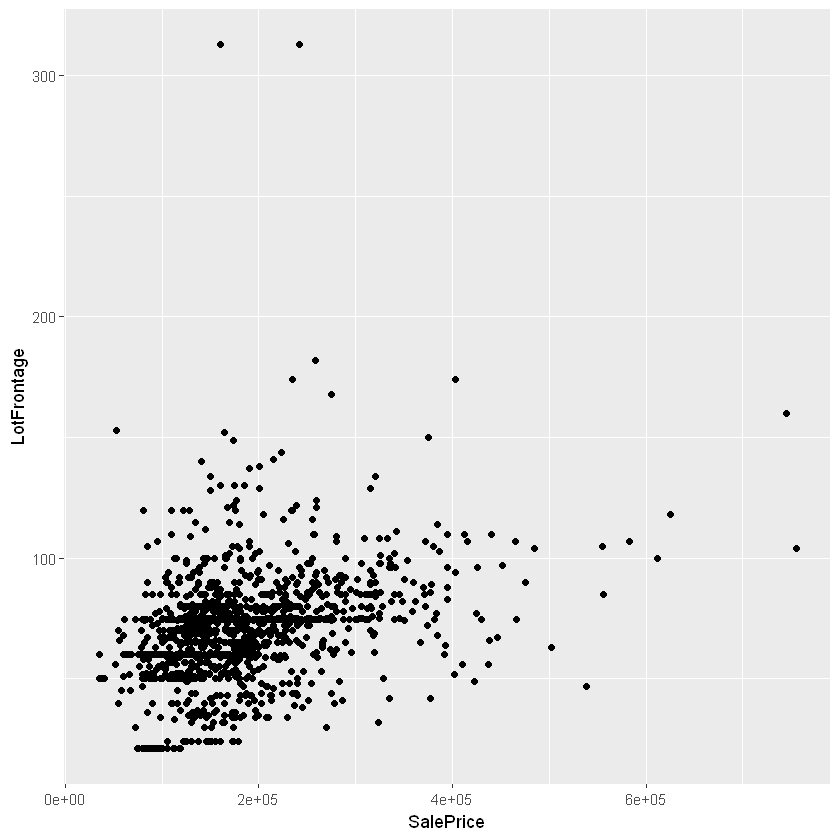

[1] 0.6696896

[1] 227

MSZoning,mean
<fct>,<dbl>
C (all),62.46154
FV,59.56452
RH,50.90000
RL,73.52283
RM,52.14097


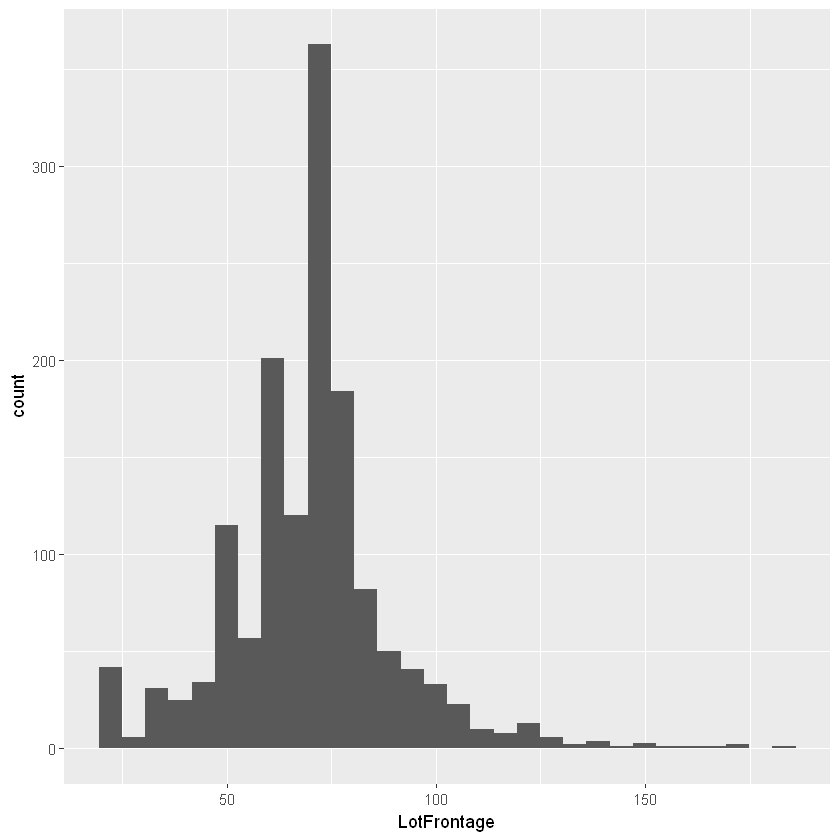

In [6]:

##COLUMN 4: LotFrontage
cleaned_train_data$LotFrontage <- as.numeric(cleaned_train_data$LotFrontage)
sum(is.na(cleaned_train_data$LotFrontage))
#259 missing values
#Replace missing values with the mean that corresponds to the category of MSZoning.
#Find the mean LotFrontage value for each factor of MSZoning when 
#LotFrontage is not an NA value
cleaned_train_data %>%
  group_by(MSZoning) %>%
  select(MSZoning, LotFrontage) %>%
  summarize(mean = mean(LotFrontage, na.rm = TRUE))
#Mean LotFrontage for each type of MSZoning
#  C         69.7
#  FV        59.5
#  RH        58.9
#  RL        74.7
#  RM        52.4
#Impute the mean LotFrontage by MSZoning into all NAs of LotFrontage
cleaned_train_data$LotFrontage[which((cleaned_train_data$MSZoning == "C (all)" & is.na(cleaned_train_data$LotFrontage)))] <- 69.7
cleaned_train_data$LotFrontage[which((cleaned_train_data$MSZoning == "FV" & is.na(cleaned_train_data$LotFrontage)))] <- 59.5
cleaned_train_data$LotFrontage[which((cleaned_train_data$MSZoning == "RH" & is.na(cleaned_train_data$LotFrontage)))] <- 58.9
cleaned_train_data$LotFrontage[which((cleaned_train_data$MSZoning == "RL" & is.na(cleaned_train_data$LotFrontage)))] <- 74.7
cleaned_train_data$LotFrontage[which((cleaned_train_data$MSZoning == "RM" & is.na(cleaned_train_data$LotFrontage)))] <- 52.4
#Identify outliers.
ggplot(cleaned_train_data, aes(SalePrice, LotFrontage)) + geom_point()
#Outliers of LotFrontage seem to occur around 300.
#Replace outliers with mean.
cleaned_train_data$LotFrontage <- ifelse(cleaned_train_data$LotFrontage > 300, 
                                         mean(cleaned_train_data$LotFrontage), 
                                         cleaned_train_data$LotFrontage)
#Skewness 
ggplot(cleaned_train_data, aes(LotFrontage)) + geom_histogram()
skewness(cleaned_train_data$LotFrontage)
#The value is 0.67, moderately skewed.
#No transformation
#TEST DATA
cleaned_test_data$LotFrontage <- as.numeric(cleaned_test_data$LotFrontage)
sum(is.na(cleaned_test_data$LotFrontage))
cleaned_test_data %>%
  group_by(MSZoning) %>%
  select(MSZoning, LotFrontage) %>%
  summarize(mean = mean(LotFrontage, na.rm = TRUE))
cleaned_test_data$LotFrontage[which((cleaned_test_data$MSZoning == "C (all)" & is.na(cleaned_test_data$LotFrontage)))] <- 62.5
cleaned_test_data$LotFrontage[which((cleaned_test_data$MSZoning == "FV" & is.na(cleaned_test_data$LotFrontage)))] <- 59.6
cleaned_test_data$LotFrontage[which((cleaned_test_data$MSZoning == "RH" & is.na(cleaned_test_data$LotFrontage)))] <- 50.9
cleaned_test_data$LotFrontage[which((cleaned_test_data$MSZoning == "RL" & is.na(cleaned_test_data$LotFrontage)))] <- 73.5
cleaned_test_data$LotFrontage[which((cleaned_test_data$MSZoning == "RM" & is.na(cleaned_test_data$LotFrontage)))] <- 52.1


[1] 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


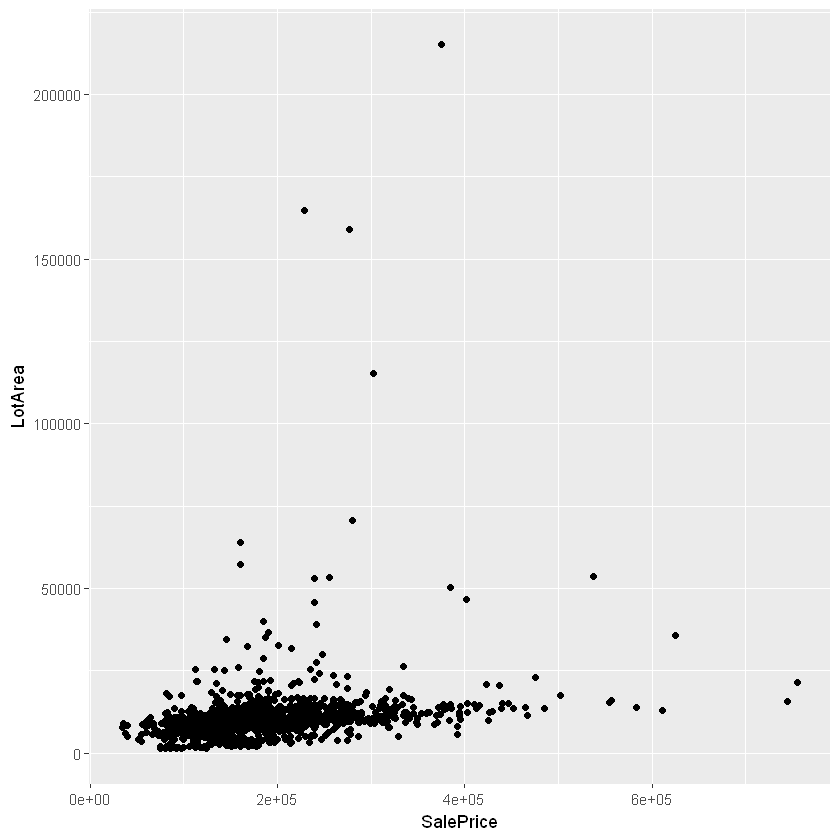

[1] 4.131525

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


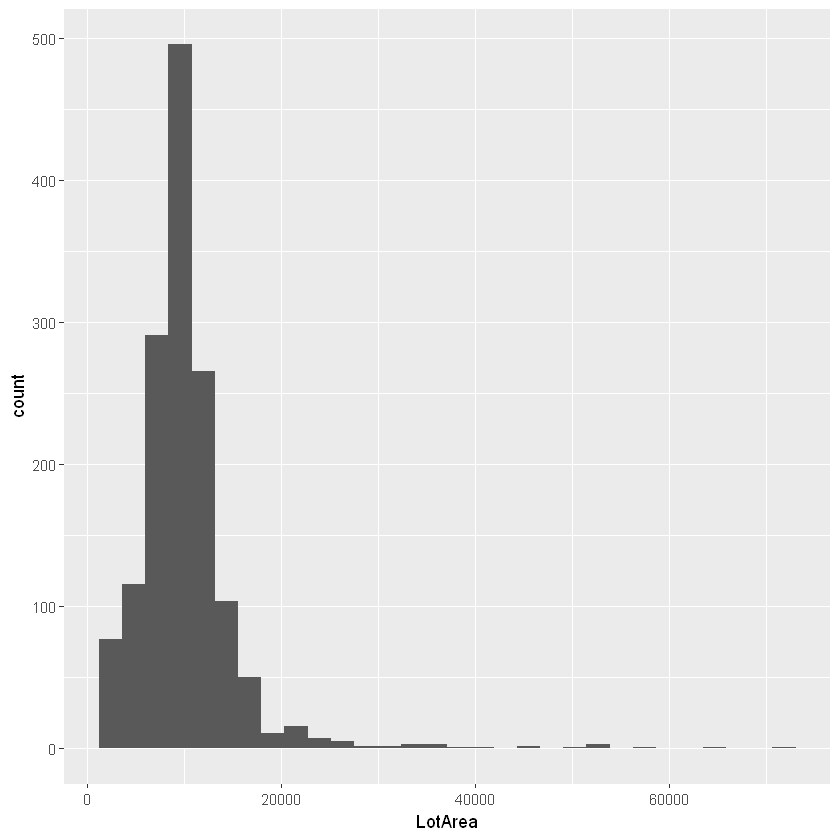

[1] -0.6553199

[1] 0

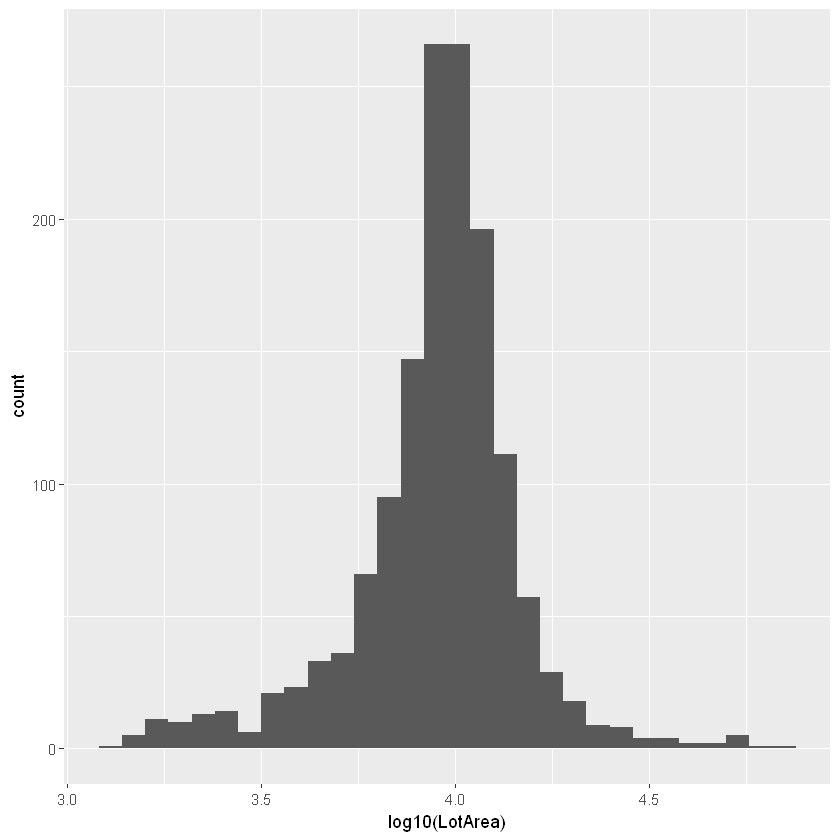

In [7]:

##COLUMN 5: LotArea
cleaned_train_data$LotArea <- as.numeric(cleaned_train_data$LotArea)
sum(is.na(cleaned_train_data$LotArea))
#No missing value.
#Identify outliers.
ggplot(cleaned_train_data, aes(SalePrice, LotArea)) + geom_point()
#Outliers seem to occur around 100,000.
#Replace outliers with mean.
cleaned_train_data$LotArea <- ifelse(cleaned_train_data$LotArea > 100000, 
                                     mean(cleaned_train_data$LotArea), 
                                     cleaned_train_data$LotArea)
#Skewness
ggplot(cleaned_train_data, aes(LotArea)) + geom_histogram()
skewness(cleaned_train_data$LotArea)
#The value is 4.13, highly skewed.
#The histogram also displays right skewness.
#Try log transformation.
ggplot(cleaned_train_data, aes(log10(LotArea))) + geom_histogram()
skewness(log10(cleaned_train_data$LotArea))
#The value is -0.655, only moderately skewed.Good!
cleaned_train_data$LotArea <- log10(cleaned_train_data$LotArea)
#TEST DATA
cleaned_test_data$LotArea <- as.numeric(cleaned_test_data$LotArea)
sum(is.na(cleaned_test_data$LotArea)) #No missing values
cleaned_test_data$LotArea <- log10(cleaned_test_data$LotArea)



In [8]:

##COLUMN 6: Street
sum(is.na(cleaned_train_data$Street))
summary(factor(cleaned_train_data$Street))
#no missing value or typo
#Only 6 out of 1460 cases are Grvl! The rest are Pave.
#Therefore, Street should be removed because 
#it won't provide any useful insights in the modeling.
cleaned_train_data$Street <- as.factor(cleaned_train_data$Street)
#TEST DATA
sum(is.na(cleaned_test_data$Street))
summary(factor(cleaned_test_data$Street))
cleaned_test_data$Street <- as.factor(cleaned_test_data$Street)
#REMOVE THIS VARIABLE 


[1] 0

Grvl Pave 
   6 1454

[1] 0

Grvl Pave 
   6 1453

In [9]:

##COLUMN 7: Alley
sum(is.na(cleaned_train_data$Alley))
summary(factor(cleaned_train_data$Alley))
#1369 NAs
#According the description about Alley, NA in fact represents No alley access.
#replace NA with "No alley access" to avoid confusion.
cleaned_train_data$Alley[is.na(cleaned_train_data$Alley)] <- "No alley access"
cleaned_train_data$Alley <- as.factor(cleaned_train_data$Alley)
cleaned_train_data %>%
  group_by(Alley) %>%
  summarize(no_rows = length(Alley))
#TEST DATA
sum(is.na(cleaned_test_data$Alley))
summary(factor(cleaned_test_data$Alley))
cleaned_test_data$Alley[is.na(cleaned_test_data$Alley)] <- "No alley access"
cleaned_test_data$Alley <- as.factor(cleaned_test_data$Alley)
cleaned_test_data %>%
  group_by(Alley) %>%
  summarize(no_rows = length(Alley))


[1] 1369

Grvl Pave NA's 
  50   41 1369

Alley,no_rows
<fct>,<int>
Grvl,50
No alley access,1369
Pave,41


[1] 1352

Grvl Pave NA's 
  70   37 1352

Alley,no_rows
<fct>,<int>
Grvl,70
No alley access,1352
Pave,37


In [10]:

##COLUMN 8: LotShape
sum(is.na(cleaned_train_data$LotShape))
summary(factor(cleaned_train_data$LotShape))
#0 mising value or typo
cleaned_train_data$LotShape<- factor(cleaned_train_data$LotShape, order = TRUE, 
                                     levels = c("IR3", "IR2", "IR1", "Reg"))
#TEST DATA
sum(is.na(cleaned_test_data$LotShape))
summary(factor(cleaned_test_data$LotShape))
#0 mising value or typo
cleaned_test_data$LotShape<- factor(cleaned_test_data$LotShape, order = TRUE, 
                                    levels = c("IR3", "IR2", "IR1", "Reg"))


[1] 0

IR1 IR2 IR3 Reg 
484  41  10 925

[1] 0

IR1 IR2 IR3 Reg 
484  35   6 934

In [11]:

##COLUMN 9: LandContour
sum(is.na(cleaned_train_data$LandContour))
summary(factor(cleaned_train_data$LandContour))
#no missing value or typo
cleaned_train_data$LandContour <- as.factor(cleaned_train_data$LandContour)
#TEST DATA
sum(is.na(cleaned_test_data$LandContour))
summary(factor(cleaned_test_data$LandContour))
#no missing value or typo
cleaned_test_data$LandContour <- as.factor(cleaned_test_data$LandContour)


[1] 0

Bnk  HLS  Low  Lvl 
  63   50   36 1311

[1] 0

Bnk  HLS  Low  Lvl 
  54   70   24 1311

In [12]:

##COLUMN 10: Utilities
sum(is.na(cleaned_train_data$Utilities))
summary(factor(cleaned_train_data$Utilities))
#no missing value or typo
#Only one case is NoSeWa!The rest are AllPub.
##Therefore, Utilities should be removed because 
#it won't provide any useful insights in the modeling.
cleaned_train_data$Utilities <- as.factor(cleaned_train_data$Utilities)
#TEST DATA
#REMOVE UTILITIES FROM TEST


[1] 0

AllPub NoSeWa 
  1459      1

In [13]:
##COLUMN 11: LotConfig
sum(is.na(cleaned_train_data$LotConfig))
summary(factor(cleaned_train_data$LotConfig))
#no missing value or typo
cleaned_train_data$LotConfig <- as.factor(cleaned_train_data$LotConfig)
cleaned_train_data %>%
  group_by(LotConfig) %>%
  summarize(no_rows = length(LotConfig))
#TEST DATA
sum(is.na(cleaned_test_data$LotConfig))
summary(factor(cleaned_test_data$LotConfig))
#no missing value or typo
cleaned_test_data$LotConfig <- as.factor(cleaned_test_data$LotConfig)
cleaned_test_data %>%
  group_by(LotConfig) %>%
  summarize(no_rows = length(LotConfig))

[1] 0

Corner CulDSac     FR2     FR3  Inside 
    263      94      47       4    1052

LotConfig,no_rows
<fct>,<int>
Corner,263
CulDSac,94
FR2,47
FR3,4
Inside,1052


[1] 0

Corner CulDSac     FR2     FR3  Inside 
    248      82      38      10    1081

LotConfig,no_rows
<fct>,<int>
Corner,248
CulDSac,82
FR2,38
FR3,10
Inside,1081


In [14]:
##COLUMN 12: LandSlope
sum(is.na(cleaned_train_data$LandSlope))
summary(factor(cleaned_train_data$LandSlope))
#no missing value or typo
#LandSlop might be considered for removal 
#because 1382 out of 1460 cases belong to Gtl factor.
#Including LandSplope won't provide useful information.
cleaned_train_data$LandSlope <- factor(cleaned_train_data$LandSlope, order = TRUE, levels = c("Sev", "Mod", "Gtl"))

[1] 0

Gtl  Mod  Sev 
1382   65   13

In [15]:
##COLUMN 13: Neighborhood
sum(is.na(cleaned_train_data$Neighborhood))
summary(factor(cleaned_train_data$Neighborhood))
#no missing value or typo
cleaned_train_data$Neighborhood <- as.factor(cleaned_train_data$Neighborhood)
#TEST DATA
sum(is.na(cleaned_test_data$Neighborhood))
summary(factor(cleaned_test_data$Neighborhood))
#no missing value or typo
cleaned_test_data$Neighborhood <- as.factor(cleaned_test_data$Neighborhood)

[1] 0

Blmngtn Blueste  BrDale BrkSide ClearCr CollgCr Crawfor Edwards Gilbert  IDOTRR 
     17       2      16      58      28     150      51     100      79      37 
MeadowV Mitchel   NAmes NoRidge NPkVill NridgHt  NWAmes OldTown  Sawyer SawyerW 
     17      49     225      41       9      77      73     113      74      59 
Somerst StoneBr   SWISU  Timber Veenker 
     86      25      25      38      11

[1] 0

Blmngtn Blueste  BrDale BrkSide ClearCr CollgCr Crawfor Edwards Gilbert  IDOTRR 
     11       8      14      50      16     117      52      94      86      56 
MeadowV Mitchel   NAmes NoRidge NPkVill NridgHt  NWAmes OldTown  Sawyer SawyerW 
     20      65     218      30      14      89      58     126      77      66 
Somerst StoneBr   SWISU  Timber Veenker 
     96      26      23      34      13

In [16]:
##COLUMN 14: Condition1
sum(is.na(cleaned_train_data$Condition1))
summary(factor(cleaned_train_data$Condition1))
#no missing value
cleaned_train_data$Condition1 <- as.factor(cleaned_train_data$Condition1)
#TEST DATA
sum(is.na(cleaned_test_data$Condition1))
summary(factor(cleaned_test_data$Condition1))
#no missing value
cleaned_test_data$Condition1 <- as.factor(cleaned_test_data$Condition1)

[1] 0

Artery  Feedr   Norm   PosA   PosN   RRAe   RRAn   RRNe   RRNn 
    48     81   1260      8     19     11     26      2      5

[1] 0

Artery  Feedr   Norm   PosA   PosN   RRAe   RRAn   RRNe   RRNn 
    44     83   1251     12     20     17     24      4      4

In [17]:
##COLUMN 15: Condition2
sum(is.na(cleaned_train_data$Condition2))
summary(factor(cleaned_train_data$Condition2))
#no missing value or typo
#Condition2 should be removed because
#1445 out of 1460 cases belong to the Norm factor.
#Including Condition2 in the model won't provide new information.
cleaned_train_data$Condition2 <- as.factor(cleaned_train_data$Condition2)

[1] 0

Artery  Feedr   Norm   PosA   PosN   RRAe   RRAn   RRNn 
     2      6   1445      1      2      1      1      2

In [18]:
##COLUMN 16: BldgType
sum(is.na(cleaned_train_data$BldgType))
#no missing value 
summary(factor(cleaned_train_data$BldgType))
#There is an error/typo in "Twnhs" because it doesn't match with TwnhsI in the data set description.
#I will replace values "Twnhs" with "TWnhsI" because there are no values for "TWnhsI".
cleaned_train_data$BldgType[cleaned_train_data$BldgType == "Twnhs"] <- "TwnhsI"
cleaned_train_data$BldgType <- as.factor(cleaned_train_data$BldgType)
cleaned_train_data %>%
  group_by(BldgType) %>%
  summarize(no_rows = length(BldgType))
#TEST DATA
sum(is.na(cleaned_test_data$BldgType))
#no missing value 
summary(factor(cleaned_test_data$BldgType))
#There is an error/typo in "Twnhs" because it doesn't match with TwnhsI in the data set description.
#I will replace values "Twnhs" with "TWnhsI" because there are no values for "TWnhsI".
cleaned_test_data$BldgType[cleaned_test_data$BldgType == "Twnhs"] <- "TwnhsI"
cleaned_test_data$BldgType <- as.factor(cleaned_test_data$BldgType)
cleaned_test_data %>%
  group_by(BldgType) %>%
  summarize(no_rows = length(BldgType))

[1] 0

1Fam 2fmCon Duplex  Twnhs TwnhsE 
  1220     31     52     43    114

BldgType,no_rows
<fct>,<int>
1Fam,1220
2fmCon,31
Duplex,52
TwnhsE,114
TwnhsI,43


[1] 0

1Fam 2fmCon Duplex  Twnhs TwnhsE 
  1205     31     57     53    113

BldgType,no_rows
<fct>,<int>
1Fam,1205
2fmCon,31
Duplex,57
TwnhsE,113
TwnhsI,53


In [19]:
##COLUMN 17: HouseStyle
sum(is.na(cleaned_train_data$HouseStyle))
summary(factor(cleaned_train_data$HouseStyle))
#no missing value or typo
cleaned_train_data$HouseStyle <- as.factor(cleaned_train_data$HouseStyle)
cleaned_train_data %>%
  group_by(HouseStyle) %>%
  summarize(no_rows = length(HouseStyle))
#TEST DATA
sum(is.na(cleaned_test_data$HouseStyle))
summary(factor(cleaned_test_data$HouseStyle))
#no missing value or typo
cleaned_test_data$HouseStyle <- as.factor(cleaned_test_data$HouseStyle)
levels(cleaned_test_data$HouseStyle) <- c("1.5Fin", "1.5Unf", "1Story",
                                          "2.5Fin", "2.5Unf", "2Story", "SFoyer",
                                          "SLvl")
cleaned_test_data %>%
  group_by(HouseStyle) %>%
  summarize(no_rows = length(HouseStyle))

[1] 0

1.5Fin 1.5Unf 1Story 2.5Fin 2.5Unf 2Story SFoyer   SLvl 
   154     14    726      8     11    445     37     65

HouseStyle,no_rows
<fct>,<int>
1.5Fin,154
1.5Unf,14
1Story,726
2.5Fin,8
2.5Unf,11
2Story,445
SFoyer,37
SLvl,65


[1] 0

1.5Fin 1.5Unf 1Story 2.5Unf 2Story SFoyer   SLvl 
   160      5    745     13    427     46     63

HouseStyle,no_rows
<fct>,<int>
1.5Fin,160
1.5Unf,5
1Story,745
2.5Fin,13
2.5Unf,427
2Story,46
SFoyer,63


In [20]:
##COLUMN 18: OverallQual
sum(is.na(cleaned_train_data$OverallQual))
summary(factor(cleaned_train_data$OverallQual))
#no missing value or typo
cleaned_train_data$OverallQual <- factor(cleaned_train_data$OverallQual, order = TRUE, 
                                         levels = c("1", "2", "3","4", "5", "6", "7", "8","9","10"))
cleaned_train_data %>%
  group_by(OverallQual) %>%
  summarize(no_rows = length(OverallQual))
#TEST DATA
sum(is.na(cleaned_test_data$OverallQual))
summary(factor(cleaned_test_data$OverallQual))
#no missing value or typo
cleaned_test_data %>%
  group_by(OverallQual) %>%
  summarize(no_rows = length(OverallQual))
cleaned_test_data$OverallQual <- ifelse(cleaned_test_data$OverallQual == 1, 2, cleaned_test_data$OverallQual)
cleaned_test_data$OverallQual <- factor(cleaned_test_data$OverallQual, order = TRUE, 
                                        levels = c("1", "2", "3","4", "5", "6", "7", "8","9","10"))

[1] 0

1   2   3   4   5   6   7   8   9  10 
  2   3  20 116 397 374 319 168  43  18

OverallQual,no_rows
<ord>,<int>
1,2
2,3
3,20
4,116
5,397
6,374
7,319
8,168
9,43


[1] 0

1   2   3   4   5   6   7   8   9  10 
  2  10  20 110 428 357 281 174  64  13

OverallQual,no_rows
<int>,<int>
1,2
2,10
3,20
4,110
5,428
6,357
7,281
8,174
9,64


In [21]:
##COLUMN 19: OverallCond
sum(is.na(cleaned_train_data$OverallCond))
summary(factor(cleaned_train_data$OverallCond))
#no missing value
cleaned_train_data$OverallCond <- factor(cleaned_train_data$OverallCond, order = TRUE, 
                                         levels = c("1", "2", "3","4", "5", "6", "7", "8","9","10"))
cleaned_train_data %>% 
  group_by(OverallCond) %>%
  summarise(no_rows = length(OverallCond))
#TEST DATA
sum(is.na(cleaned_test_data$OverallCond))
summary(factor(cleaned_test_data$OverallCond))
#no missing value
cleaned_test_data$OverallCond <- ifelse(cleaned_test_data$OverallCond == 1, 2, cleaned_test_data$OverallCond)
cleaned_test_data$OverallCond <- factor(cleaned_test_data$OverallCond, order = TRUE, 
                                        levels = c("1", "2", "3","4", "5", "6", "7", "8","9","10"))
cleaned_test_data %>% 
  group_by(OverallCond) %>%
  summarise(no_rows = length(OverallCond))

[1] 0

1   2   3   4   5   6   7   8   9 
  1   5  25  57 821 252 205  72  22

OverallCond,no_rows
<ord>,<int>
1,1
2,5
3,25
4,57
5,821
6,252
7,205
8,72
9,22


[1] 0

1   2   3   4   5   6   7   8   9 
  6   5  25  44 824 279 185  72  19

OverallCond,no_rows
<ord>,<int>
2,11
3,25
4,44
5,824
6,279
7,185
8,72
9,19


In [22]:
##COLUMN 20: YearBuilt
sum(is.na(cleaned_train_data$YearBuilt))
#no missing value
cleaned_train_data$HomeAge <- (2022 - cleaned_train_data$YearBuilt)+1
#TEST DATA
sum(is.na(cleaned_test_data$YearBuilt))
cleaned_test_data$HomeAge <- (2022 - cleaned_test_data$YearBuilt)+1

[1] 0

[1] 0

In [23]:
##COLUMN 21: YearRemodAdd
sum(is.na(cleaned_train_data$YearRemodAdd))
#no missing value
cleaned_train_data$AgeSinceRemod <- (2022 - cleaned_train_data$YearRemodAdd)+1
#TEST DATA
sum(is.na(cleaned_test_data$YearRemodAdd))
cleaned_test_data$AgeSinceRemod <- (2022 - cleaned_test_data$YearRemodAdd)+1

[1] 0

[1] 0

In [24]:
##COLUMN 22: RoofStyle
sum(is.na(cleaned_train_data$RoofStyle))
summary(factor(cleaned_train_data$RoofStyle))
#no missing value
cleaned_train_data$RoofStyle <- as.factor(cleaned_train_data$RoofStyle)
#TEST DATA
sum(is.na(cleaned_test_data$RoofStyle))
summary(factor(cleaned_test_data$RoofStyle))
#no missing value
cleaned_test_data$RoofStyle <- as.factor(cleaned_test_data$RoofStyle)

[1] 0

Flat   Gable Gambrel     Hip Mansard    Shed 
     13    1141      11     286       7       2

[1] 0

Flat   Gable Gambrel     Hip Mansard    Shed 
      7    1169      11     265       4       3

In [25]:
##COLUMN 23: RoofMatl
sum(is.na(cleaned_train_data$RoofMatl))
summary(factor(cleaned_train_data$RoofMatl))
#no missing value or typo
#RoofMatl should be removed because
#1434 out of 1460 cases belong to the CompShg factor.
#Including RoofMatl in the model won't provide much new information.
cleaned_train_data$RoofMatl <- as.factor(cleaned_train_data$RoofMatl)

[1] 0

ClyTile CompShg Membran   Metal    Roll Tar&Grv WdShake WdShngl 
      1    1434       1       1       1      11       5       6

In [26]:
##COLUMN 24: Exterior1st
sum(is.na(cleaned_train_data$Exterior1st))
cleaned_train_data$Exterior1st <- as.factor(cleaned_train_data$Exterior1st)
levels(cleaned_train_data$Exterior1st) <- c("AsbShng", "AsphShn", "BrkComm", "BrkFace", "CBlock", 
                                            "CemntBd", "HdBoard", "ImStucc", "MetalSd", "Other", 
                                            "Plywood", "PreCast", "Stone", "Stucco", "VinylSd", 
                                            "Wd Sdng", "WdShing")
summary(cleaned_train_data$Exterior1st)
#no missing value of typo
cleaned_train_data %>%
  group_by(Exterior1st) %>%
  summarize(no_rows = length(Exterior1st))
#TEST DATA
sum(is.na(cleaned_test_data$Exterior1st))
summary(factor(cleaned_test_data$Exterior1st))
#One NA value will be added to most common 
cleaned_test_data$Exterior1st <- ifelse(is.na(cleaned_test_data$Exterior1st) == TRUE,
                                        "VinylSd", cleaned_test_data$Exterior1st)
#Since there are no data points for the factor levels "Wd Sdng", or "WdShing",
#   in the train set, I'll have to convert each data point for these levels to other. 
cleaned_test_data$Exterior1st <- ifelse(cleaned_test_data$Exterior1st == "Wd Sdng" | cleaned_test_data$Exterior1st == "WdShing",
                                           "Other", cleaned_test_data$Exterior1st)
#Additionally, there are no data points in the train set for the levels: 
#   ImStucc, PreCast, Stone, AsphSjn, CBlock. This means these levels must also be converted to other. 
cleaned_test_data$Exterior1st <- ifelse(cleaned_test_data$Exterior1st == "ImStucc" | cleaned_test_data$Exterior1st == "PreCast" | cleaned_test_data$Exterior1st == "Stone"| cleaned_test_data$Exterior1st == "AsphShn"| cleaned_test_data$Exterior1st == "CBlock",
                                        "Other", cleaned_test_data$Exterior1st)
cleaned_test_data$Exterior1st <- as.factor(cleaned_test_data$Exterior1st)
cleaned_test_data %>%
  group_by(Exterior1st) %>%
  summarize(no_rows = length(Exterior1st))


[1] 0

AsbShng AsphShn BrkComm BrkFace  CBlock CemntBd HdBoard ImStucc MetalSd   Other 
     20       1       2      50       1      61     222       1     220     108 
Plywood PreCast   Stone  Stucco VinylSd Wd Sdng WdShing 
      2      25     515     206      26       0       0

Exterior1st,no_rows
<fct>,<int>
AsbShng,20
AsphShn,1
BrkComm,2
BrkFace,50
CBlock,1
CemntBd,61
HdBoard,222
ImStucc,1
MetalSd,220


[1] 1

AsbShng AsphShn BrkComm BrkFace  CBlock CemntBd HdBoard MetalSd Plywood  Stucco 
     24       1       4      37       1      65     220     230     113      18 
VinylSd Wd Sdng WdShing    NA's 
    510     205      30       1

Exterior1st,no_rows
<fct>,<int>
AsbShng,24
BrkComm,4
BrkFace,37
CemntBd,65
HdBoard,220
MetalSd,230
Other,237
Plywood,113
Stucco,18


In [27]:
##COLUMN 25: Exterior2nd
sum(is.na(cleaned_train_data$Exterior2nd))
cleaned_train_data$Exterior2nd <- as.factor(cleaned_train_data$Exterior2nd)
summary(cleaned_train_data$Exterior2nd)
#no missing value or typo
#TEST DATA
sum(is.na(cleaned_test_data$Exterior2nd))
summary(factor(cleaned_test_data$Exterior2nd))
#One NA value will be added to most common 
cleaned_test_data$Exterior2nd <- ifelse(is.na(cleaned_test_data$Exterior2nd) == TRUE,
                                        "VinylSd", cleaned_test_data$Exterior2nd)
cleaned_test_data$Exterior2nd <- as.factor(cleaned_test_data$Exterior2nd)

[1] 0

AsbShng AsphShn Brk Cmn BrkFace  CBlock CmentBd HdBoard ImStucc MetalSd   Other 
     20       3       7      25       1      60     207      10     214       1 
Plywood   Stone  Stucco VinylSd Wd Sdng Wd Shng 
    142       5      26     504     197      38

[1] 1

AsbShng AsphShn Brk Cmn BrkFace  CBlock CmentBd HdBoard ImStucc MetalSd Plywood 
     18       1      15      22       2      66     199       5     233     128 
  Stone  Stucco VinylSd Wd Sdng Wd Shng    NA's 
      1      21     510     194      43       1

In [28]:
##COLUMN 26: MasVnrType
sum(is.na(cleaned_train_data$MasVnrType))
summary(factor(cleaned_train_data$MasVnrType))
#8 missing values and no typo
#Replace missing values with the most frequent value, which is "None" in this case.
cleaned_train_data$MasVnrType[is.na(cleaned_train_data$MasVnrType)] <- "None"
cleaned_train_data$MasVnrType <- as.factor(cleaned_train_data$MasVnrType)
#TEST DATA
sum(is.na(cleaned_test_data$MasVnrType))
summary(factor(cleaned_test_data$MasVnrType))
#8 missing values and no typo
#Replace missing values with the most frequent value, which is "None" in this case.
cleaned_test_data$MasVnrType[is.na(cleaned_test_data$MasVnrType)] <- "None"
cleaned_test_data$MasVnrType <- as.factor(cleaned_test_data$MasVnrType)


[1] 8

BrkCmn BrkFace    None   Stone    NA's 
     15     445     864     128       8

[1] 16

BrkCmn BrkFace    None   Stone    NA's 
     10     434     878     121      16

[1] 8

MasVnrType,MasVnrArea
<fct>,<int>
None,NA
None,NA
None,NA
None,NA
None,NA
None,NA
None,NA
None,NA


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


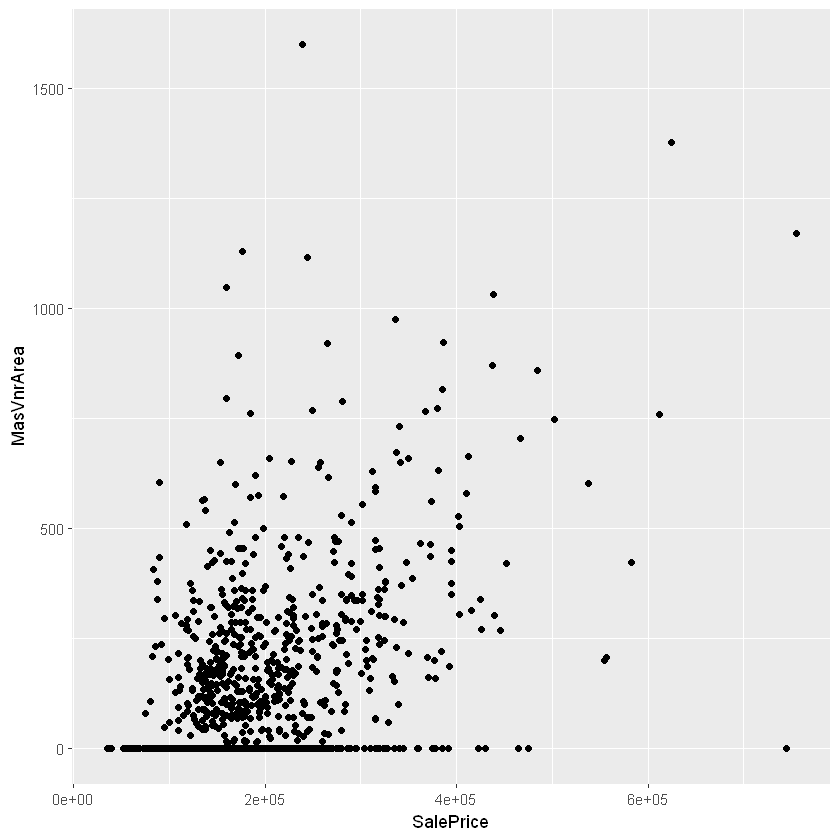

[1] 2.471537

[1] 0.5013397

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


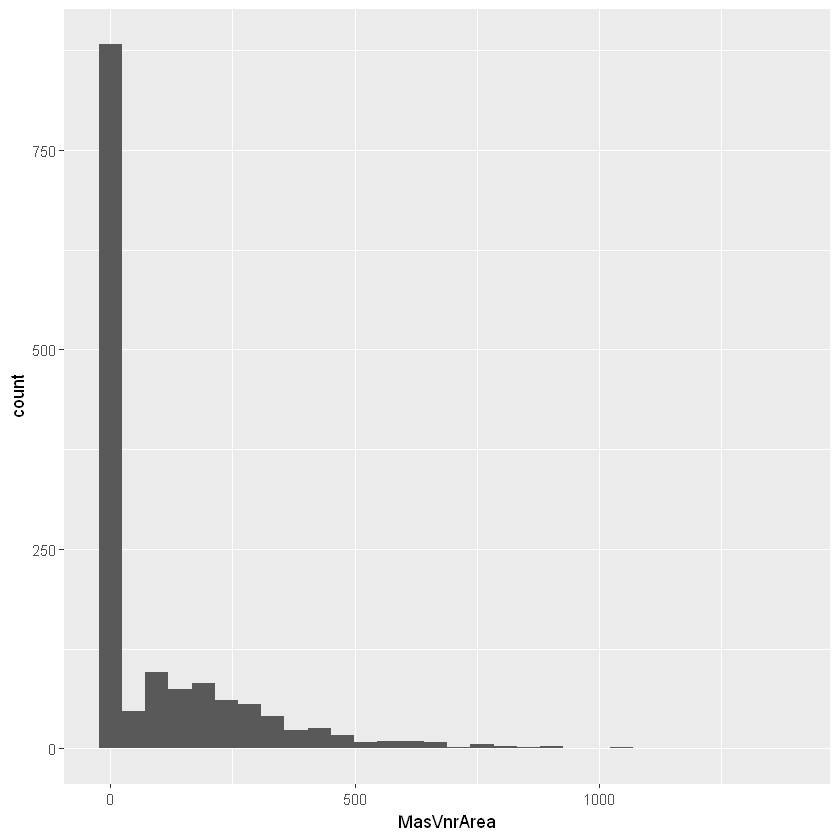

[1] 0

MasVnrType,MasVnrArea
<fct>,<int>
None,NA
None,NA
None,NA
None,NA
None,NA
None,NA
None,NA
None,NA
None,NA


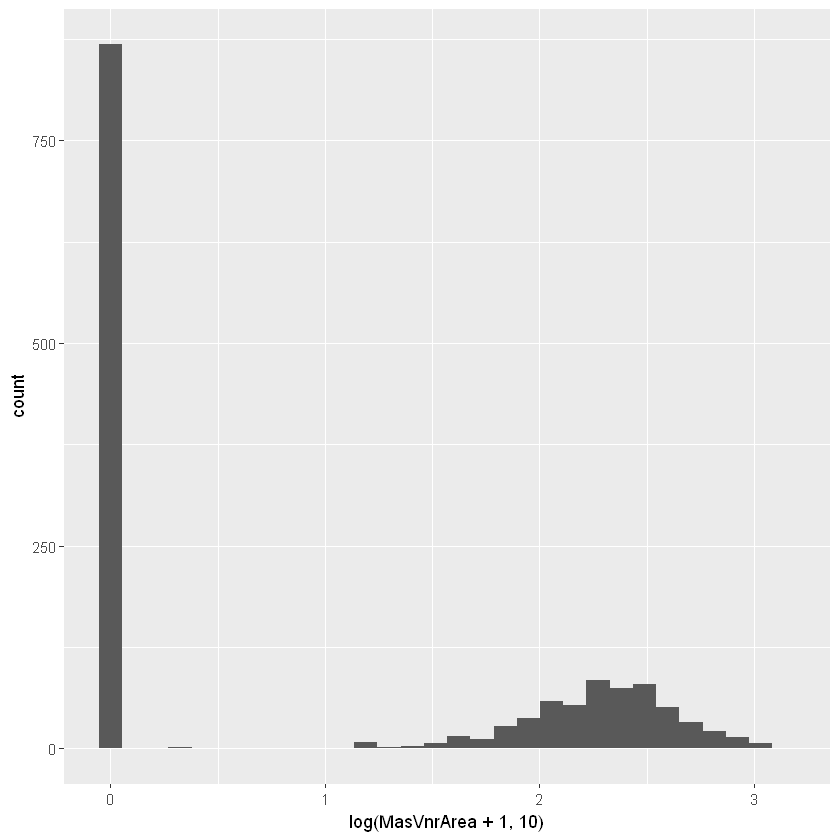

In [29]:
##COLUMN 27: MasVnrArea
sum(is.na(cleaned_train_data$MasVnrArea))
#8 missing values
#MasVnrArea and MasVnrType are related according to the description.
#Need to view the fields with missing values and decide what to do.
cleaned_train_data %>%
  select(MasVnrType, MasVnrArea) %>%
  filter(is.na(MasVnrArea))
#replace missing values with 0.
cleaned_train_data$MasVnrArea[is.na(cleaned_train_data$MasVnrArea)] <- 0
#outliers
ggplot(cleaned_train_data, aes(SalePrice, MasVnrArea)) + geom_point()
#Outliers seem to occur around 1500.
#Replace outliers with mean.
cleaned_train_data$MasVnrArea <- ifelse(cleaned_train_data$MasVnrArea > 1500, 
                                        mean(cleaned_train_data$MasVnrArea), 
                                        cleaned_train_data$MasVnrArea)
#Skewness
ggplot(cleaned_train_data, aes(MasVnrArea)) + geom_histogram()
skewness(cleaned_train_data$MasVnrArea)
skewness(log(cleaned_train_data$MasVnrArea +1, 10))
ggplot(cleaned_train_data, aes(log(MasVnrArea +1, 10)))+ geom_histogram()
#skewness has been greatly improved.
cleaned_train_data$MasVnrArea <- log(cleaned_train_data$MasVnrArea +1, 10)
#TEST DATA
sum(is.na(cleaned_train_data$MasVnrArea))
#8 missing values
cleaned_test_data %>%
  select(MasVnrType, MasVnrArea) %>%
  filter(is.na(MasVnrArea))
cleaned_test_data$MasVnrArea[is.na(cleaned_test_data$MasVnrArea)] <- 0
cleaned_test_data$MasVnrArea <- log(cleaned_test_data$MasVnrArea +1, 10)

In [30]:
##COLUMN 28: ExterQual
sum(is.na(cleaned_train_data$ExterQual))
summary(factor(cleaned_train_data$ExterQual))
#0 missing value or typo
cleaned_train_data$ExterQual <- factor(cleaned_train_data$ExterQual, order = TRUE, 
                                       levels = c("Po", "Fa", "TA", "Gd", "Ex"))
#TEST DATA
sum(is.na(cleaned_test_data$ExterQual))
summary(factor(cleaned_test_data$ExterQual))
#0 missing value or typo
cleaned_test_data$ExterQual <- factor(cleaned_test_data$ExterQual, order = TRUE, 
                                      levels = c("Po", "Fa", "TA", "Gd", "Ex"))

[1] 0

Ex  Fa  Gd  TA 
 52  14 488 906

[1] 0

Ex  Fa  Gd  TA 
 55  21 491 892

In [31]:
##COLUMN 29: ExterCond
sum(is.na(cleaned_train_data$ExterCond))
summary(factor(cleaned_train_data$ExterCond))
#0 missing value
cleaned_train_data$ExterCond <- ifelse(cleaned_train_data$ExterCond == "Po", "Fa",
                             cleaned_train_data$ExterCond)
cleaned_train_data$ExterCond <- factor(cleaned_train_data$ExterCond, order = TRUE, 
                                       levels = c("Fa", "TA", "Gd", "Ex"))
cleaned_train_data %>%
  group_by(ExterCond) %>%
  summarize(no_rows = length(ExterCond))
#TEST DATA
sum(is.na(cleaned_test_data$ExterCond))
summary(factor(cleaned_test_data$ExterCond))
#0 missing value
cleaned_test_data$ExterCond <- ifelse(cleaned_test_data$ExterCond == "Po", "Fa",
                                      cleaned_test_data$ExterCond)
cleaned_test_data$ExterCond <- factor(cleaned_test_data$ExterCond, order = TRUE, 
                                      levels = c("Fa", "TA", "Gd", "Ex"))
cleaned_test_data %>%
  group_by(ExterCond) %>%
  summarize(no_rows = length(ExterCond))

[1] 0

Ex   Fa   Gd   Po   TA 
   3   28  146    1 1282

ExterCond,no_rows
<ord>,<int>
Fa,29
TA,1282
Gd,146
Ex,3


[1] 0

Ex   Fa   Gd   Po   TA 
   9   39  153    2 1256

ExterCond,no_rows
<ord>,<int>
Fa,41
TA,1256
Gd,153
Ex,9


In [32]:
##COLUMN 30: Foundation
sum(is.na(cleaned_train_data$Foundation))
summary(factor(cleaned_train_data$Foundation))
#0 missing value
cleaned_train_data$Foundation <- as.factor(cleaned_train_data$Foundation)
#TEST DATA
sum(is.na(cleaned_test_data$Foundation))
summary(factor(cleaned_test_data$Foundation))
#0 missing value
cleaned_test_data$Foundation <- as.factor(cleaned_test_data$Foundation)


[1] 0

BrkTil CBlock  PConc   Slab  Stone   Wood 
   146    634    647     24      6      3

[1] 0

BrkTil CBlock  PConc   Slab  Stone   Wood 
   165    601    661     25      5      2

In [33]:
##COLUMN 31: BsmtQual
sum(is.na(cleaned_train_data$BsmtQual))
summary(factor(cleaned_train_data$BsmtQual))
#37 NAs but these NAs do not mean missing values. 
#They actually represent "No Basement" according to data description.
#Replace NA with "No Basement" to avoid confusion.
cleaned_train_data$BsmtQual[is.na(cleaned_train_data$BsmtQual)] <- "No Basement"
cleaned_train_data$BsmtQual <- factor(cleaned_train_data$BsmtQual, order = TRUE, 
                                      levels = c("No Basement","Po", "Fa", "TA", "Gd", "Ex"))
#TEST DATA
sum(is.na(cleaned_test_data$BsmtQual))
summary(factor(cleaned_test_data$BsmtQual))
cleaned_test_data$BsmtQual[is.na(cleaned_test_data$BsmtQual)] <- "No Basement"
cleaned_test_data$BsmtQual <- factor(cleaned_test_data$BsmtQual, order = TRUE, 
                                     levels = c("No Basement","Po", "Fa", "TA", "Gd", "Ex"))

[1] 37

Ex   Fa   Gd   TA NA's 
 121   35  618  649   37

[1] 44

Ex   Fa   Gd   TA NA's 
 137   53  591  634   44

In [34]:
##COLUMN 32: BsmtCond
sum(is.na(cleaned_train_data$BsmtCond))
summary(factor(cleaned_train_data$BsmtCond))
#37 NAs, similar to COLUMN 31, these NAs do not mean missing values. 
#They actually represent "No Basement" according to data description file.
#Replace NA with "No Basement" to avoid confusion.
cleaned_train_data$BsmtCond[is.na(cleaned_train_data$BsmtCond)] <- "No Basement"
cleaned_train_data$BsmtCond <- factor(cleaned_train_data$BsmtCond, order = TRUE, 
                                      levels = c("No Basement","Po", "Fa", "TA", "Gd", "Ex"))
#TEST DATA
sum(is.na(cleaned_test_data$BsmtCond))
summary(factor(cleaned_test_data$BsmtCond))
cleaned_test_data$BsmtCond[is.na(cleaned_test_data$BsmtCond)] <- "No Basement"
cleaned_test_data$BsmtCond <- factor(cleaned_test_data$BsmtCond, order = TRUE, 
                                     levels = c("No Basement","Po", "Fa", "TA", "Gd", "Ex"))

[1] 37

Fa   Gd   Po   TA NA's 
  45   65    2 1311   37

[1] 45

Fa   Gd   Po   TA NA's 
  59   57    3 1295   45

In [35]:
##COLUMN 33: BsmtExposure
sum(is.na(cleaned_train_data$BsmtExposure))
summary(factor(cleaned_train_data$BsmtExposure))
#38 NAs, they in fact represent "No Basement" rather than missing values.
#replace NA with "No Basement" to avoid confusion.
cleaned_train_data$BsmtExposure[is.na(cleaned_train_data$BsmtExposure)] <- "No Basement"
cleaned_train_data$BsmtExposure <- factor(cleaned_train_data$BsmtExposure, order = TRUE, 
                                          levels = c("No Basement","No", "Mn", "Av", "Gd"))
#TEST DATA
sum(is.na(cleaned_test_data$BsmtExposure))
summary(factor(cleaned_test_data$BsmtExposure))
cleaned_test_data$BsmtExposure[is.na(cleaned_test_data$BsmtExposure)] <- "No Basement"
cleaned_test_data$BsmtExposure <- factor(cleaned_test_data$BsmtExposure, order = TRUE, 
                                         levels = c("No Basement","No", "Mn", "Av", "Gd"))

[1] 38

Av   Gd   Mn   No NA's 
 221  134  114  953   38

[1] 44

Av   Gd   Mn   No NA's 
 197  142  125  951   44

In [36]:
##COLUMN 34:BsmtFinType1
sum(is.na(cleaned_train_data$BsmtFinType1))
summary(factor(cleaned_train_data$BsmtFinType1))
#37 NA but they mean "No Basement" rather than missing values.
#To avoid confusion, replace NA with "No Basement".
cleaned_train_data$BsmtFinType1[is.na(cleaned_train_data$BsmtFinType1)] <- "No Basement"
cleaned_train_data$BsmtFinType1 <- factor(cleaned_train_data$BsmtFinType1, order = TRUE, 
                                          levels = c("No Basement","Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"))
#TEST DATA
sum(is.na(cleaned_test_data$BsmtFinType1))
summary(factor(cleaned_test_data$BsmtFinType1))
cleaned_test_data$BsmtFinType1[is.na(cleaned_test_data$BsmtFinType1)] <- "No Basement"
cleaned_test_data$BsmtFinType1 <- factor(cleaned_test_data$BsmtFinType1, order = TRUE, 
                                         levels = c("No Basement","Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"))

[1] 37

ALQ  BLQ  GLQ  LwQ  Rec  Unf NA's 
 220  148  418   74  133  430   37

[1] 42

ALQ  BLQ  GLQ  LwQ  Rec  Unf NA's 
 209  121  431   80  155  421   42

[1] 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


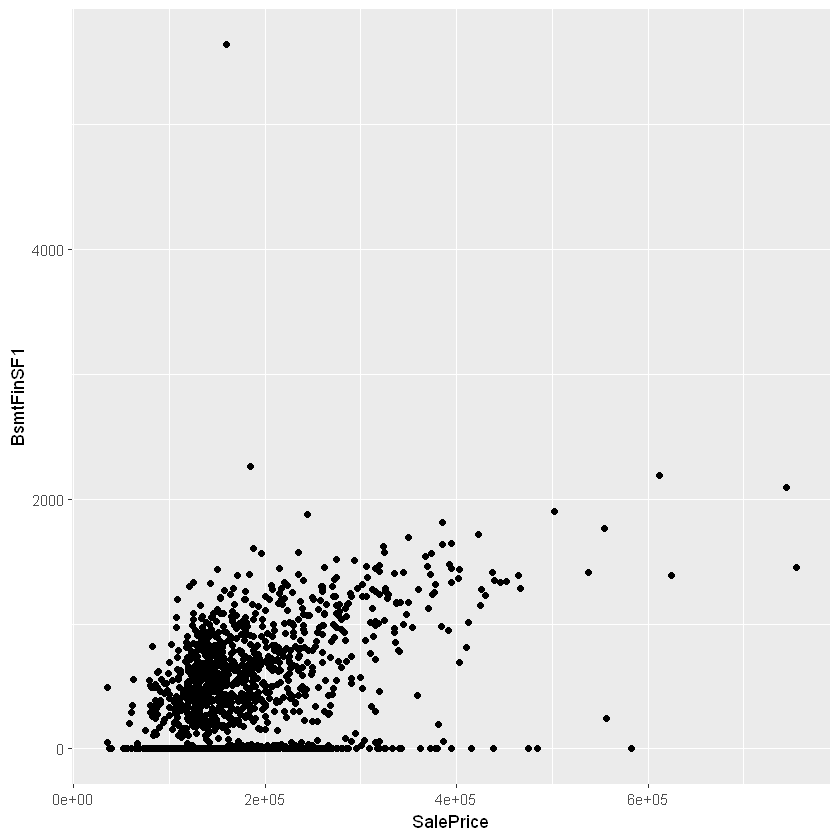

[1] 0.7185539

[1] 1

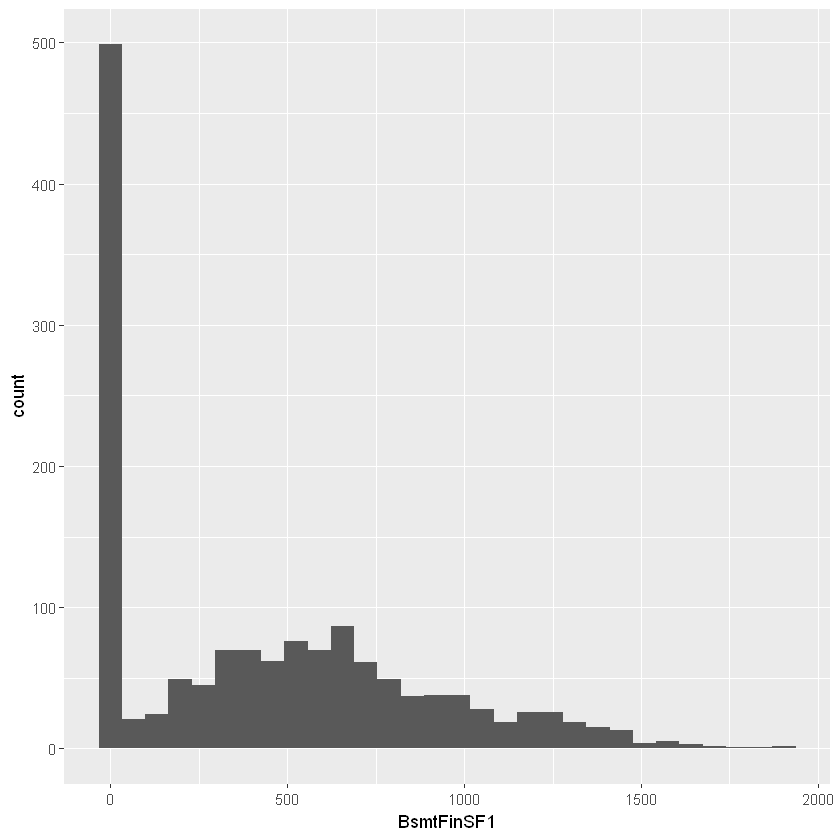

In [37]:
##COLUMN 35:BsmtFinSF1
cleaned_train_data$BsmtFinSF1 <- as.numeric(cleaned_train_data$BsmtFinSF1)
sum(is.na(cleaned_train_data$BsmtFinSF1))
#No missing value
#Outliers
ggplot(data = cleaned_train_data, aes(SalePrice , BsmtFinSF1)) + geom_point()
#Outliers seem to be around 2000.
#Replace outliers with mean.
cleaned_train_data$BsmtFinSF1 <- ifelse(cleaned_train_data$BsmtFinSF1 > 2000, 
                                        mean(cleaned_train_data$BsmtFinSF1),
                                        cleaned_train_data$BsmtFinSF1)
#Check skewness 
ggplot(data = cleaned_train_data, aes(BsmtFinSF1)) + geom_histogram()
skewness(cleaned_train_data$BsmtFinSF1)
#The value is 0.718, moderately skewed.
#TEST DATA
cleaned_test_data$BsmtFinSF1 <- as.numeric(cleaned_test_data$BsmtFinSF1)
sum(is.na(cleaned_test_data$BsmtFinSF1))
#One NA value, so ill replace it with the mean
meanOfBsmtFinSF1 <- mean(ifelse(is.na(cleaned_test_data$BsmtFinSF1) == TRUE, 0, cleaned_test_data$BsmtFinSF1))
cleaned_test_data$BsmtFinSF1 <- ifelse(is.na(cleaned_test_data$BsmtFinSF1) == TRUE, 
                                       meanOfBsmtFinSF1, cleaned_test_data$BsmtFinSF1)

In [38]:
##COLUMN 36: BsmtFinType2
sum(is.na(cleaned_train_data$BsmtFinType2))
summary(factor(cleaned_train_data$BsmtFinType2))
#38 NAs but they mean "No Basement" not missing values.
#Replace NAs with "No Basement" to avoid confusion.
cleaned_train_data$BsmtFinType2[is.na(cleaned_train_data$BsmtFinType2)] <- "No Basement"
cleaned_train_data$BsmtFinType2 <- factor(cleaned_train_data$BsmtFinType2, order = TRUE, 
                                          levels = c("No Basement","Unf","LwQ","Rec","BLQ","ALQ","GLQ"))
#TEST DATA
sum(is.na(cleaned_test_data$BsmtFinType2))
summary(factor(cleaned_test_data$BsmtFinType2))
cleaned_test_data$BsmtFinType2[is.na(cleaned_test_data$BsmtFinType2)] <- "No Basement"
cleaned_test_data$BsmtFinType2 <- factor(cleaned_test_data$BsmtFinType2, order = TRUE, 
                                         levels = c("No Basement","Unf","LwQ","Rec","BLQ","ALQ","GLQ"))


[1] 38

ALQ  BLQ  GLQ  LwQ  Rec  Unf NA's 
  19   33   14   46   54 1256   38

[1] 42

ALQ  BLQ  GLQ  LwQ  Rec  Unf NA's 
  33   35   20   41   51 1237   42

[1] 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


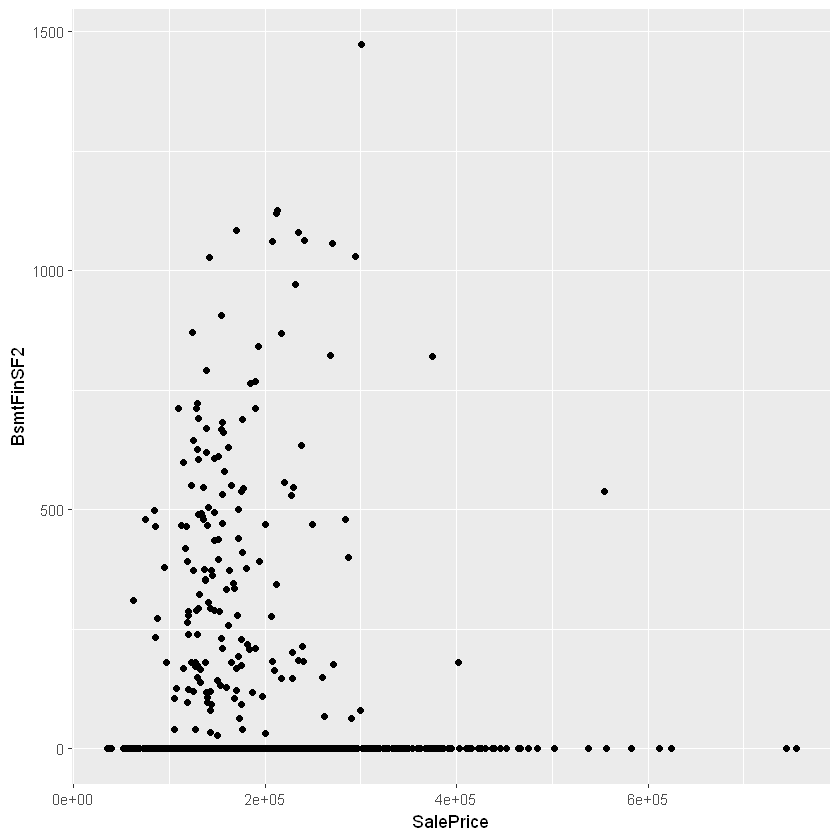

[1] 4.116263

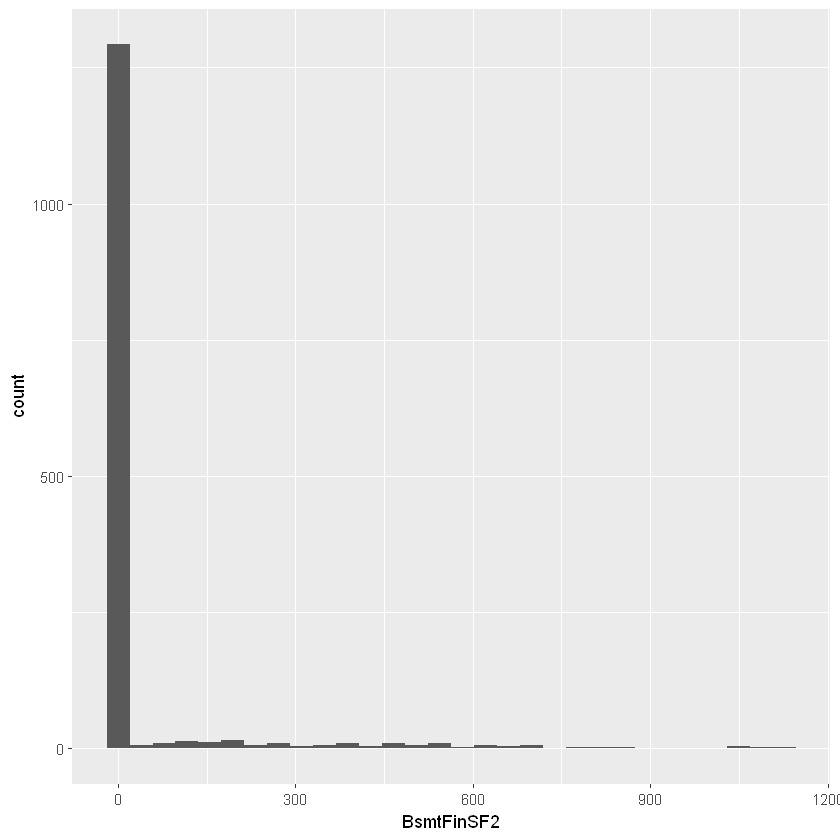

In [39]:
##COLUMN 37: BsmtFinSF2
cleaned_train_data$BsmtFinSF2 <- as.numeric(cleaned_train_data$BsmtFinSF2)
sum(is.na(cleaned_train_data$BsmtFinSF2))
#No missing value
#Outliers
ggplot(data = cleaned_train_data, aes(SalePrice, BsmtFinSF2)) + geom_point()
#Outliers seem to be around 1250.
#Replace outliers with mean.
cleaned_train_data$BsmtFinSF2 <- ifelse(cleaned_train_data$BsmtFinSF2 > 1250, 
                                        mean(cleaned_train_data$BsmtFinSF2),
                                        cleaned_train_data$BsmtFinSF2)

#Check skewness 
ggplot(data = cleaned_train_data, aes(BsmtFinSF2)) + geom_histogram()
skewness(cleaned_train_data$BsmtFinSF2)
#BsmtFinSF2 should be considered for removal.

[1] 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


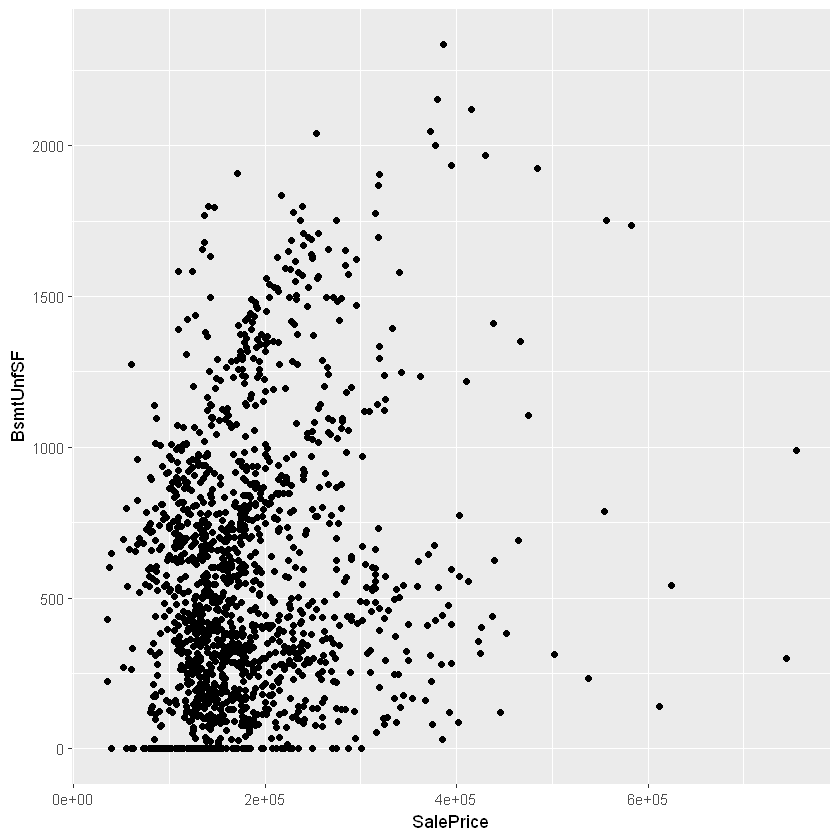

[1] 0.9183784

[1] 1

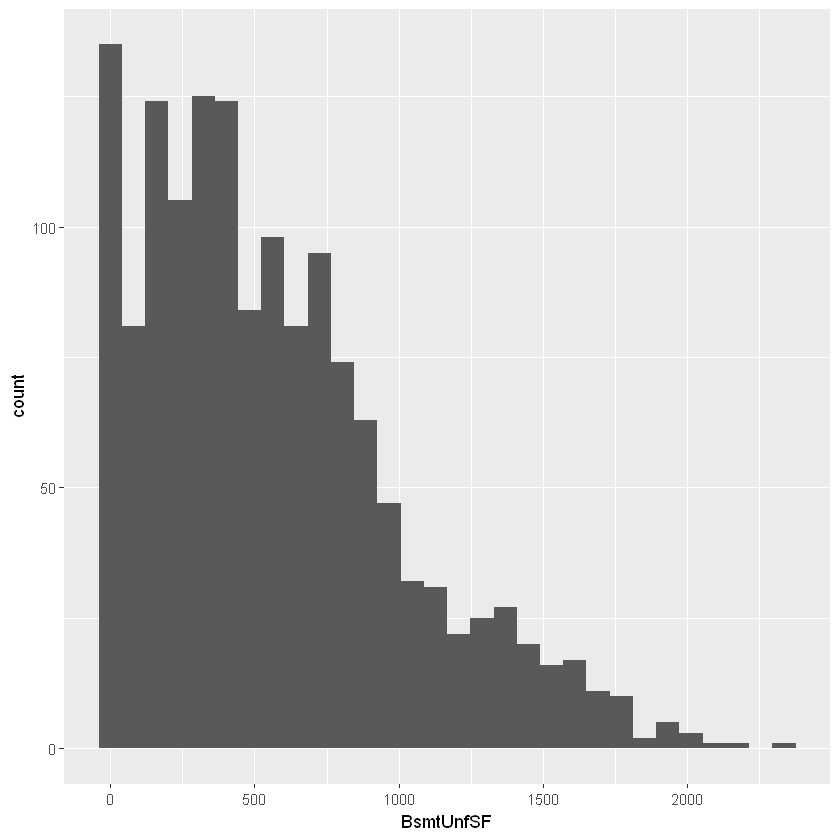

In [40]:
##COLUMN 38: BsmtUnfSF
cleaned_train_data$BsmtUnfSF <- as.numeric(cleaned_train_data$BsmtUnfSF)
sum(is.na(cleaned_train_data$BsmtUnfSF))
#No missing value
#Outliers
ggplot(data = cleaned_train_data, aes(SalePrice, BsmtUnfSF)) + geom_point()
#I don't see obvious outliers.
#Check skewness 
ggplot(data = cleaned_train_data, aes(BsmtUnfSF)) + geom_histogram()
skewness(cleaned_train_data$BsmtUnfSF)
#The value is 0.918, moderately skewed.
#TEST DATA
cleaned_test_data$BsmtUnfSF <- as.numeric(cleaned_test_data$BsmtUnfSF)
sum(is.na(cleaned_test_data$BsmtUnfSF))
#There is one missing value which I will replace with the mean
meanOfBsmtUnfSF <- mean(ifelse(is.na(cleaned_test_data$BsmtUnfSF) == TRUE, 0, cleaned_test_data$BsmtUnfSF))
cleaned_test_data$BsmtUnfSF <- ifelse(is.na(cleaned_test_data$BsmtUnfSF) == TRUE, 
                                      meanOfBsmtUnfSF, cleaned_test_data$BsmtUnfSF)

[1] 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


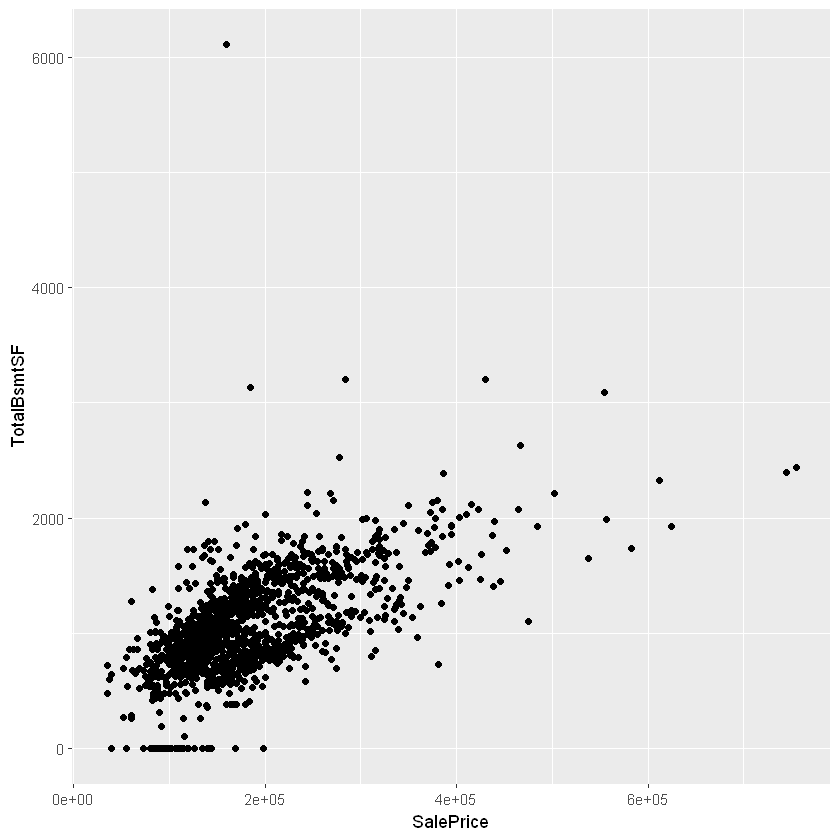

[1] 0.5726375

[1] 1

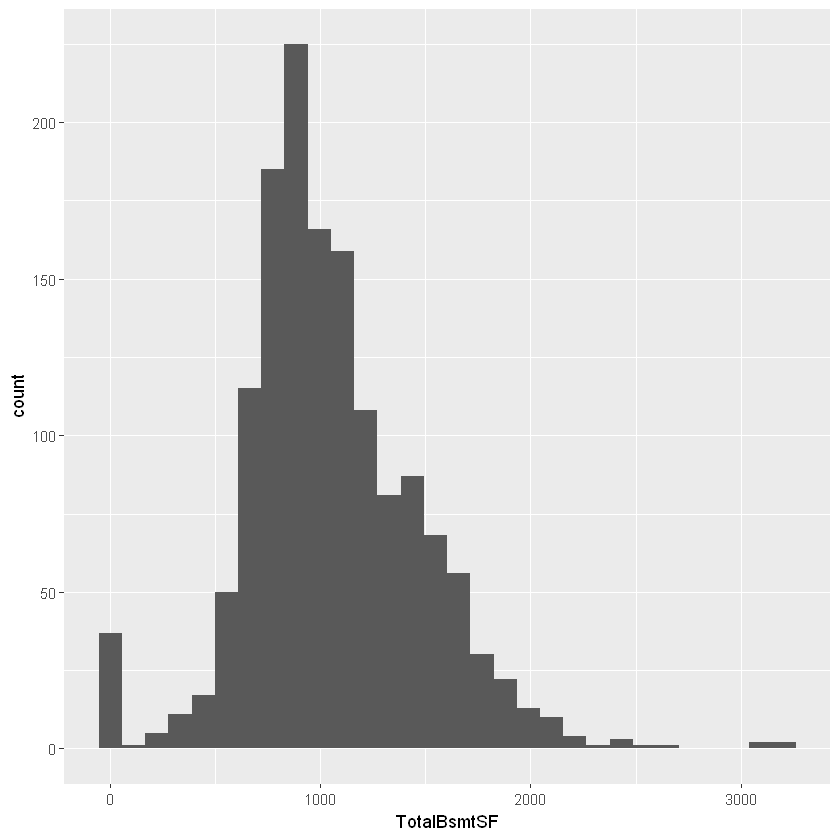

In [41]:
##COLUMN 39: TotalBsmtSF
cleaned_train_data$TotalBsmtSF <- as.numeric(cleaned_train_data$TotalBsmtSF)
sum(is.na(cleaned_train_data$TotalBsmtSF))
#No missing value
#Outliers
ggplot(data = cleaned_train_data, aes(SalePrice, TotalBsmtSF)) + geom_point()
#Outliers seem to be around 6000.
#Replace outliers with mean.
cleaned_train_data$TotalBsmtSF <- ifelse(cleaned_train_data$TotalBsmtSF > 6000,
                                         mean(cleaned_train_data$TotalBsmtSF),
                                         cleaned_train_data$TotalBsmtSF)
#Skewness 
ggplot(data = cleaned_train_data, aes(x = TotalBsmtSF)) + geom_histogram()
skewness(cleaned_train_data$TotalBsmtSF)
#The value is 0.573, moderately skewed.
#TEST DATA
cleaned_test_data$TotalBsmtSF <- as.numeric(cleaned_test_data$TotalBsmtSF)
sum(is.na(cleaned_test_data$TotalBsmtSF))
#One missing value which I will replace with the mean 
meanOfTotalBsmtSF <- mean(ifelse(is.na(cleaned_test_data$TotalBsmtSF) == TRUE, 0, cleaned_test_data$TotalBsmtSF))
cleaned_test_data$TotalBsmtSF <- ifelse(is.na(cleaned_test_data$TotalBsmtSF) == TRUE, 
                                        meanOfTotalBsmtSF, cleaned_test_data$TotalBsmtSF)

In [42]:
##COLUMN 40: Heating
sum(is.na(cleaned_train_data$Heating))
summary(factor(cleaned_train_data$Heating))
#No missing value or typo
#1428 out of 1460 cases belong to the GasA category.
#Heating should be removed because it won't
#provide much useful information in the modeling stage.
cleaned_train_data$Heating <- as.factor(cleaned_train_data$Heating)

[1] 0

Floor  GasA  GasW  Grav  OthW  Wall 
    1  1428    18     7     2     4

In [43]:
##COLUMN 41: HeatingQC
sum(is.na(cleaned_train_data$HeatingQC))
summary(factor(cleaned_train_data$HeatingQC))
cleaned_train_data %>%
  group_by(HeatingQC) %>%
  summarize(no_row = length(HeatingQC))
#No missing value or typo
#The single Po is a point with leverage = 1, so ill change it to Fa
cleaned_train_data$HeatingQC <- ifelse(cleaned_train_data$HeatingQC == "Po", "Fa",
                                       cleaned_train_data$HeatingQC)
cleaned_train_data$HeatingQC <- factor(cleaned_train_data$HeatingQC, order = TRUE, 
                                       levels = c("Po", "Fa", "TA", "Gd", "Ex"))
#TEST DATA
sum(is.na(cleaned_test_data$HeatingQC))
summary(factor(cleaned_test_data$HeatingQC))
cleaned_test_data %>%
  group_by(HeatingQC) %>%
  summarize(no_row = length(HeatingQC))
cleaned_test_data$HeatingQC <- ifelse(cleaned_test_data$HeatingQC == "Po", "Fa",
                                      cleaned_test_data$HeatingQC)
cleaned_test_data$HeatingQC <- factor(cleaned_test_data$HeatingQC, order = TRUE, 
                                      levels = c("Po", "Fa", "TA", "Gd", "Ex"))


[1] 0

Ex  Fa  Gd  Po  TA 
741  49 241   1 428

HeatingQC,no_row
<chr>,<int>
Ex,741
Fa,49
Gd,241
Po,1
TA,428


[1] 0

Ex  Fa  Gd  Po  TA 
752  43 233   2 429

HeatingQC,no_row
<chr>,<int>
Ex,752
Fa,43
Gd,233
Po,2
TA,429


In [44]:
##COLUMN 42: CentralAir
sum(is.na(cleaned_train_data$CentralAir))
#No missing value
cleaned_train_data$CentralAir <- as.factor(cleaned_train_data$CentralAir)
summary(cleaned_train_data$CentralAir)
#TEST DATA
sum(is.na(cleaned_test_data$CentralAir))
cleaned_test_data$CentralAir <- as.factor(cleaned_test_data$CentralAir)
summary(cleaned_test_data$CentralAir)


[1] 0

N    Y 
  95 1365

[1] 0

N    Y 
 101 1358

In [45]:
##COLUMN 43: Electrical
sum(is.na(cleaned_train_data$Electrical))
summary(factor(cleaned_train_data$Electrical))
#1 missing value
#Replace the NA with SBrkr which appears the most.
cleaned_train_data$Electrical[is.na(cleaned_train_data$Electrical)] <- "SBrkr"
cleaned_train_data$Electrical <- as.factor(cleaned_train_data$Electrical)
#TEST DATA
sum(is.na(cleaned_test_data$Electrical))
summary(factor(cleaned_test_data$Electrical))
#No missing values

[1] 1

FuseA FuseF FuseP   Mix SBrkr  NA's 
   94    27     3     1  1334     1

[1] 0

FuseA FuseF FuseP SBrkr 
   94    23     5  1337

[1] 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


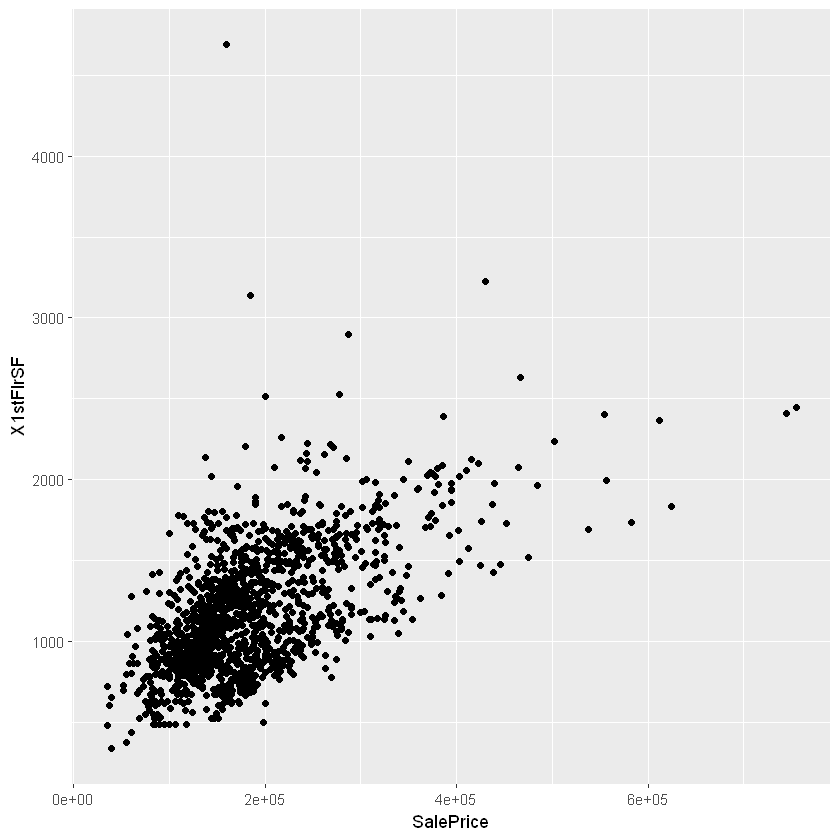

[1] 0.8049861

[1] 0

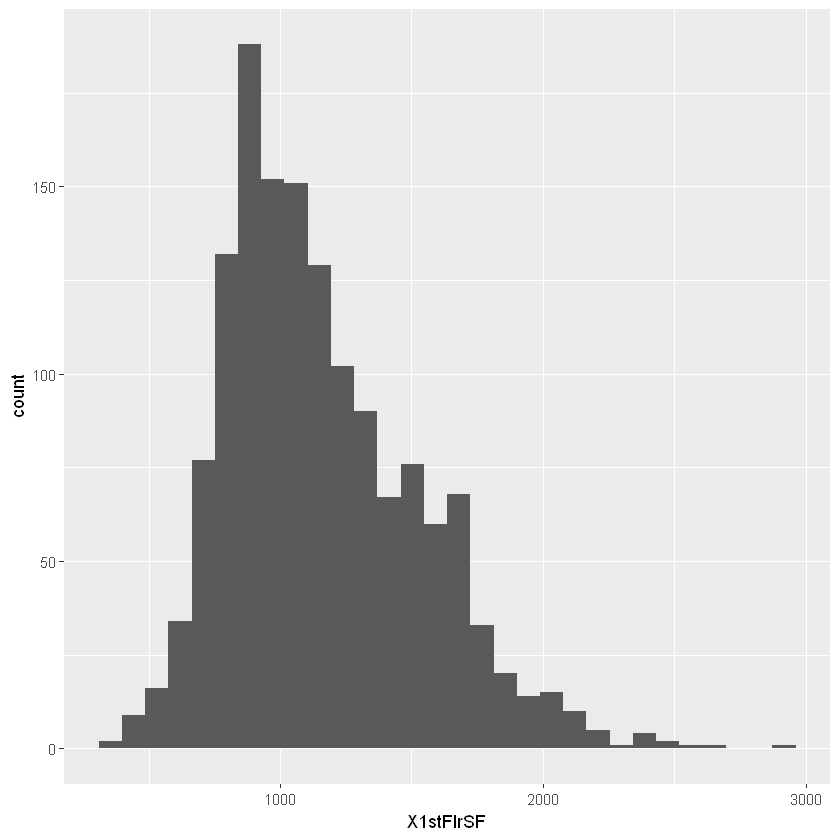

In [46]:
##COLUMN 44: X1stFlrSF
cleaned_train_data$X1stFlrSF <- as.numeric(cleaned_train_data$X1stFlrSF)
sum(is.na(cleaned_train_data$X1stFlrSF))
#no missing value
#Outliers
ggplot(data = cleaned_train_data, aes(SalePrice, X1stFlrSF)) + geom_point()
#Outliers seem to be around 3000.
#Replace outliers with mean.
cleaned_train_data$X1stFlrSF <- ifelse(cleaned_train_data$X1stFlrSF > 3000,
                                       mean(cleaned_train_data$X1stFlrSF),
                                       cleaned_train_data$X1stFlrSF)
#Skewness 
ggplot(data = cleaned_train_data, aes(x = X1stFlrSF)) + geom_histogram()
skewness(cleaned_train_data$X1stFlrSF)
#The value is 0.805, moderately skewed.
#TEST DATA
cleaned_test_data$X1stFlrSF <- as.numeric(cleaned_test_data$X1stFlrSF)
sum(is.na(cleaned_test_data$X1stFlrSF))

[1] 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


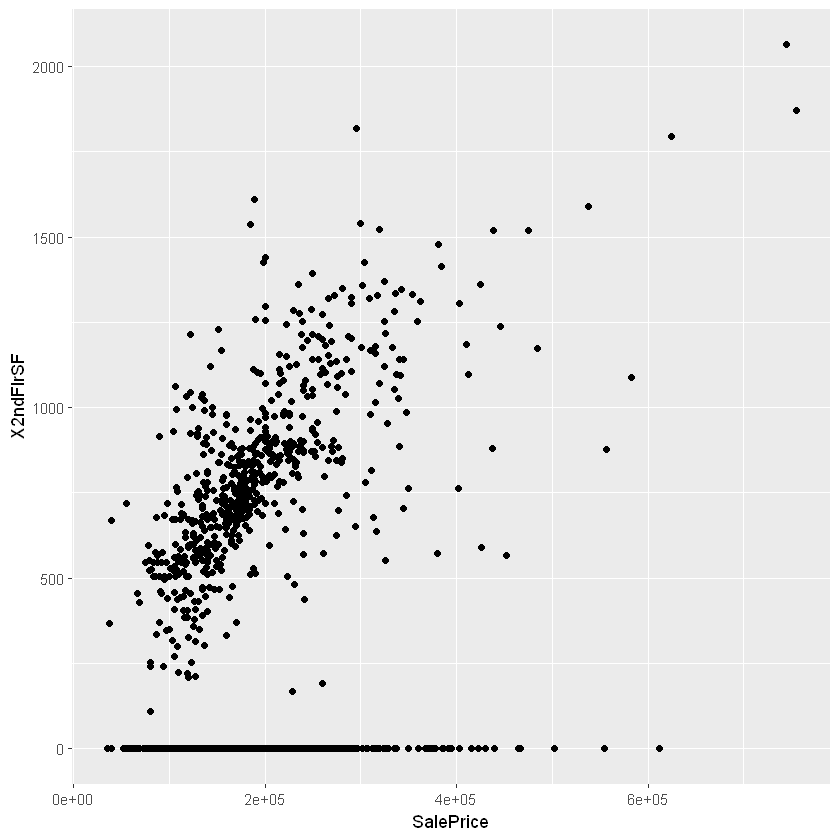

[1] 0.7901607

[1] 0

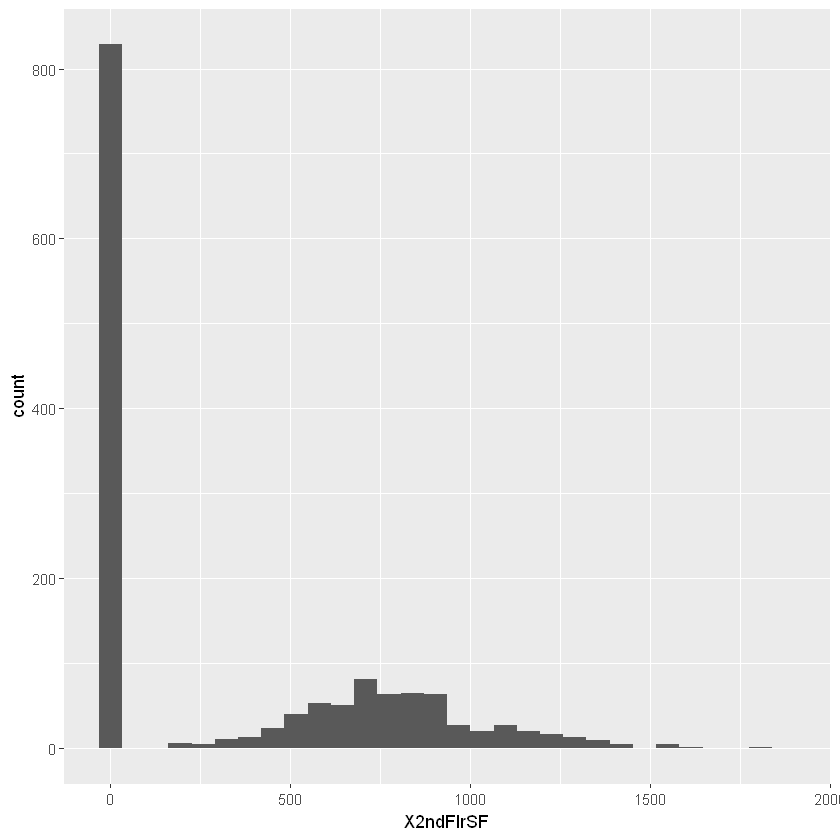

In [47]:
##COLUMN 45: X2ndFlrSF
cleaned_train_data$X2ndFlrSF <- as.numeric(cleaned_train_data$X2ndFlrSF)
sum(is.na(cleaned_train_data$X2ndFlrSF))
#no missing value
#Outliers
ggplot(data = cleaned_train_data, aes(SalePrice, X2ndFlrSF)) + geom_point()
#Outliers seem to be around 2000.
#Replace outliers with mean.
cleaned_train_data$X2ndFlrSF <- ifelse(cleaned_train_data$X2ndFlrSF > 2000,
                                       mean(cleaned_train_data$X2ndFlrSF),
                                       cleaned_train_data$X2ndFlrSF)
#Skewness 
ggplot(data = cleaned_train_data, aes(x = X2ndFlrSF)) + geom_histogram()
skewness(cleaned_train_data$X2ndFlrSF)
#The value is 0.79, moderately skewed.
#TEST DATA
cleaned_test_data$X2ndFlrSF <- as.numeric(cleaned_test_data$X2ndFlrSF)
sum(is.na(cleaned_test_data$X2ndFlrSF))

[1] 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


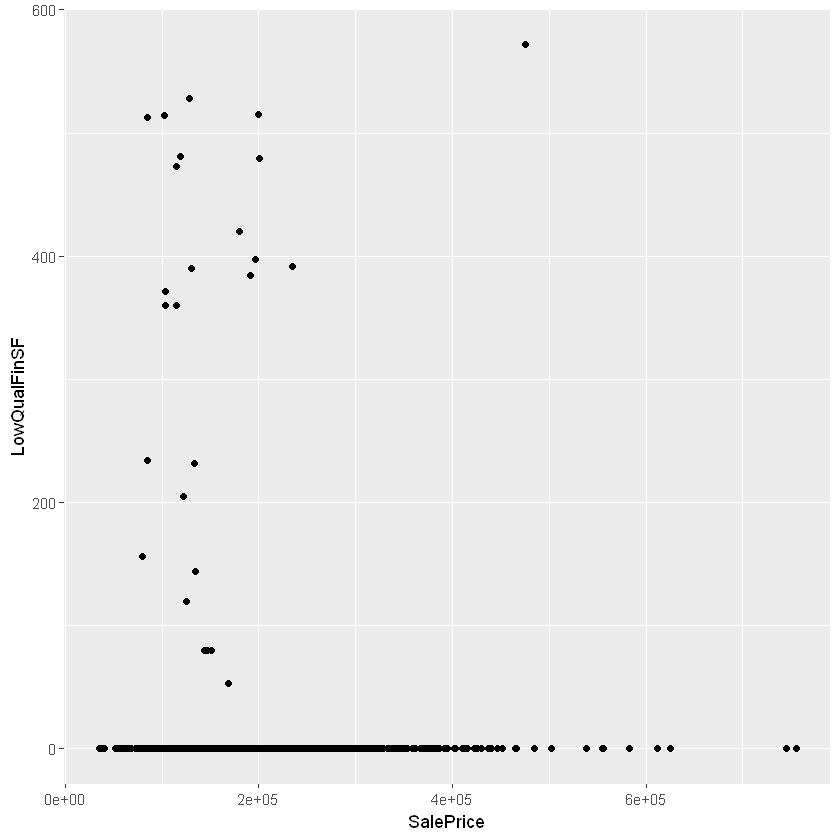

[1] 8.992833

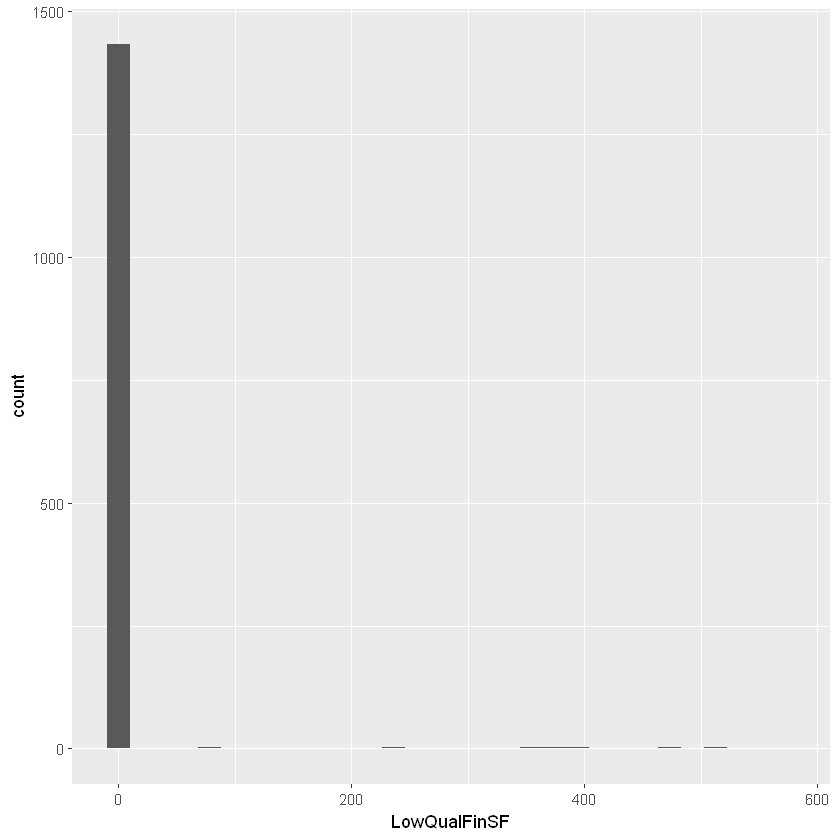

In [48]:
##COLUMN 46: LowQualFinSF
cleaned_train_data$LowQualFinSF <- as.numeric(cleaned_train_data$LowQualFinSF)
sum(is.na(cleaned_train_data$LowQualFinSF))
#no missing value
#Outliers
ggplot(data = cleaned_train_data, aes(SalePrice, LowQualFinSF)) + geom_point()
#May consider removing this variable in the modeling stage.
#Skewness 
ggplot(data = cleaned_train_data, aes(x = LowQualFinSF)) + geom_histogram()
skewness(cleaned_train_data$LowQualFinSF)
#The value is 8.99, highly skewed.

[1] 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


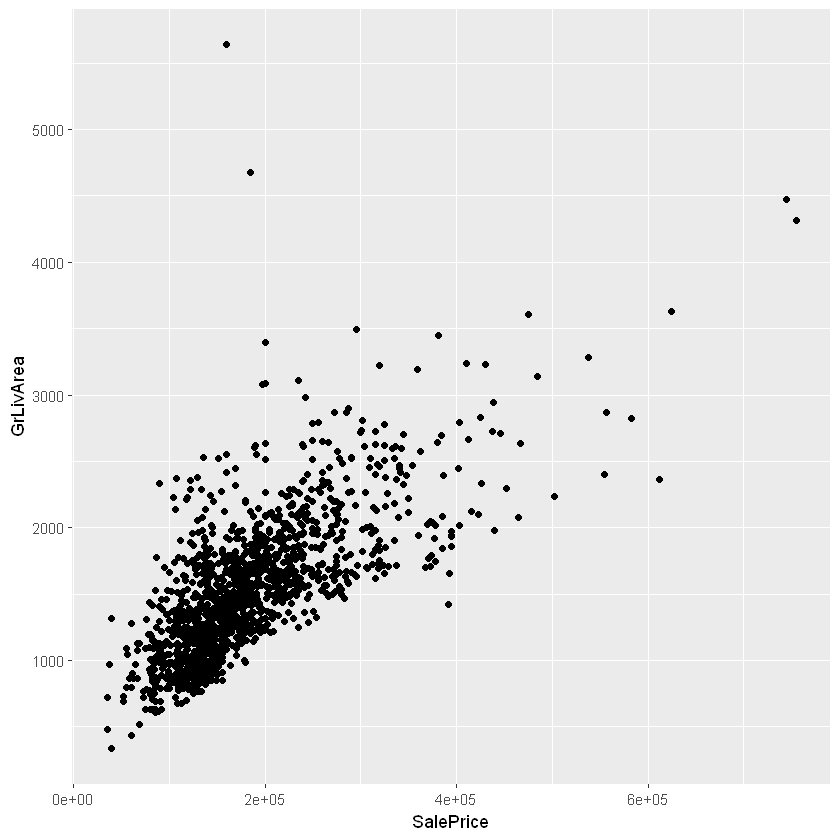

[1] 0.8344693

[1] 0

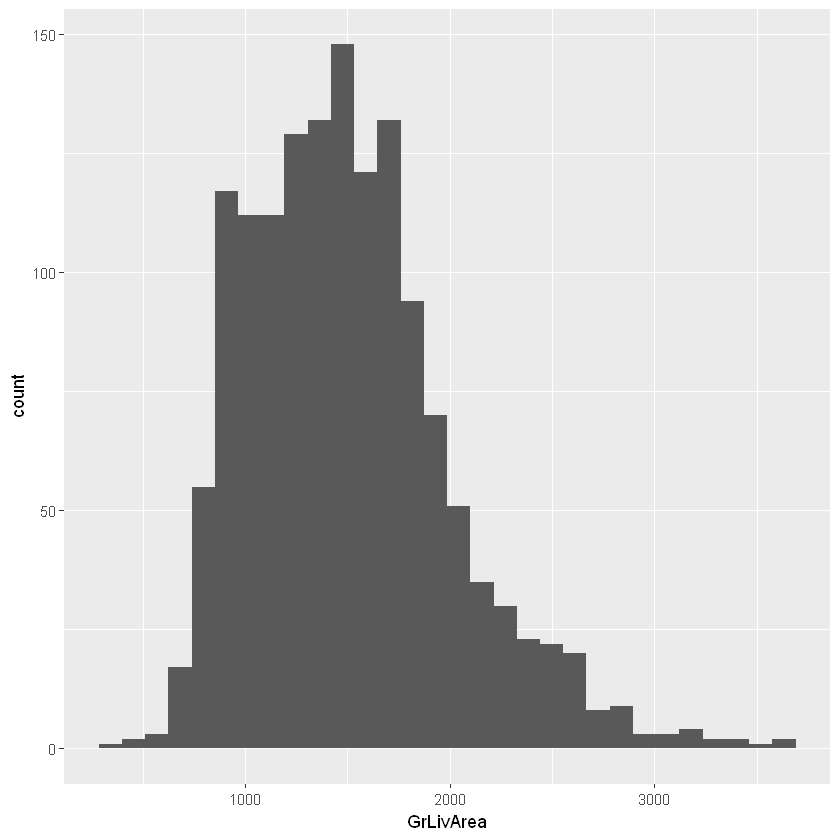

In [49]:
##COLUMN 47: GrLivArea
cleaned_train_data$GrLivArea <- as.numeric(cleaned_train_data$GrLivArea)
sum(is.na(cleaned_train_data$GrLivArea))
#no missing value
#Outliers
ggplot(data = cleaned_train_data, aes(SalePrice, GrLivArea)) + geom_point()
#Outliers seem to be around 4000.
#Replace outliers with mean.
cleaned_train_data$GrLivArea <- ifelse(cleaned_train_data$GrLivArea > 4000,
                                       mean(cleaned_train_data$GrLivArea),
                                       cleaned_train_data$GrLivArea)
#Skewness 
ggplot(data = cleaned_train_data, aes(x = GrLivArea)) + geom_histogram()
skewness(cleaned_train_data$GrLivArea)
#The value is 0.83, moderately skewed.
#TEST DATA
cleaned_test_data$GrLivArea <- as.numeric(cleaned_test_data$GrLivArea)
sum(is.na(cleaned_test_data$GrLivArea))


[1] 0

0   1   2   3 
856 588  15   1

[1] 0.5948424

[1] 2

0    1    2    3 NA's 
 849  584   23    1    2

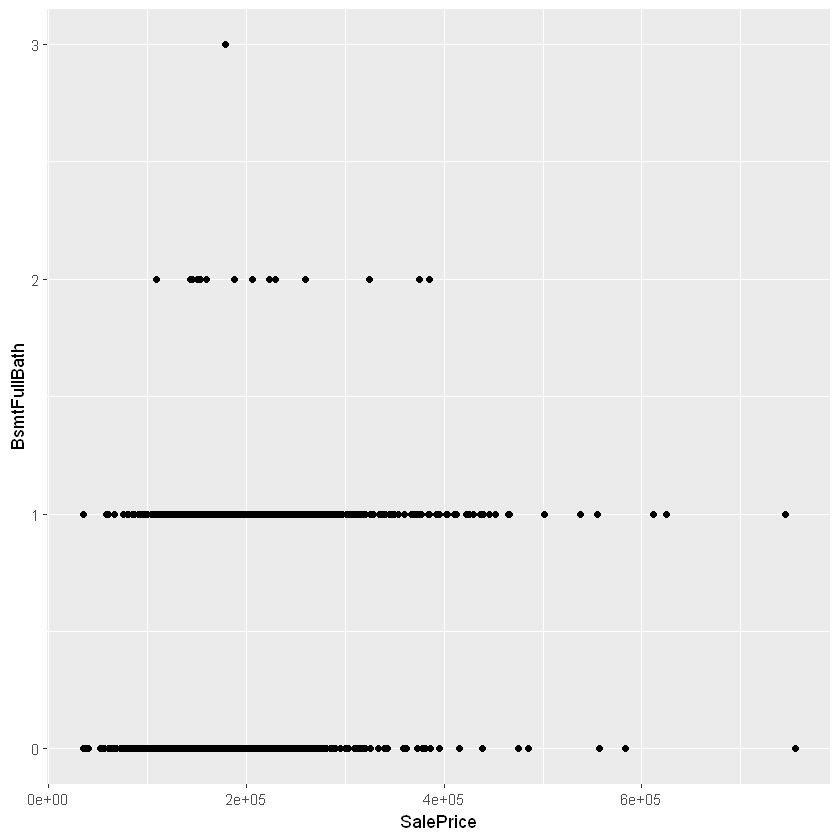

In [50]:
##COLUMN 48: BsmtFullBath
cleaned_train_data$BsmtFullBath <- as.numeric(cleaned_train_data$BsmtFullBath)
sum(is.na(cleaned_train_data$BsmtFullBath))
summary(factor(cleaned_train_data$BsmtFullBath))
#no missing value
#Outliers
ggplot(data = cleaned_train_data, aes(SalePrice, BsmtFullBath)) + geom_point()
#I don't see obvious outliers.
skewness(cleaned_train_data$BsmtFullBath)
#The value is 0.5948, moderately skewed.
#TEST DATA
cleaned_test_data$BsmtFullBath <- as.numeric(cleaned_test_data$BsmtFullBath)
sum(is.na(cleaned_test_data$BsmtFullBath))
summary(factor(cleaned_test_data$BsmtFullBath))
#Two NA values which I will replace with the most common which is 0
cleaned_test_data$BsmtFullBath <- ifelse(is.na(cleaned_test_data$BsmtFullBath)==TRUE,
                                         0, cleaned_test_data$BsmtFullBath)


[1] 0

0    1    2 
1378   80    2

[1] 4.094975

[1] 2

0    1    2 NA's 
1364   91    2    2

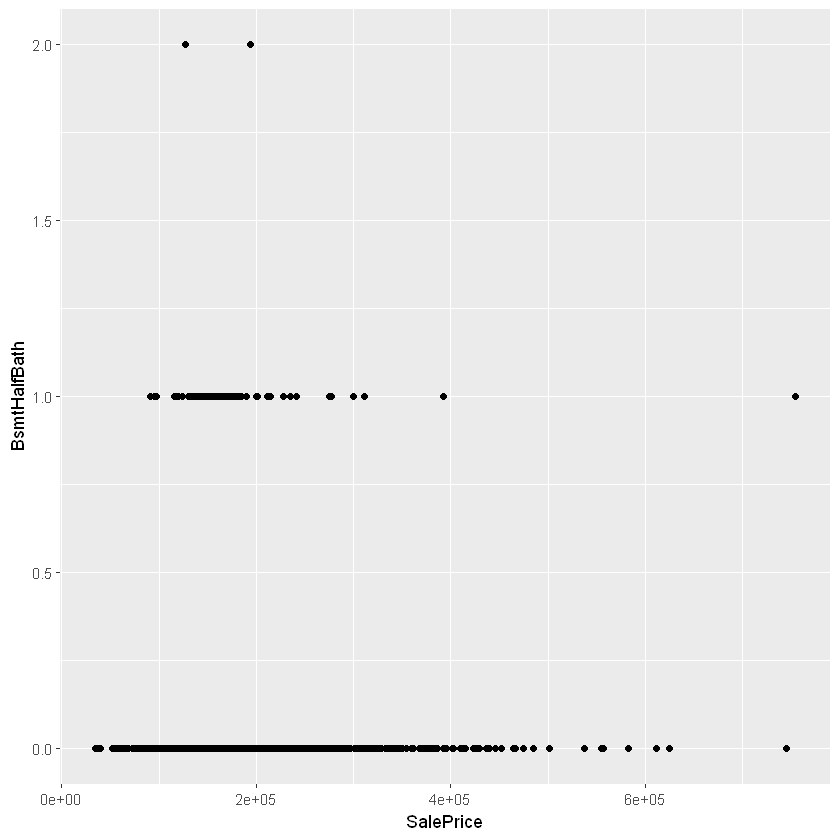

In [51]:
##COLUMN 49: BsmtHalfBath
cleaned_train_data$BsmtHalfBath <- as.numeric(cleaned_train_data$BsmtHalfBath)
sum(is.na(cleaned_train_data$BsmtHalfBath))
summary(factor(cleaned_train_data$BsmtHalfBath))
#no missing value
#Outliers
ggplot(data = cleaned_train_data, aes(SalePrice, BsmtHalfBath)) + geom_point()
#No obvious outliers.
skewness(cleaned_train_data$BsmtHalfBath)
#The value is 4.095, highly skewed.
#I am not going to try any tranformation because
#later I will combine BsmtHalfBath with HalfBath to create a new variable.
#TEST DATA
cleaned_test_data$BsmtHalfBath <- as.numeric(cleaned_test_data$BsmtHalfBath)
sum(is.na(cleaned_test_data$BsmtHalfBath))
summary(factor(cleaned_test_data$BsmtHalfBath))
#Two NA values which I will replace with the most common which is 0
cleaned_test_data$BsmtHalfBath <- ifelse(is.na(cleaned_test_data$BsmtHalfBath)==TRUE,
                                         0, cleaned_test_data$BsmtHalfBath)

[1] 0

0   1   2   3 
  9 650 768  33

[1] 0.03648647

[1] 0

0   1   2   3   4 
  3 659 762  31   4

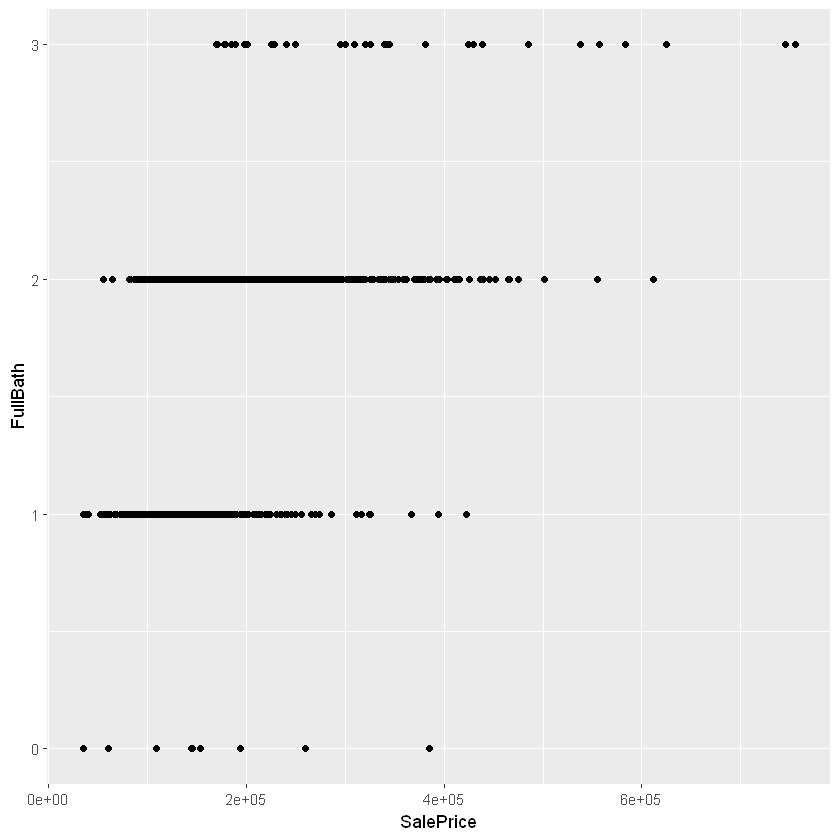

In [52]:
##COLUMN 50: FullBath
cleaned_train_data$FullBath <- as.numeric(cleaned_train_data$FullBath)
sum(is.na(cleaned_train_data$FullBath))
summary(factor(cleaned_train_data$FullBath))
#no missing value
#Outliers
ggplot(data = cleaned_train_data, aes(SalePrice, FullBath)) + geom_point()
#No obvious outliers.
skewness(cleaned_train_data$FullBath)
#The value is 0.036, approximately symmetrical.
#TEST DATA
cleaned_test_data$FullBath <- as.numeric(cleaned_test_data$FullBath)
sum(is.na(cleaned_test_data$FullBath))
summary(factor(cleaned_test_data$FullBath))


[1] 0

0   1   2 
913 535  12

[1] 0.6745093

[1] 0

0   1   2 
921 525  13

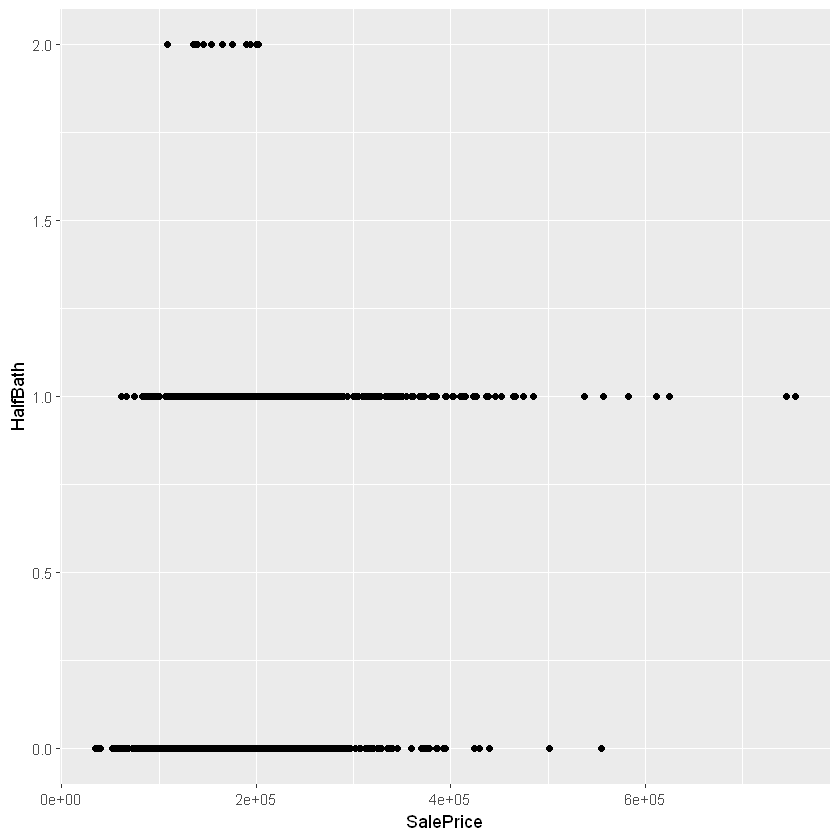

In [53]:
##COLUMN 51: HalfBath
cleaned_train_data$HalfBath <- as.numeric(cleaned_train_data$HalfBath)
sum(is.na(cleaned_train_data$HalfBath))
summary(factor(cleaned_train_data$HalfBath))
#no missing value
#Outliers
ggplot(data = cleaned_train_data, aes(SalePrice, HalfBath)) + geom_point()
#No obvious outliers.
skewness(cleaned_train_data$HalfBath)
#The value is 0.675, moderately skewed.
#TEST DATA
cleaned_test_data$HalfBath <- as.numeric(cleaned_test_data$HalfBath)
sum(is.na(cleaned_test_data$HalfBath))
summary(factor(cleaned_test_data$HalfBath))


[1] 0

0   1   2   3   4   5   6   8 
  6  50 358 804 213  21   7   1

[1] 0.2113551

[1] 0

0   1   2   3   4   5   6 
  2  53 384 792 187  27  14

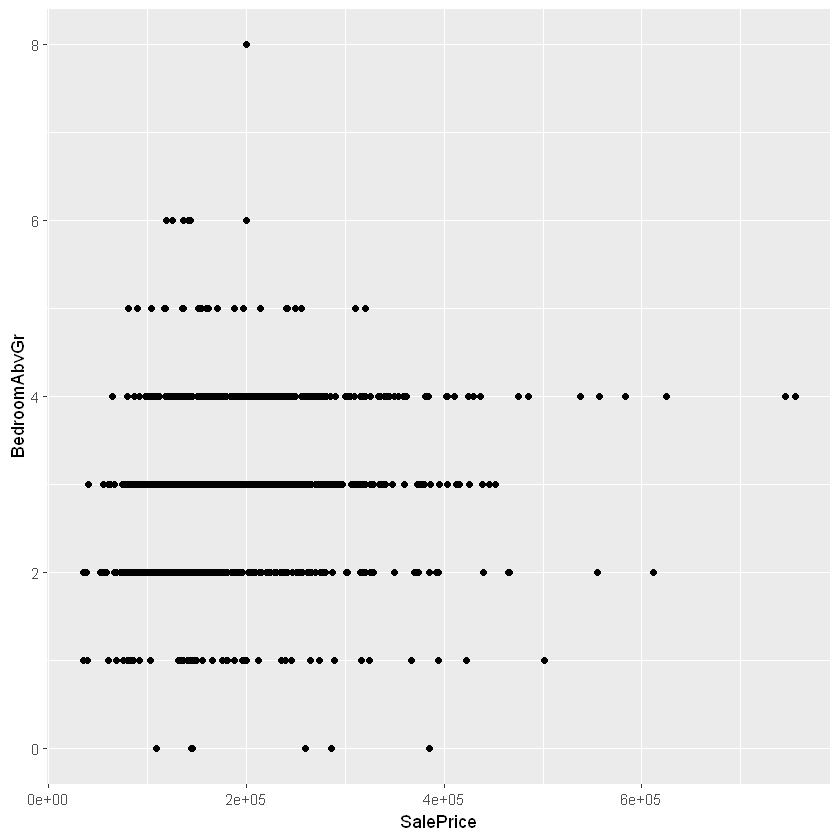

In [54]:
##COLUMN 52: BedroomAbvGr
cleaned_train_data$BedroomAbvGr <- as.numeric(cleaned_train_data$BedroomAbvGr)
sum(is.na(cleaned_train_data$BedroomAbvGr))
summary(factor(cleaned_train_data$BedroomAbvGr))
#no missing value
#outliers
ggplot(data = cleaned_train_data, aes(SalePrice, BedroomAbvGr)) + geom_point()
#no obvious outliers.
skewness(cleaned_train_data$BedroomAbvGr)
#The value is 0.211, approximately symmetrical.
#TEST DATA
cleaned_test_data$BedroomAbvGr <- as.numeric(cleaned_test_data$BedroomAbvGr)
sum(is.na(cleaned_test_data$BedroomAbvGr))
summary(factor(cleaned_test_data$BedroomAbvGr))


In [55]:
##COLUMN 53: KitchenAbvGr
cleaned_train_data$KitchenAbvGr <- as.numeric(cleaned_train_data$KitchenAbvGr)
sum(is.na(cleaned_train_data$KitchenAbvGr))
summary(factor(cleaned_train_data$KitchenAbvGr))
#no missing value
#1392 out of 1460 cases share the same value (i.e., 1), 
#which won't provid much useful insights in the modeling stage.
#KitchenAvbGr should be removed.
skewness(cleaned_train_data$KitchenAbvGr)
#The value is 4.479, highly skewed.
#KitchenAbvGr should be removed so I won't try any transformation.


[1] 0

0    1    2    3 
   1 1392   65    2

[1] 4.479178

In [56]:
##COLUMN 54: KitchenQual
sum(is.na(cleaned_train_data$KitchenQual))
summary(factor(cleaned_train_data$KitchenQual))
#no missing value
cleaned_train_data$KitchenQual <- factor(cleaned_train_data$KitchenQual, order = TRUE, 
                                         levels = c("Po", "Fa", "TA", "Gd", "Ex"))
#TEST DATA
sum(is.na(cleaned_test_data$KitchenQual))
summary(factor(cleaned_test_data$KitchenQual))
#One NA value which I will replace with the most common "TA" value
cleaned_test_data$KitchenQual <- ifelse(is.na(cleaned_test_data$KitchenQual) == TRUE, 
                                        "TA", cleaned_test_data$KitchenQual)
cleaned_test_data$KitchenQual <- factor(cleaned_test_data$KitchenQual, order = TRUE, 
                                        levels = c("Po", "Fa", "TA", "Gd", "Ex"))


[1] 0

Ex  Fa  Gd  TA 
100  39 586 735

[1] 1

Ex   Fa   Gd   TA NA's 
 105   31  565  757    1

[1] 0

2   3   4   5   6   7   8   9  10  11  12  14 
  1  17  97 275 402 329 187  75  47  18  11   1

[1] 0.6749517

[1] 0

3   4   5   6   7   8   9  10  11  12  13  15 
  8  99 308 442 320 160  68  33  14   5   1   1

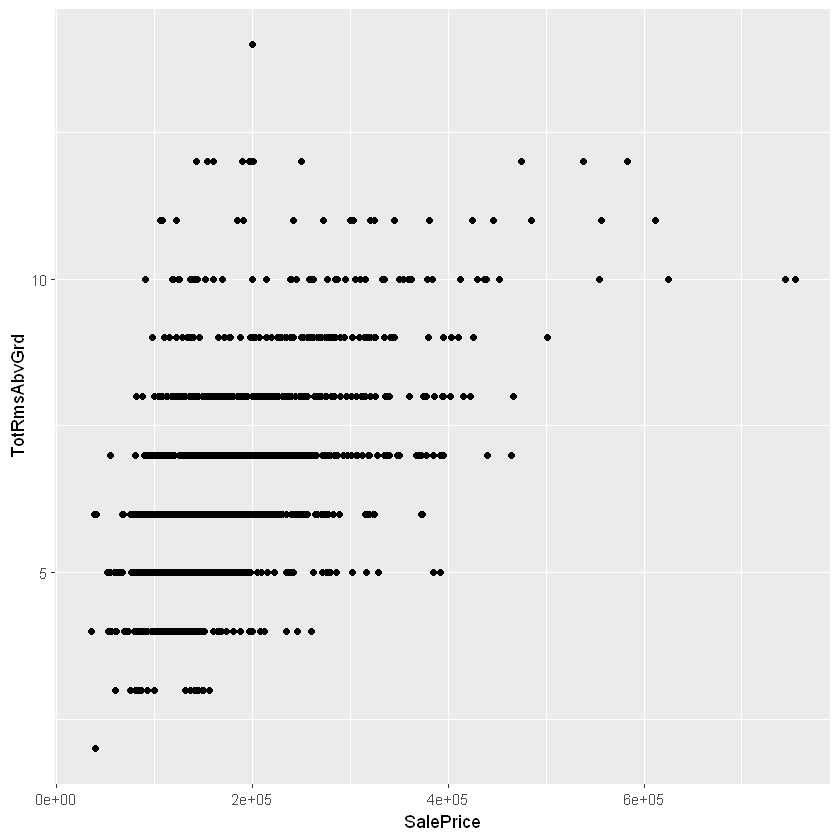

In [57]:
##COLUMN 55: TotRmsAbvGrd
cleaned_train_data$TotRmsAbvGrd <- as.numeric(cleaned_train_data$TotRmsAbvGrd)
sum(is.na(cleaned_train_data$TotRmsAbvGrd))
summary(factor(cleaned_train_data$TotRmsAbvGrd))
#no missing value
#Outliers
ggplot(data = cleaned_train_data, aes(SalePrice, TotRmsAbvGrd)) + geom_point()
#No obvious outliers
skewness(cleaned_train_data$TotRmsAbvGrd)
#The value is 0.675, moderately skewed.
#TEST DATA
cleaned_test_data$TotRmsAbvGrd <- as.numeric(cleaned_test_data$TotRmsAbvGrd)
sum(is.na(cleaned_test_data$TotRmsAbvGrd))
summary(factor(cleaned_test_data$TotRmsAbvGrd))


In [58]:
##COLUMN 56: Functional
sum(is.na(cleaned_train_data$Functional))
summary(factor(cleaned_train_data$Functional))
#Functional with type Sev is a high leverage point, replace with Maj2
cleaned_train_data$Functional <- ifelse(cleaned_train_data$Functional == "Sev", "Maj2", cleaned_train_data$Functional)
#no missing value or typo
cleaned_train_data$Functional <- factor(cleaned_train_data$Functional, order = TRUE, 
                                        levels = c("Sal", "Sev", "Maj2", "Maj1", "Mod","Min2","Min1","Typ"))
#TEST DATA
sum(is.na(cleaned_test_data$Functional))
summary(factor(cleaned_test_data$Functional))
#Two NA values which I will replace with the most common "Typ" value
cleaned_test_data$Functional <- ifelse(is.na(cleaned_test_data$Functional) == TRUE, 
                                       "Typ", cleaned_test_data$Functional)
cleaned_train_data %>%
  group_by(Functional) %>%
  summarize(no_row = length(Functional))
cleaned_test_data$Functional <- ifelse(cleaned_test_data$Functional == "Sev", "Maj2", 
                                       cleaned_test_data$Functional)
cleaned_test_data$Functional <- factor(cleaned_test_data$Functional, order = TRUE, 
                                       levels = c("Sal", "Sev", "Maj2", "Maj1", "Mod","Min2","Min1","Typ"))



[1] 0

Maj1 Maj2 Min1 Min2  Mod  Sev  Typ 
  14    5   31   34   15    1 1360

[1] 2

Maj1 Maj2 Min1 Min2  Mod  Sev  Typ NA's 
   5    4   34   36   20    1 1357    2

Functional,no_row
<ord>,<int>
Maj2,6
Maj1,14
Mod,15
Min2,34
Min1,31
Typ,1360


[1] 0

0   1   2   3 
690 650 115   5

[1] 0.6482311

[1] 0

0   1   2   3   4 
730 618 104   6   1

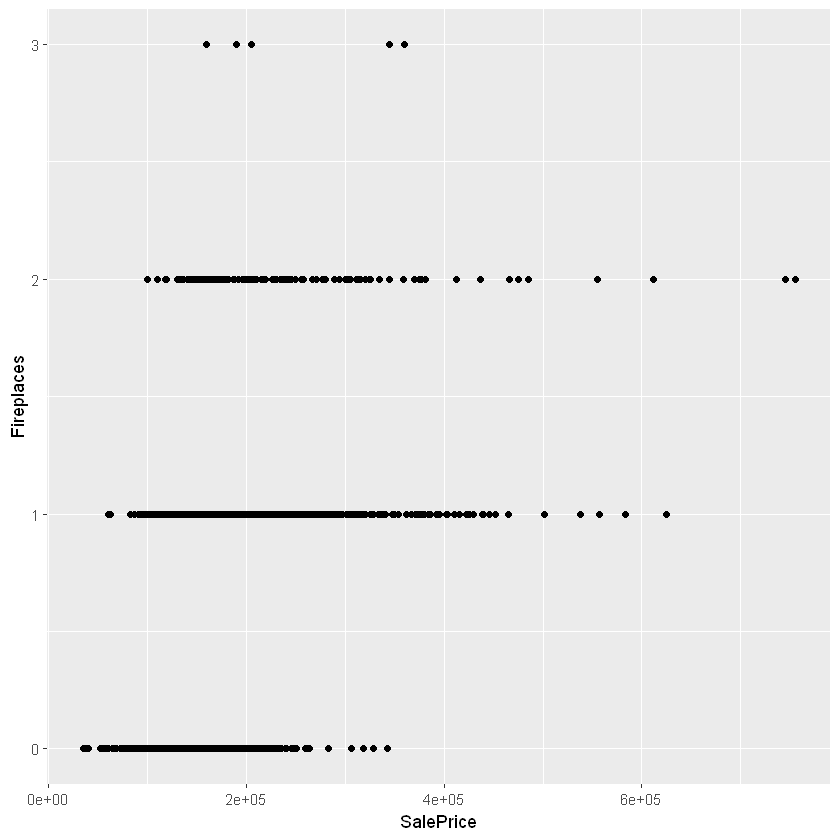

In [59]:
##COLUMN 57: Fireplaces
cleaned_train_data$Fireplaces <- as.numeric(cleaned_train_data$Fireplaces)
sum(is.na(cleaned_train_data$Fireplaces))
summary(factor(cleaned_train_data$Fireplaces))
#no missing value
#Outliers
ggplot(data = cleaned_train_data, aes(SalePrice, Fireplaces)) + geom_point()
#No obvious outliers.
skewness(cleaned_train_data$Fireplaces)
#The value is 0.648, moderately skewed.
#TEST DATA
cleaned_test_data$Fireplaces <- as.numeric(cleaned_test_data$Fireplaces)
sum(is.na(cleaned_test_data$Fireplaces))
summary(factor(cleaned_test_data$Fireplaces))


In [60]:
##COLUMN 58: FireplaceQu
sum(is.na(cleaned_train_data$FireplaceQu))
summary(factor(cleaned_train_data$FireplaceQu))
#690 NAs but they mean "No fireplace".
#Replace NAs with "No fireplace" to avoid confusion.
cleaned_train_data$FireplaceQu[is.na(cleaned_train_data$FireplaceQu)] <- "No fireplace"
cleaned_train_data$FireplaceQu <- factor(cleaned_train_data$FireplaceQu, order = TRUE, 
                                         levels = c("No fireplace", "Po", "Fa", "TA", "Gd", "Ex"))
#TEST DATA
sum(is.na(cleaned_test_data$FireplaceQu))
summary(factor(cleaned_test_data$FireplaceQu))
cleaned_test_data$FireplaceQu[is.na(cleaned_test_data$FireplaceQu)] <- "No fireplace"
cleaned_test_data$FireplaceQu <- factor(cleaned_test_data$FireplaceQu, order = TRUE, 
                                        levels = c("No fireplace", "Po", "Fa", "TA", "Gd", "Ex"))


[1] 690

Ex   Fa   Gd   Po   TA NA's 
  24   33  380   20  313  690

[1] 730

Ex   Fa   Gd   Po   TA NA's 
  19   41  364   26  279  730

In [61]:
##COLUMN 59: GarageType
sum(is.na(cleaned_train_data$GarageType))
summary(factor(cleaned_train_data$GarageType))
#81 NAs but they mean "No Garage".
#Replace NAs with "No Garage" to avoid confusion.
cleaned_train_data$GarageType[is.na(cleaned_train_data$GarageType)] <- "No Garage"
cleaned_train_data$GarageType <- as.factor(cleaned_train_data$GarageType)
#TEST DATA
sum(is.na(cleaned_test_data$GarageType))
summary(factor(cleaned_test_data$GarageType))
cleaned_test_data$GarageType[is.na(cleaned_test_data$GarageType)] <- "No Garage"
cleaned_test_data$GarageType <- as.factor(cleaned_test_data$GarageType)


[1] 81

2Types  Attchd Basment BuiltIn CarPort  Detchd    NA's 
      6     870      19      88       9     387      81

[1] 76

2Types  Attchd Basment BuiltIn CarPort  Detchd    NA's 
     17     853      17      98       6     392      76

In [62]:
##COLUMN 60: GarageYrBlt
sum(is.na(cleaned_train_data$GarageYrBlt))
#81 NAs
#REMOVE GARAGEYRBLT


[1] 81

In [63]:
##COLUMN 61: GarageFinish
sum(is.na(cleaned_train_data$GarageFinish))
summary(factor(cleaned_train_data$GarageFinish))
#81 NAs but they mean "No Garage" not missing values.
#Replace NA with "No Garage".
cleaned_train_data$GarageFinish[is.na(cleaned_train_data$GarageFinish)] <- "No Garage"
cleaned_train_data$GarageFinish <- factor(cleaned_train_data$GarageFinish, order = TRUE, 
                                          levels = c("No Garage", "Unf", "RFn", "Fin"))
#TEST DATA 
sum(is.na(cleaned_test_data$GarageFinish))
summary(factor(cleaned_test_data$GarageFinish))
cleaned_test_data$GarageFinish[is.na(cleaned_test_data$GarageFinish)] <- "No Garage"
cleaned_test_data$GarageFinish <- factor(cleaned_test_data$GarageFinish, order = TRUE, 
                                         levels = c("No Garage", "Unf", "RFn", "Fin"))


[1] 81

Fin  RFn  Unf NA's 
 352  422  605   81

[1] 78

Fin  RFn  Unf NA's 
 367  389  625   78

[1] 0

[1] -0.3418454

[1] 1

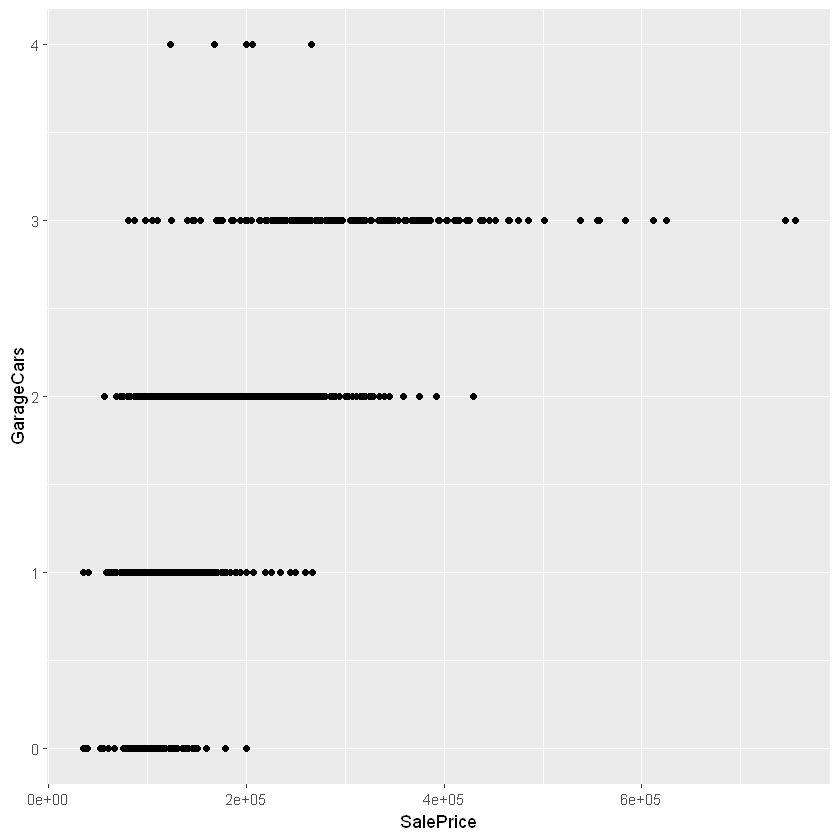

In [64]:
##COLUMN 62: GarageCars
cleaned_train_data$GarageCars <- as.numeric(cleaned_train_data$GarageCars)
sum(is.na(cleaned_train_data$GarageCars))
#No missing value
#Outliers
ggplot(data = cleaned_train_data, aes(SalePrice, GarageCars)) + geom_point()
#No obvious outliers
skewness(cleaned_train_data$GarageCars)
#The value is -0.342, approximately symmetrical.
#TEST DATA
cleaned_test_data$GarageCars <- as.numeric(cleaned_test_data$GarageCars)
sum(is.na(cleaned_test_data$GarageCars))
#One missing value which I will replace with the mean
meanOfGarageCars <- mean(ifelse(is.na(cleaned_test_data$GarageCars) == TRUE, 0, cleaned_test_data$GarageCars))
cleaned_test_data$GarageCars <- ifelse(is.na(cleaned_test_data$GarageCars) == TRUE, 
                                       meanOfGarageCars, cleaned_test_data$GarageCars)


[1] 0

[1] 0.0461306

[1] 1

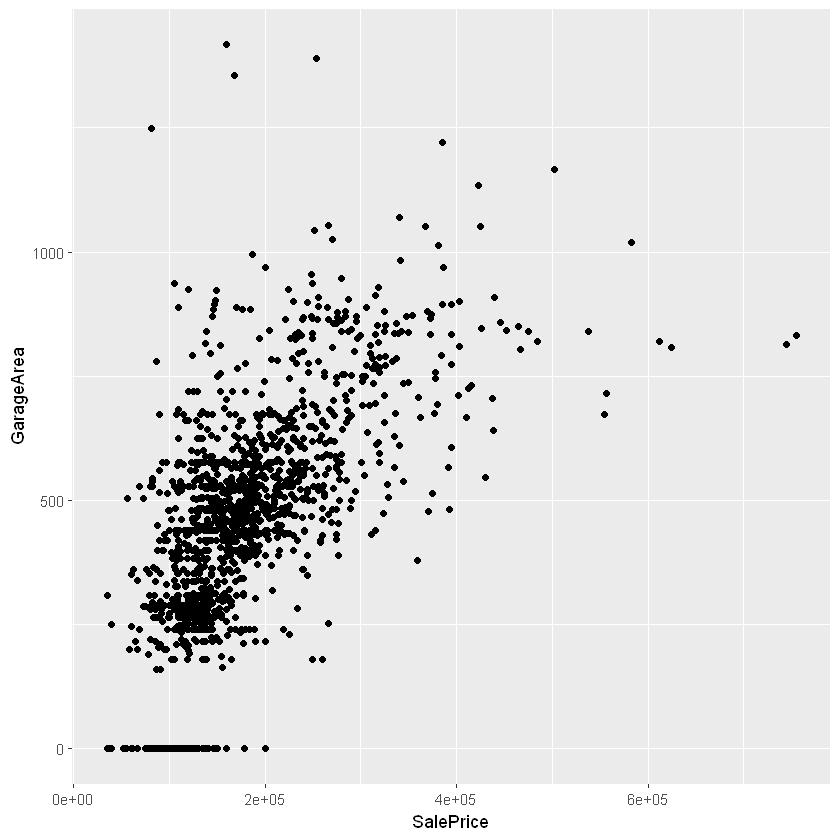

In [65]:
##COLUMN 63: GarageArea
cleaned_train_data$GarageArea <- as.numeric(cleaned_train_data$GarageArea)
sum(is.na(cleaned_train_data$GarageArea))
#No missing value or unreasonable values
#Outliers
ggplot(data = cleaned_train_data, aes(SalePrice, GarageArea)) + geom_point()
#Outliers seem to be around 1250.
#Replace outliers with mean.
cleaned_train_data$GarageArea <- ifelse(cleaned_train_data$GarageArea > 1250,
                                        mean(cleaned_train_data$GarageArea),
                                        cleaned_train_data$GarageArea)
skewness(cleaned_train_data$GarageArea)
#The value is 0.046, approximately symmetrical.
#TEST DATA
cleaned_test_data$GarageArea <- as.numeric(cleaned_test_data$GarageArea)
sum(is.na(cleaned_test_data$GarageArea))
#One missing value which I will replace with the mean
meanOfGarageArea <- mean(ifelse(is.na(cleaned_test_data$GarageArea) == TRUE, 0, cleaned_test_data$GarageArea))
cleaned_test_data$GarageArea <- ifelse(is.na(cleaned_test_data$GarageArea) == TRUE, 
                                       meanOfGarageArea, cleaned_test_data$GarageArea)


In [66]:
##COLUMN 64: GarageQual
sum(is.na(cleaned_train_data$GarageQual))
summary(factor(cleaned_train_data$GarageQual))
#81 NAs but they mean "No Garage" not missing values.
#Replace NA with "No Garage".
cleaned_train_data$GarageQual[is.na(cleaned_train_data$GarageQual)] <- "No Garage"
cleaned_train_data$GarageQual <- factor(cleaned_train_data$GarageQual, order = TRUE, 
                                        levels = c("No Garage", "Po", "Fa", "TA", "Gd", "Ex"))
#TEST DATA
sum(is.na(cleaned_test_data$GarageQual))
summary(factor(cleaned_test_data$GarageQual))
cleaned_test_data$GarageQual[is.na(cleaned_test_data$GarageQual)] <- "No Garage"
cleaned_test_data$GarageQual <- factor(cleaned_test_data$GarageQual, order = TRUE, 
                                       levels = c("No Garage", "Po", "Fa", "TA", "Gd", "Ex"))


[1] 81

Ex   Fa   Gd   Po   TA NA's 
   3   48   14    3 1311   81

[1] 78

Fa   Gd   Po   TA NA's 
  76   10    2 1293   78

[1] 81

Ex   Fa   Gd   Po   TA NA's 
   2   35    9    7 1326   81

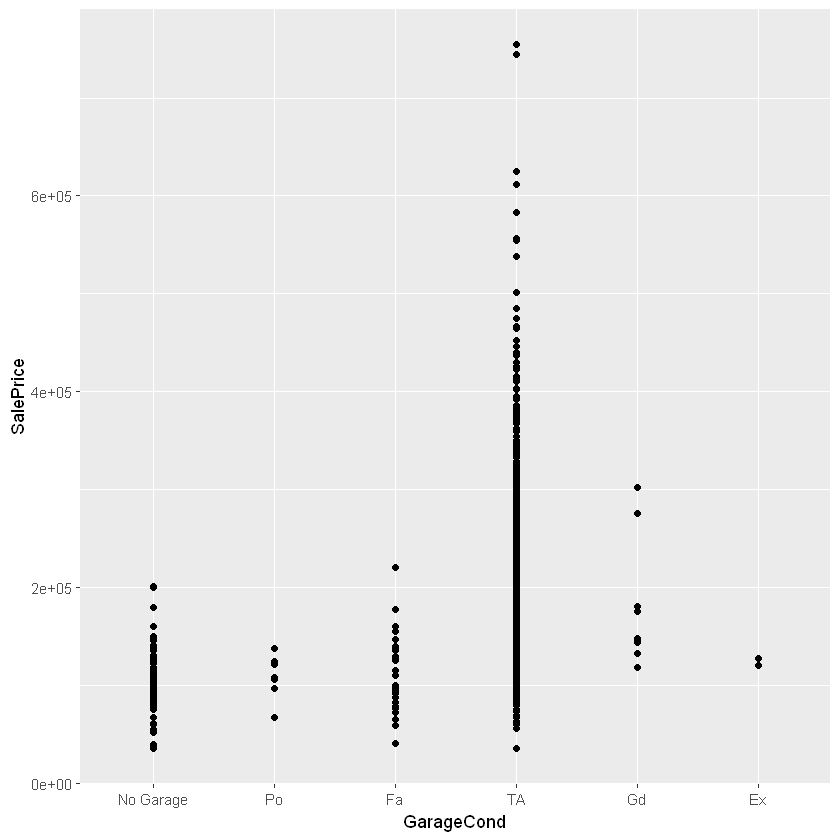

No Garage        Po        Fa        TA        Gd        Ex 
       81         7        35      1326         9         2

No Garage        Po        Fa        TA        Gd        Ex 
       81         3        48      1311        14         3

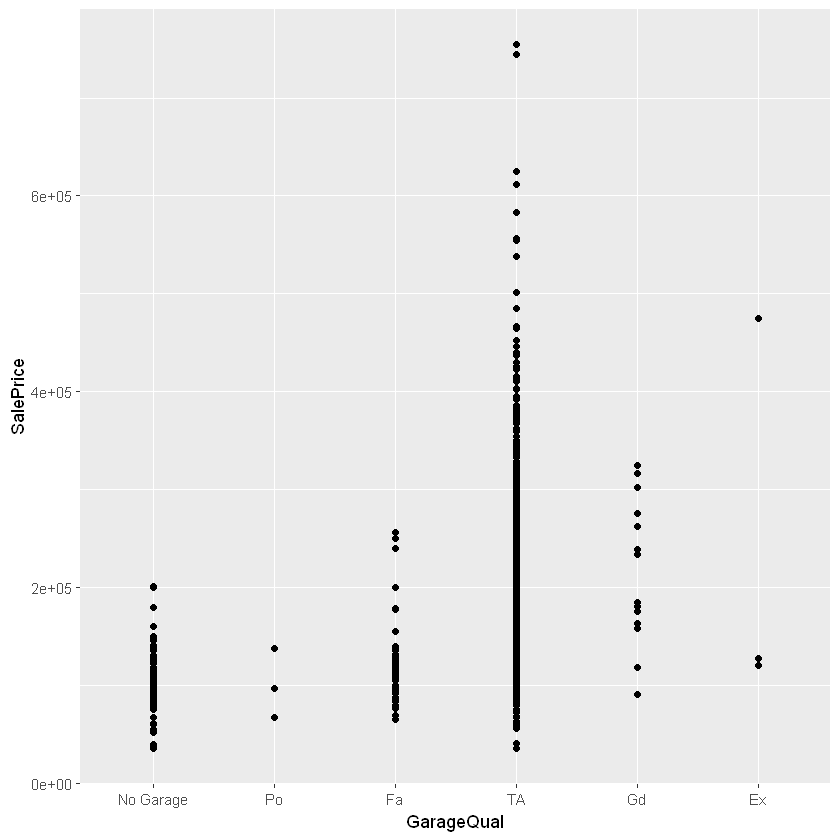

In [67]:
##COLUMN 65: GarageCond
sum(is.na(cleaned_train_data$GarageCond))
summary(factor(cleaned_train_data$GarageCond))
#81 NAs but they mean "No Garage" not missing values.
#Replace NA with "No Garage".
cleaned_train_data$GarageCond[is.na(cleaned_train_data$GarageCond)] <- "No Garage"
cleaned_train_data$GarageCond <- factor(cleaned_train_data$GarageCond, order = TRUE, 
                                        levels = c("No Garage", "Po", "Fa", "TA", "Gd", "Ex"))
####
#Wait, won't GarageCond and GarageQual the same thing or at least closely related?
ggplot(cleaned_train_data, aes(GarageCond, SalePrice)) + geom_point()
ggplot(cleaned_train_data, aes(GarageQual, SalePrice)) + geom_point()
#The plots are approximately identical.
#Let's see the frequency of each level.
summary(cleaned_train_data$GarageCond)
summary(cleaned_train_data$GarageQual)
#Frequencies between two variables for the same level are similar. 
#Consider removing one the two variables.


In [68]:
##COLUMN 66: PavedDrive
sum(is.na(cleaned_train_data$PavedDrive))
summary(factor(cleaned_train_data$PavedDrive))
#No missing valua or typos.
cleaned_train_data$PavedDrive <- as.factor(cleaned_train_data$PavedDrive)
#TEST DATA
sum(is.na(cleaned_test_data$PavedDrive))
summary(factor(cleaned_test_data$PavedDrive))
cleaned_test_data$PavedDrive <- as.factor(cleaned_test_data$PavedDrive)


[1] 0

N    P    Y 
  90   30 1340

[1] 0

N    P    Y 
 126   32 1301

[1] 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


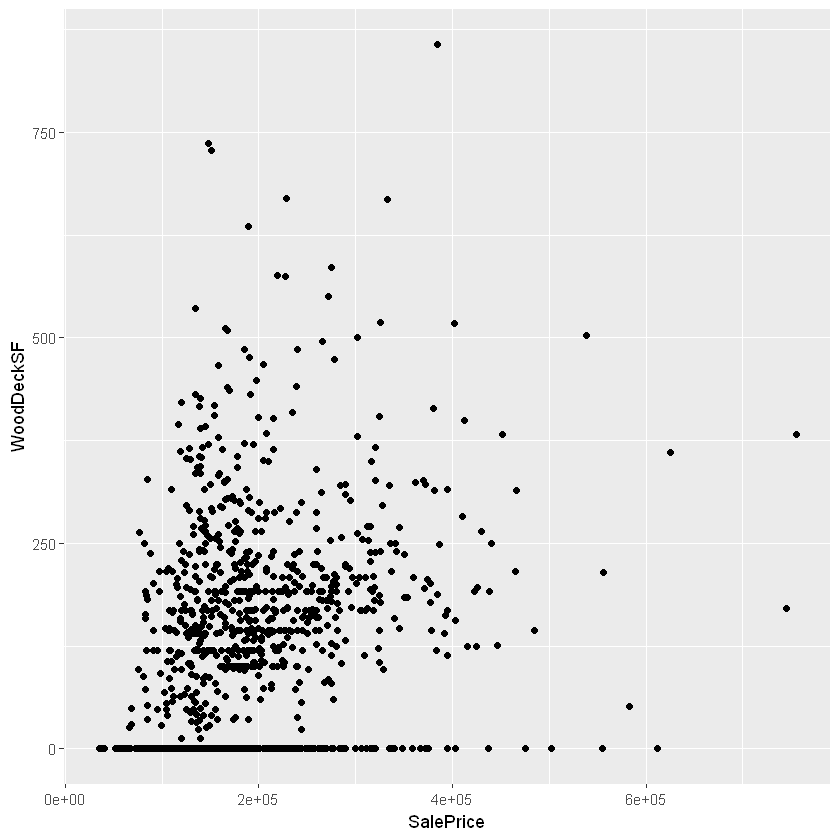

[1] 1.450954

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


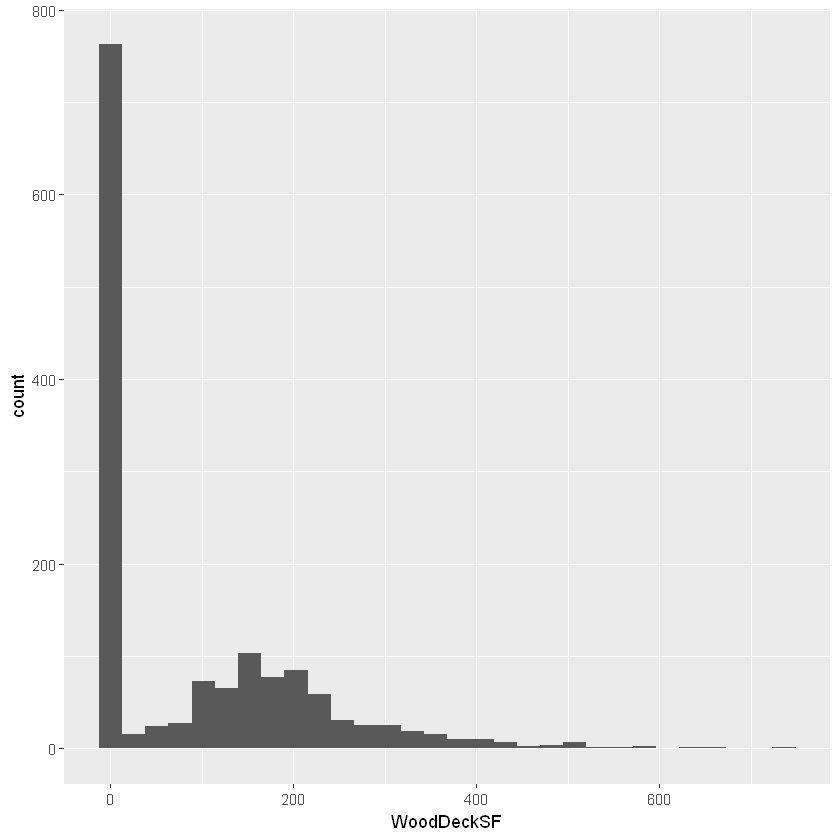

[1] 0.1525407

[1] 0

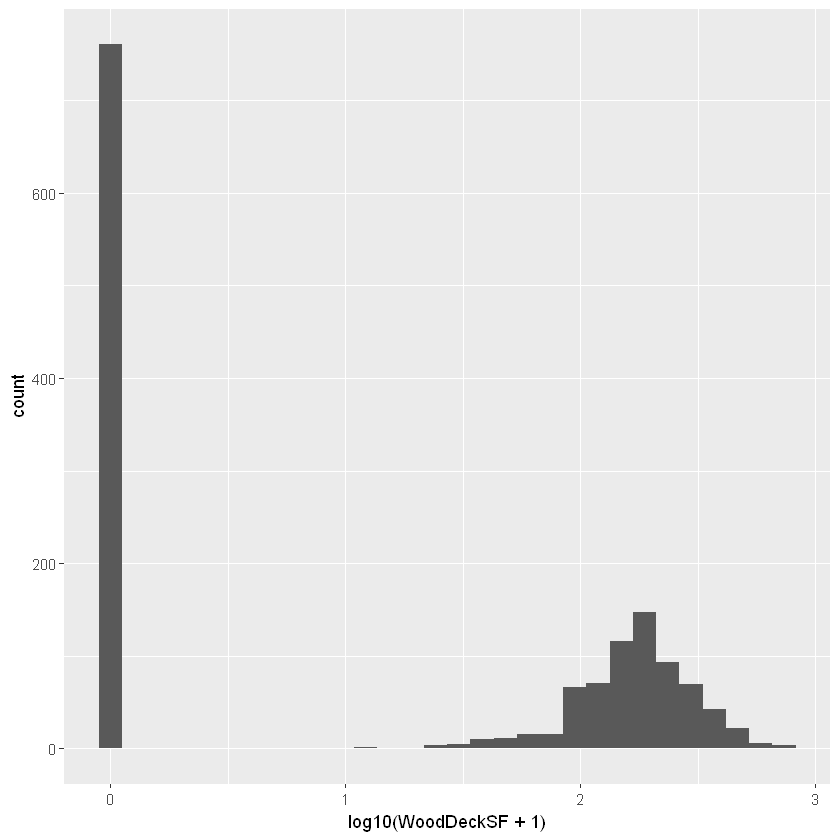

In [69]:
##COLUMN 67: WoodDeckSF
cleaned_train_data$WoodDeckSF <- as.numeric(cleaned_train_data$WoodDeckSF)
sum(is.na(cleaned_train_data$WoodDeckSF))
#No missing value.
#Outliers
ggplot(data = cleaned_train_data, aes(SalePrice, WoodDeckSF)) + geom_point()
#Outliers seem to be around 750.
#Replace outliers with mean.
cleaned_train_data$WoodDeckSF <- ifelse(cleaned_train_data$WoodDeckSF > 750,
                                        mean(cleaned_train_data$WoodDeckSF),
                                        cleaned_train_data$WoodDeckSF)
#Skewness
ggplot(data = cleaned_train_data, aes(WoodDeckSF)) + geom_histogram()
skewness(cleaned_train_data$WoodDeckSF)
#The value is 1.357, highly skewed.
#Try log transformation.
ggplot(data = cleaned_train_data, aes(log10(WoodDeckSF+1))) + geom_histogram()
skewness(log10(cleaned_train_data$WoodDeckSF +1))
#Skewness has been greatly improved.
cleaned_train_data$WoodDeckSF <- log10(cleaned_train_data$WoodDeckSF +1)

#TEST DATA
cleaned_test_data$WoodDeckSF <- as.numeric(cleaned_test_data$WoodDeckSF)
sum(is.na(cleaned_test_data$WoodDeckSF))
cleaned_test_data$WoodDeckSF <- log10(cleaned_test_data$WoodDeckSF +1)

[1] 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


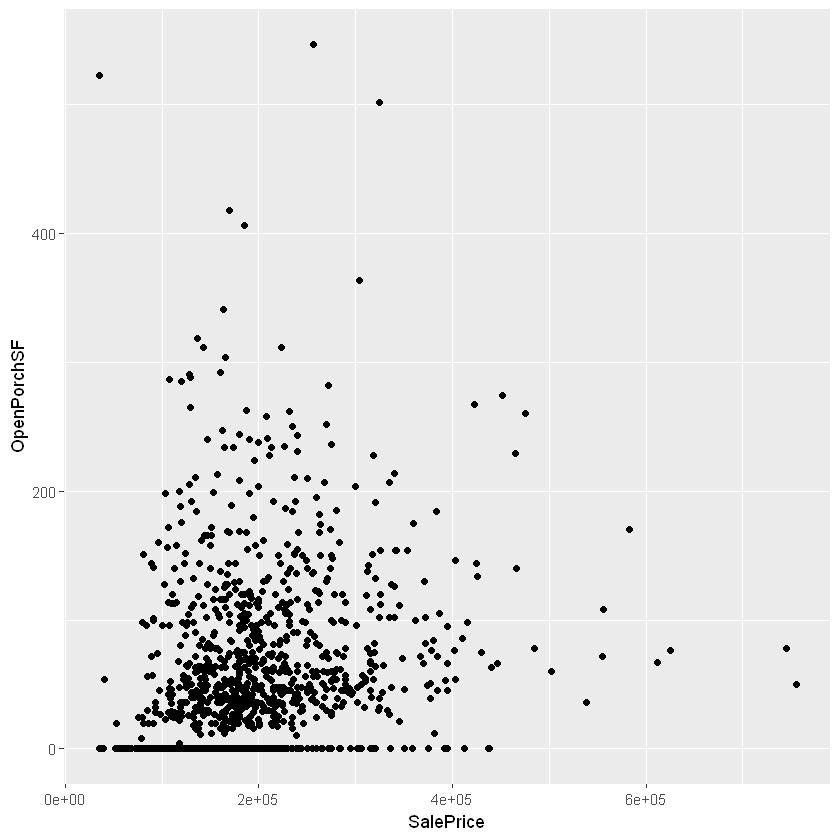

[1] 1.928724

[1] 0

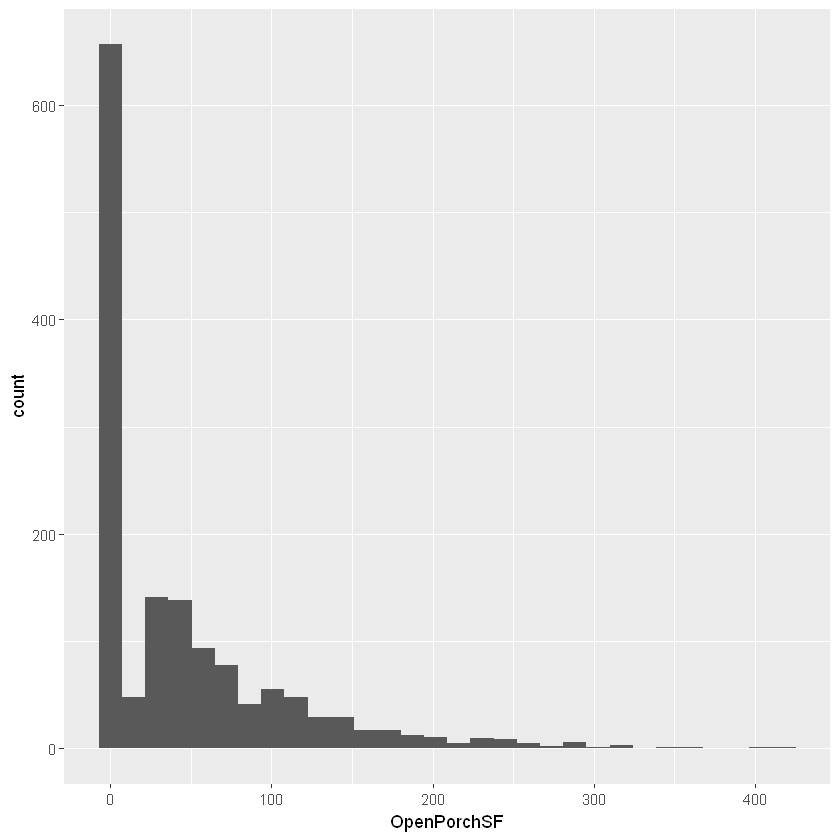

In [70]:
##COLUMN 68: OpenPorchSF
cleaned_train_data$OpenPorchSF <- as.numeric(cleaned_train_data$OpenPorchSF)
sum(is.na(cleaned_train_data$OpenPorchSF))
#No missing value.
#Outliers
ggplot(data = cleaned_train_data, aes(SalePrice, OpenPorchSF)) + geom_point()
#Outliers seem to be around 500.
#Replace outliers with mean.
cleaned_train_data$OpenPorchSF <- ifelse(cleaned_train_data$OpenPorchSF > 500,
                                         mean(cleaned_train_data$OpenPorchSF),
                                         cleaned_train_data$OpenPorchSF)
#Skewness
ggplot(data = cleaned_train_data, aes(OpenPorchSF)) + geom_histogram()
skewness(cleaned_train_data$OpenPorchSF)
#The value is 1.93, highly skewed.
#As I will combine OpenPorchSF with other variables to create a new variable,
#for now I won't do any transformation.
#TEST DATA
cleaned_test_data$OpenPorchSF <- as.numeric(cleaned_test_data$OpenPorchSF)
sum(is.na(cleaned_test_data$OpenPorchSF))

[1] 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


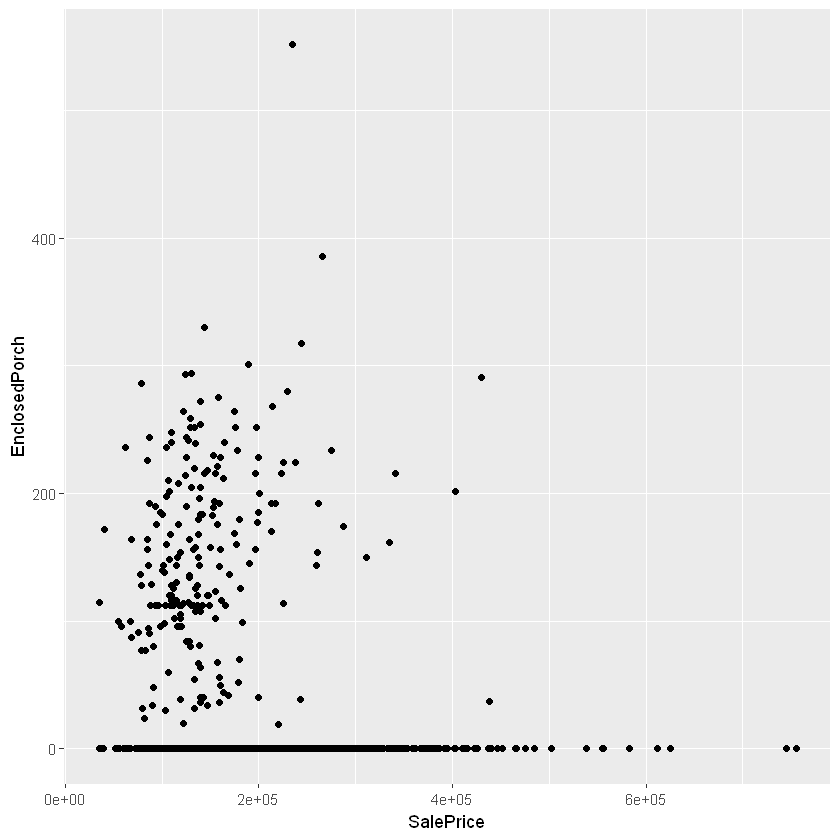

[1] 2.87309

[1] 0

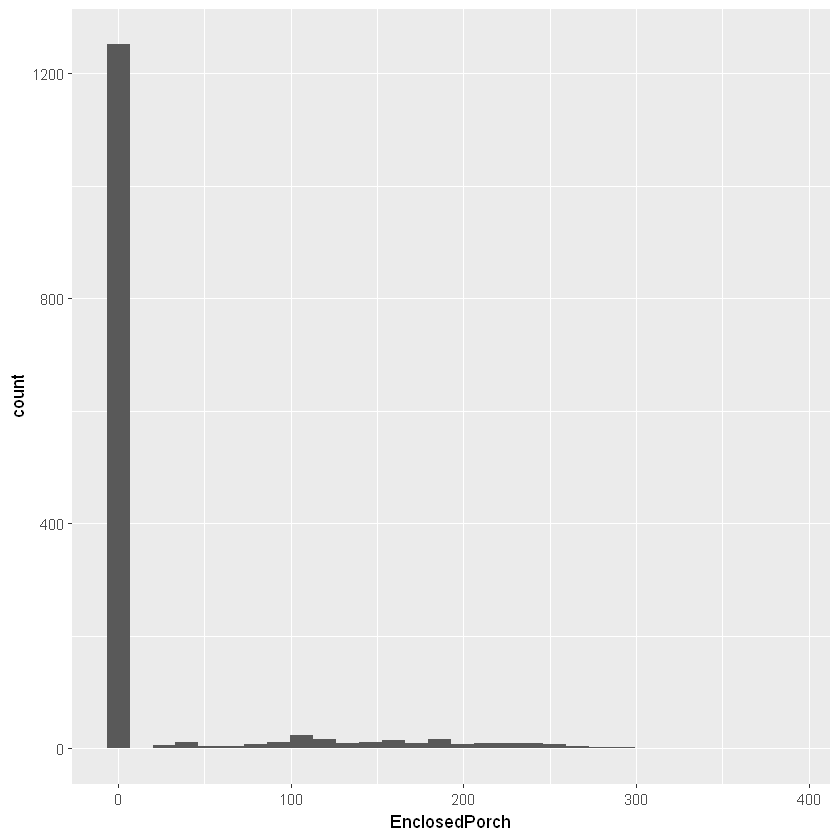

In [71]:
##COLUMN 69: EnclosedPorch
cleaned_train_data$EnclosedPorch <- as.numeric(cleaned_train_data$EnclosedPorch)
sum(is.na(cleaned_train_data$EnclosedPorch))
#No missing value 
#Outliers
ggplot(data = cleaned_train_data, aes(SalePrice, EnclosedPorch)) + geom_point()
#Outliers seem to be around 500.
#Replace outliers with mean.
cleaned_train_data$EnclosedPorch <- ifelse(cleaned_train_data$EnclosedPorch > 500,
                                           mean(cleaned_train_data$EnclosedPorch),
                                           cleaned_train_data$EnclosedPorch)
#Skewness
ggplot(data = cleaned_train_data, aes(EnclosedPorch)) + geom_histogram()
skewness(cleaned_train_data$EnclosedPorch)
#The value is 2.87, highly skewed.
#As I will combine EnclosedPorch with other variables to create a new variable,
#for now I won't do any transformation.
#TEST DATA
cleaned_test_data$EnclosedPorch <- as.numeric(cleaned_test_data$EnclosedPorch)
sum(is.na(cleaned_test_data$EnclosedPorch))


[1] 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


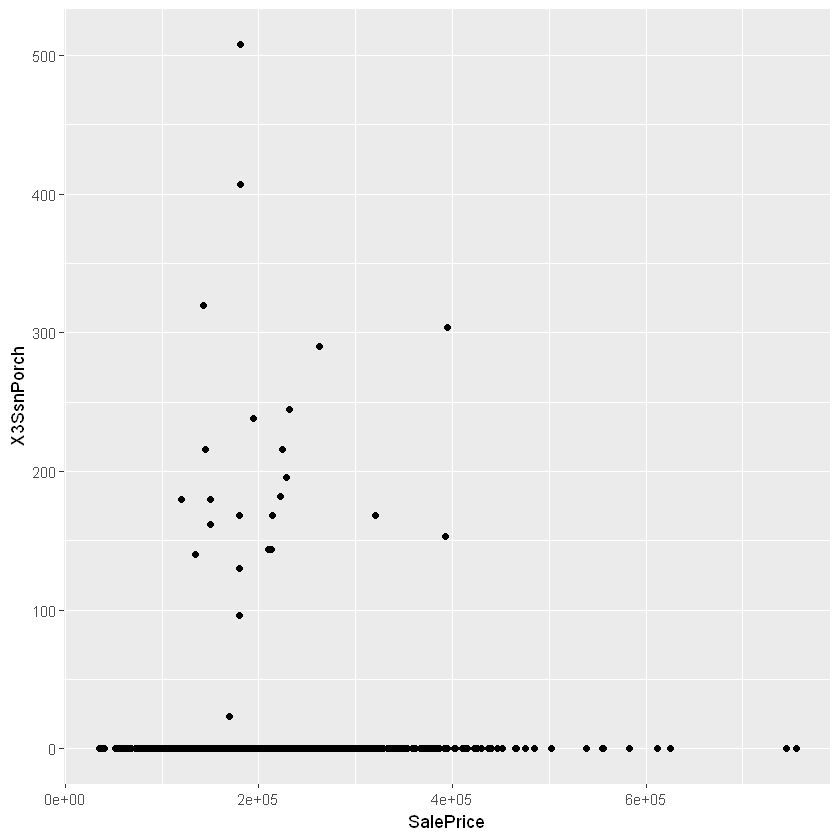

[1] 9.587157

[1] 0

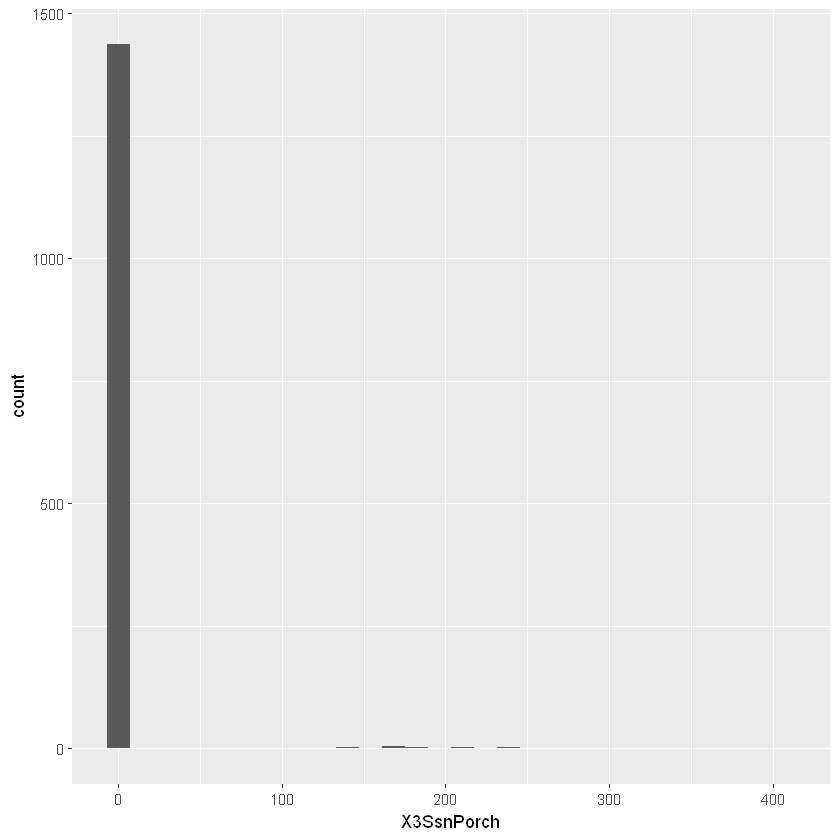

In [72]:
##COLUMN 70: X3SsnPorch
cleaned_train_data$X3SsnPorch <- as.numeric(cleaned_train_data$X3SsnPorch)
sum(is.na(cleaned_train_data$X3SsnPorch))
#Outliers
ggplot(data = cleaned_train_data, aes(SalePrice, X3SsnPorch)) + geom_point()
#Outliers seem to be around 500.
#Replace outliers with mean.
cleaned_train_data$X3SsnPorch <- ifelse(cleaned_train_data$X3SsnPorch > 500,
                                        mean(cleaned_train_data$X3SsnPorch),
                                        cleaned_train_data$X3SsnPorch)
#Skewness
ggplot(data = cleaned_train_data, aes(X3SsnPorch)) + geom_histogram()
skewness(cleaned_train_data$X3SsnPorch)
#The value is 10.28, highly skewed.
#As I will combine EnclosedPorch with other variables to create a new variable,
#for now I won't do any transformation.
#TEST DATA
cleaned_test_data$X3SsnPorch <- as.numeric(cleaned_test_data$X3SsnPorch)
sum(is.na(cleaned_test_data$X3SsnPorch))

[1] 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


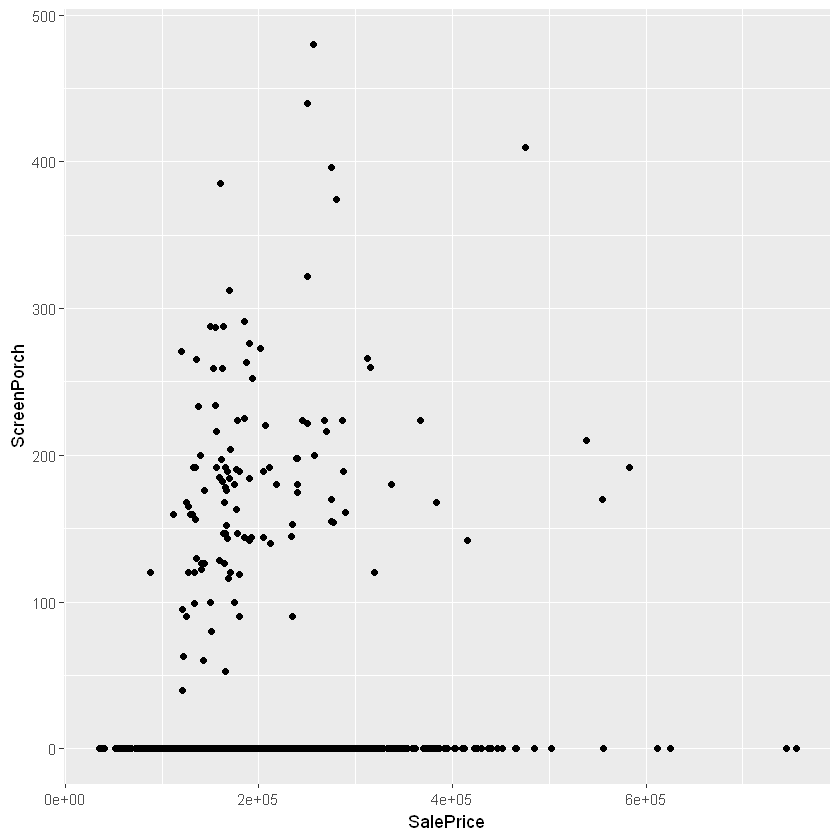

[1] 4.113747

[1] 0

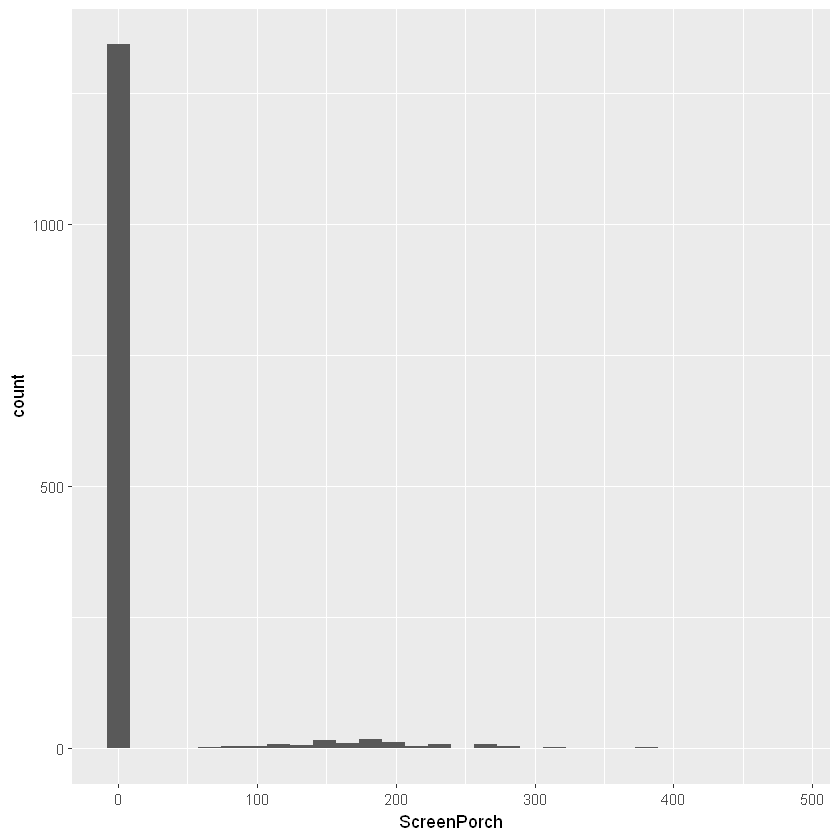

In [73]:
##COLUMN 71: ScreenPorch
cleaned_train_data$ScreenPorch <- as.numeric(cleaned_train_data$ScreenPorch)
sum(is.na(cleaned_train_data$ScreenPorch))
#No missing value.
#Outliers
ggplot(data = cleaned_train_data, aes(SalePrice, ScreenPorch)) + geom_point()
#I don't see very obvious outliers.
#Skewness
ggplot(data = cleaned_train_data, aes(ScreenPorch)) + geom_histogram()
skewness(cleaned_train_data$ScreenPorch)
#The value is 4.114, highly skewed.
#As I will combine EnclosedPorch with other variables to create a new variable,
#for now I won't do any transformation.
#TEST DATA
cleaned_test_data$ScreenPorch <- as.numeric(cleaned_test_data$ScreenPorch)
sum(is.na(cleaned_test_data$ScreenPorch))


[1] 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


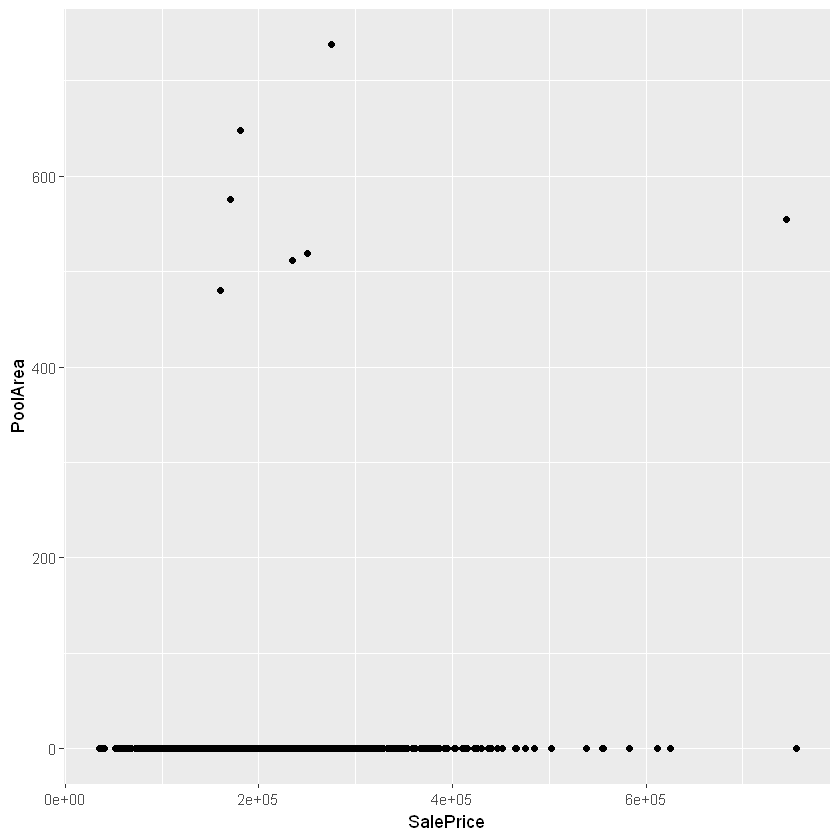

[1] 14.79792

[1] 0

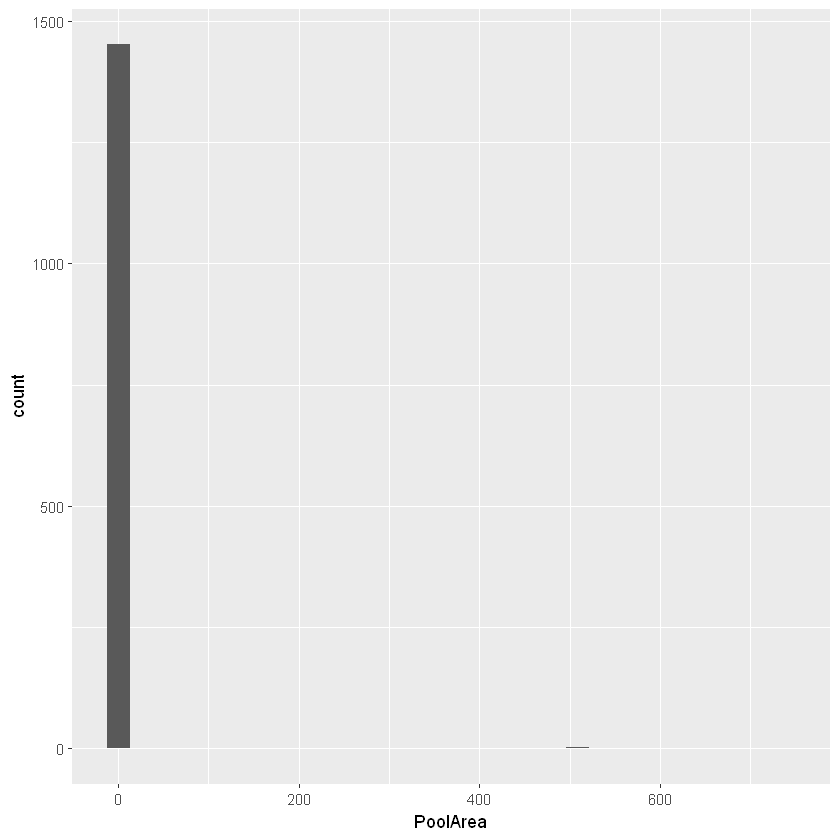

In [74]:
##COLUMN 72: PoolArea
sum(is.na(cleaned_train_data$PoolArea))
#No missing value.
#Outliers
ggplot(data = cleaned_train_data, aes(SalePrice, PoolArea)) + geom_point()
#I don't see very obvious outliers.
#However, 1453 out of 1460 case have the same value (i.e., 0), which
#won't provid much useful information in the modeling stage.
#PoolArea should be removed.
#Skewness
ggplot(data = cleaned_train_data, aes(PoolArea)) + geom_histogram()
skewness(cleaned_train_data$PoolArea)
#The value is 14.798, highly skewed.
#TEST DATA
sum(is.na(cleaned_test_data$PoolArea))


In [75]:
##COLUMN 73: PoolQC
sum(is.na(cleaned_train_data$PoolQC))
summary(factor(cleaned_train_data$PoolQC))
#1453 NAs but they mean "No Pool".
#Replace NAs with "No Pool".
cleaned_train_data$PoolQC[is.na(cleaned_train_data$PoolQC)] <- "No Pool"
cleaned_train_data$PoolQC <- factor(cleaned_train_data$PoolQC, order = TRUE, 
                                    levels = c("No Pool", "Fa", "TA", "Gd", "Ex"))
#Similar to PoolArea, PoolQC should be removed.


[1] 1453

Ex   Fa   Gd NA's 
   2    2    3 1453

In [76]:
##COLUMN 74: Fence
sum(is.na(cleaned_train_data$Fence))
summary(factor(cleaned_train_data$Fence))
#1179 NAs but they mean "No Fence".
#Replace NAs with "No Fence".
cleaned_train_data$Fence[is.na(cleaned_train_data$Fence)] <- "No Fence"
cleaned_train_data$Fence <- factor(cleaned_train_data$Fence, order = TRUE, 
                                   levels = c("No Fence", "MnWw", "GdWo", "MnPrv", "GdPrv"))
#TEST DATA
sum(is.na(cleaned_test_data$Fence))
summary(factor(cleaned_test_data$Fence))
cleaned_test_data$Fence[is.na(cleaned_test_data$Fence)] <- "No Fence"
cleaned_test_data$Fence <- factor(cleaned_test_data$Fence, order = TRUE, 
                                  levels = c("No Fence", "MnWw", "GdWo", "MnPrv", "GdPrv"))

[1] 1179

GdPrv  GdWo MnPrv  MnWw  NA's 
   59    54   157    11  1179

[1] 1169

GdPrv  GdWo MnPrv  MnWw  NA's 
   59    58   172     1  1169

In [77]:
##COLUMN 75: MiscFeature
sum(is.na(cleaned_train_data$MiscFeature))
summary(factor(cleaned_train_data$MiscFeature))
#1406 NAs but they mean "None".
#Replace NAs with "None" to avoid confusion.
cleaned_train_data$MiscFeature[is.na(cleaned_train_data$MiscFeature)] <- "None"
cleaned_train_data$MiscFeature <- as.factor(cleaned_train_data$MiscFeature)
#MiscFeature should be removed because 1406 out of 1460 cases share the same value,
#which won't generate much useful information in data modeling.


[1] 1406

Gar2 Othr Shed TenC NA's 
   2    2   49    1 1406

[1] 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


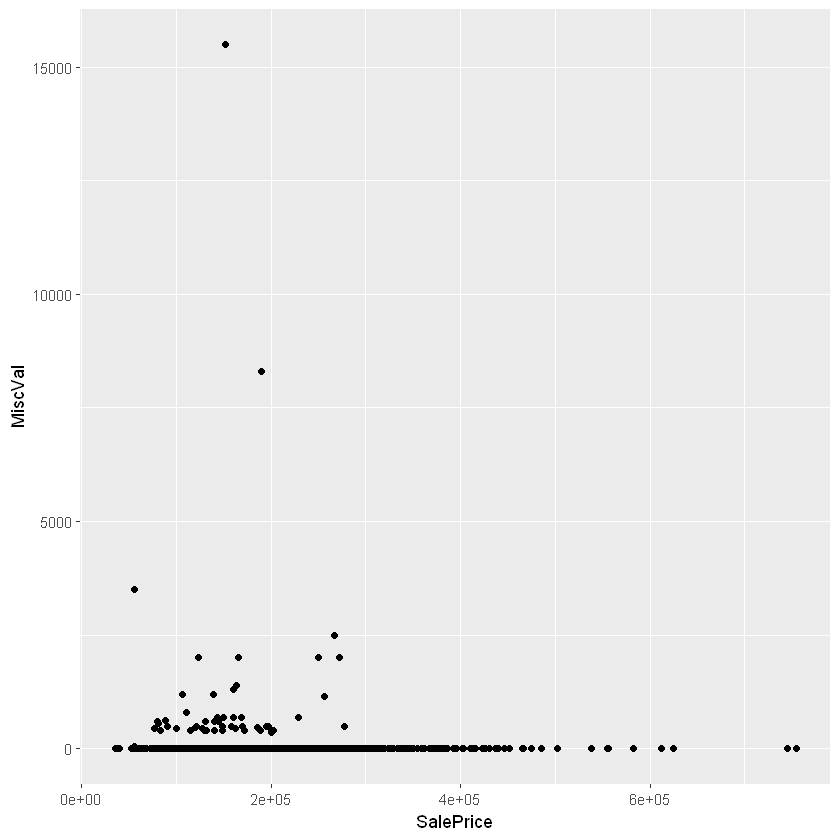

[1] 10.48715

0 43.4890410958904               54              350 
            1408                2                1                1 
             400              450              480              500 
              11                4                2                8 
             560              600              620              700 
               1                4                1                5 
             800             1150             1200             1300 
               1                1                2                1 
            1400             2000             2500             3500 
               1                4                1                1

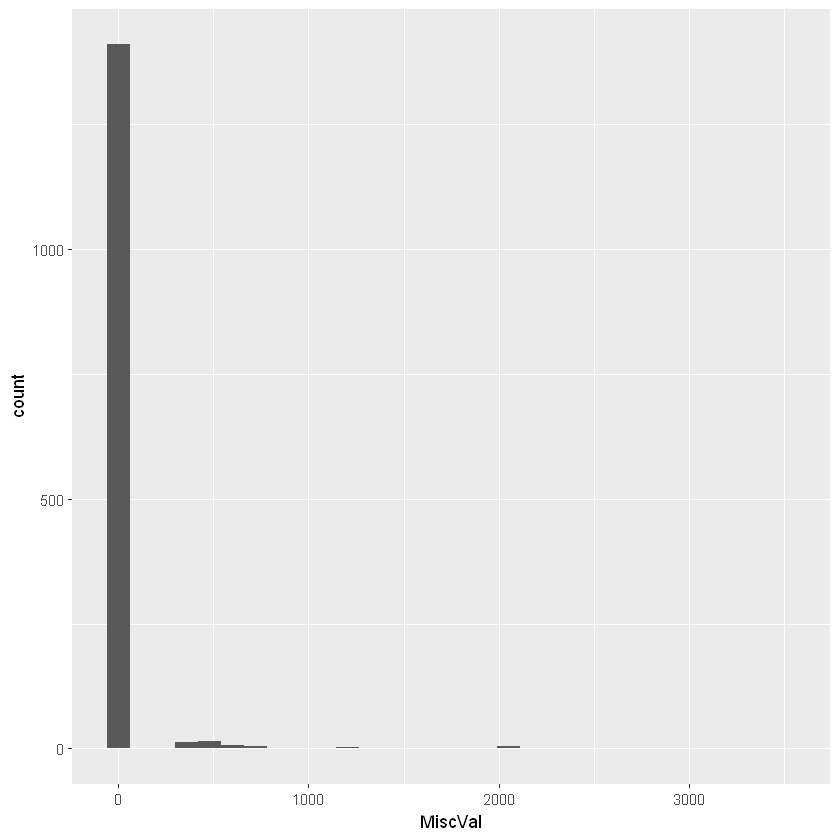

In [78]:
##COLUMN 76: MiscVal
sum(is.na(cleaned_train_data$MiscVal))
#Outliers
ggplot(data = cleaned_train_data, aes(SalePrice, MiscVal)) + geom_point()
#Outliers seem to be around 7500.
#Replace outliers with mean.
cleaned_train_data$MiscVal <- ifelse(cleaned_train_data$MiscVal > 7500,
                                     mean(cleaned_train_data$MiscVal),
                                     cleaned_train_data$MiscVal)
#Skewness
ggplot(data = cleaned_train_data, aes(MiscVal)) + geom_histogram()
skewness(cleaned_train_data$MiscVal)
#The value is 10.487, highly skewed.
summary(factor(cleaned_train_data$MiscVal))
#MiscVal has 1408 out of 1460 cases with the same value (i.e., 0), 
#which won't provide much useful information during the modeling stage.
#Suggest removing this variable.


In [79]:
##COLUMN 77: MoSold
sum(is.na(cleaned_train_data$MoSold))
#No missing value 
#Similar to YearBuilt, it would be more reasonable to explain the coefficient of MoSold
#when MoSold is a categorical variable.
cleaned_train_data$MoSold <- as.factor(cleaned_train_data$MoSold)
#TEST DATA
sum(is.na(cleaned_test_data$MoSold))
cleaned_test_data$MoSold <- as.factor(cleaned_test_data$MoSold)

[1] 0

[1] 0

In [80]:
##COLUMN 78: YrSold
sum(is.na(cleaned_train_data$YrSold))
#No missing value
#Similar to YearBuilt, it would be more reasonable to explain the coefficient of YrSold
#when YrSold is a categorical variable.
cleaned_train_data$YrSold <- as.factor(cleaned_train_data$YrSold)
#TEST DATA
sum(is.na(cleaned_test_data$YrSold))
cleaned_test_data$YrSold <- as.factor(cleaned_test_data$YrSold)

[1] 0

[1] 0

In [81]:
##COLUMN 79: SaleType
sum(is.na(cleaned_train_data$SaleType))
summary(factor(cleaned_train_data$SaleType))
#No missing value or typo
cleaned_train_data$SaleType <- as.factor(cleaned_train_data$SaleType)
#TEST DATA
sum(is.na(cleaned_test_data$SaleType))
summary(factor(cleaned_test_data$SaleType))
#One NA value will be replaced with the most common "WD" value
cleaned_test_data$SaleType <- ifelse(is.na(cleaned_test_data$SaleType) == TRUE,
                                     "WD", cleaned_test_data$SaleType)
cleaned_test_data$SaleType <- as.factor(cleaned_test_data$SaleType)

[1] 0

COD   Con ConLD ConLI ConLw   CWD   New   Oth    WD 
   43     2     9     5     5     4   122     3  1267

[1] 1

COD   Con ConLD ConLI ConLw   CWD   New   Oth    WD  NA's 
   44     3    17     4     3     8   117     4  1258     1

In [82]:
##COLUMN 80: SaleCondition
sum(is.na(cleaned_train_data$SaleCondition))
summary(factor(cleaned_train_data$SaleCondition))
#No missing value or typos.
cleaned_train_data$SaleCondition <- as.factor(cleaned_train_data$SaleCondition)
#TEST DATA
sum(is.na(cleaned_test_data$SaleCondition))
summary(factor(cleaned_test_data$SaleCondition))
cleaned_test_data$SaleCondition <- as.factor(cleaned_test_data$SaleCondition)

[1] 0

Abnorml AdjLand  Alloca  Family  Normal Partial 
    101       4      12      20    1198     125

[1] 0

Abnorml AdjLand  Alloca  Family  Normal Partial 
     89       8      12      26    1204     120

In [83]:
##COLUMN 81: SalePrice
sum(is.na(cleaned_train_data$SalePrice))
#No missing value.
skewness(cleaned_train_data$SalePrice)
#The value is 1.879, highly skewed.
#Try log transformation.
skewness(log(cleaned_train_data$SalePrice, 10))

[1] 0

[1] 1.879009

[1] 0.1210859

## Feature Engineering

Next, I combined several columns to create more comprehensive variables that better capture the relationships in the data. These new variables include 'HomeTotalSF', 'TotalPorchSF', 'TotalFullBath', and 'TotalHalfBath'. This process of combining columns enhances the quality of the variables, helping to reduce noise and improve model performance.

In [84]:
#TRAIN DATA
#Create 'HomeTotalSF', by combining square feet data from all areas of the houses.
cleaned_train_data$HomeTotalSF <- cleaned_train_data$TotalBsmtSF + cleaned_train_data$X1stFlrSF + cleaned_train_data$X2ndFlrSF
skewness(cleaned_train_data$HomeTotalSF) #.7 - Slightly skewed
#Create 'TotalPorchSF', by combining square feet data from all porch areas of the houses.
cleaned_train_data$TotalPorchSF <- cleaned_train_data$OpenPorchSF + cleaned_train_data$EnclosedPorch + cleaned_train_data$X3SsnPorch + cleaned_train_data$ScreenPorch
skewness(cleaned_train_data$TotalPorchSF) #1.56 - Highly skewed
#Try log transformation.
skewness(log10(cleaned_train_data$TotalPorchSF+1))
#Create 'TotalFullBath', combining basement and regular full bathroom counts.
cleaned_train_data$TotalFullBath <- cleaned_train_data$BsmtFullBath + cleaned_train_data$FullBath 
skewness(cleaned_train_data$TotalFullBath) #0.29 
#Lastly, create 'TotalHalfBath', combining basement and regular half bathroom counts. 
cleaned_train_data$TotalHalfBath <- cleaned_train_data$BsmtHalfBath + cleaned_train_data$HalfBath
skewness(cleaned_train_data$TotalHalfBath) #.93 - slightly skewed

[1] 0.7004295

[1] 1.565834

[1] -0.516992

[1] 0.2976728

[1] 0.9369496

I perform the same operations on the test data. 

In [85]:
#TEST DATA
#Create 'HomeTotalSF'
cleaned_test_data$HomeTotalSF <- cleaned_test_data$TotalBsmtSF + cleaned_test_data$X1stFlrSF + cleaned_test_data$X2ndFlrSF
#Create 'TotalPorchSF'
cleaned_test_data$TotalPorchSF <- cleaned_test_data$OpenPorchSF + cleaned_test_data$EnclosedPorch + cleaned_test_data$X3SsnPorch + cleaned_test_data$ScreenPorch
#Create 'TotalFullBath'
cleaned_test_data$TotalFullBath <- cleaned_test_data$BsmtFullBath + cleaned_test_data$FullBath
#Create 'TotalHalfBath'
cleaned_test_data$TotalHalfBath <- cleaned_test_data$BsmtHalfBath + cleaned_test_data$HalfBath

Then, I remove the columns used to create new variables, along with variables that caused multicollinearity issues during modeling. 

In [86]:
#TRAIN DATA
cleaned_train_data <- subset(cleaned_train_data, select = -c(TotalBsmtSF, X1stFlrSF, X2ndFlrSF))
cleaned_train_data$TotalPorchSF <- log10(cleaned_train_data$TotalPorchSF + 1) #Only perform transformation on train data
cleaned_train_data <- subset(cleaned_train_data, select = -c(OpenPorchSF, EnclosedPorch, X3SsnPorch, ScreenPorch))
cleaned_train_data <- subset(cleaned_train_data, select = -c(BsmtFullBath, FullBath))
cleaned_train_data <- subset(cleaned_train_data, select = -c(BsmtHalfBath, HalfBath))
#Problematic variables for modeling
cleaned_train_data <- subset(cleaned_train_data, select = -c(Street, Utilities, LandSlope, Condition2,
                                                             RoofMatl, BsmtFinSF2, Heating, LowQualFinSF, KitchenAbvGr,
                                                             GarageCond, PoolQC, MiscFeature, MiscVal, GarageYrBlt,
                                                             PoolArea, YearBuilt, YearRemodAdd)) 

In [87]:

#TEST DATA
cleaned_test_data <- subset(cleaned_test_data, select = -c(TotalBsmtSF, X1stFlrSF, X2ndFlrSF))
cleaned_test_data <- subset(cleaned_test_data, select = -c(OpenPorchSF, EnclosedPorch, X3SsnPorch, ScreenPorch))
cleaned_test_data <- subset(cleaned_test_data, select = -c(BsmtFullBath, FullBath))
cleaned_test_data <- subset(cleaned_test_data, select = -c(BsmtHalfBath, HalfBath))
#Problematic variables for modeling
cleaned_test_data <- subset(cleaned_test_data, select = -c(Street, Utilities, LandSlope, Condition2,
                                                           RoofMatl, BsmtFinSF2, Heating, LowQualFinSF, KitchenAbvGr,
                                                           GarageCond, PoolQC, MiscFeature, MiscVal, GarageYrBlt,
                                                           PoolArea, YearBuilt, YearRemodAdd)) 

## Vanilla Linear Regression

After cleaning is completed, it is time to move on to modeling. I start by initializing a vanilla linear regression model, and test it on Kaggle's test data. To test the model, I use it to make predictions on the test dataset, and export those predictions to a csv. Then I upload the prediction csv to the competition submission page and retrieve a Root-Mean-Squared-Error (RMSE) value as a score.

In [88]:
#PLAIN VANILLA MODEL
plain_vanilla_model <- lm(SalePrice ~ . - Id, data = cleaned_train_data)

#Predict using test data
prediction_plain_vanilla <- predict(plain_vanilla_model, cleaned_test_data)

#Create formatted dataframe to submit to Kaggle 
predictions <- data.frame(Id = cleaned_test_data$Id, SalePrice = prediction_plain_vanilla)

# write.csv(predictions, file = "predictions_pv1.csv", row.names = FALSE)

Warning message in predict.lm(plain_vanilla_model, cleaned_test_data):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"


After submitting 'predictions_pv1.csv' to the Kaggle website, I received an RMSE of 0.74818, which is higher than desired. To address this, I used the 'vif' function to check for multicollinearity issues. However, the function failed to run, returning the error: 'there are aliased coefficients in the model.' To resolve this, I identified and removed perfectly correlated variables, which were flagged as NA in the model summary. After removing these variables, I built a second regression model and successfully retested the VIF function.

In [89]:
# vif(plain_vanilla_model)  This will fail so it is commented out 
summary(plain_vanilla_model)

#Remove perfectly correlated variables, (NA's in the summary)
cleaned_train_data <- subset(cleaned_train_data, select = -c(BldgType, Exterior2nd,
                                                             BsmtExposure, BsmtFinType1, Electrical, BsmtCond, GarageFinish,
                                                             GarageQual))
cleaned_test_data <- subset(cleaned_test_data, select = -c(BldgType, Exterior2nd,
                                                             BsmtExposure, BsmtFinType1, Electrical, BsmtCond, GarageFinish,
                                                             GarageQual))


Call:
lm(formula = SalePrice ~ . - Id, data = cleaned_train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-271784  -10310      17    9580  212991 

Coefficients: (7 not defined because of singularities)
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -9.513e+04  4.698e+04  -2.025 0.043107 *  
MSSubClass30          4.376e+03  5.213e+03   0.839 0.401432    
MSSubClass40          1.452e+04  1.477e+04   0.983 0.325798    
MSSubClass45          3.040e+02  2.167e+04   0.014 0.988812    
MSSubClass50          5.557e+02  9.389e+03   0.059 0.952813    
MSSubClass60          5.276e+03  8.196e+03   0.644 0.519843    
MSSubClass70          6.687e+03  8.886e+03   0.753 0.451865    
MSSubClass75          5.740e+03  1.661e+04   0.345 0.729781    
MSSubClass80         -4.806e+03  1.269e+04  -0.379 0.705007    
MSSubClass85         -1.294e+04  1.137e+04  -1.139 0.255080    
MSSubClass90         -2.679e+04  6.074e+03  -4.411 1.12e-05 ***
MSSubClass120  

In [90]:
                                                         
#Create second linear regression model
plain_vanilla_model2 <- lm(SalePrice ~ . - Id, data = cleaned_train_data)

#Test VIF function 
vif(plain_vanilla_model2)                                                            

,GVIF,Df,GVIF^(1/(2*Df))
MSSubClass,2.161430e+08,14,1.984583
MSZoning,6.559742e+01,4,1.686984
LotFrontage,2.592280e+00,1,1.610056
LotArea,4.754442e+00,1,2.180468
Alley,2.782262e+00,2,1.291515
LotShape,2.288314e+00,3,1.147940
LandContour,3.152041e+00,3,1.210873
LotConfig,2.524461e+00,4,1.122719
Neighborhood,8.438813e+05,24,1.328814
Condition1,5.694374e+00,8,1.114847


This time, the VIF function went through, allowing me to see variables that are highly correlated. I then remove the problematic variables based on the VIF output, create the last vanilla regression model, and test it.

In [91]:
#The variables with VIF levels that are too high are compared, and selected variables are removed:
cleaned_train_data <- subset(cleaned_train_data, select = -c(MasVnrArea, HomeAge, GrLivArea, MoSold, Exterior1st, 
                            Neighborhood, BsmtFinSF1, BsmtUnfSF, GarageCars, BedroomAbvGr, LotArea, 
                            HouseStyle, Fireplaces, BsmtQual))
cleaned_test_data <- subset(cleaned_test_data, select = -c(MasVnrArea, HomeAge, GrLivArea, MoSold, Exterior1st,
                            Neighborhood, BsmtFinSF1, BsmtUnfSF, GarageCars, BedroomAbvGr, LotArea, 
                            HouseStyle, Fireplaces, BsmtQual))

In [92]:
#Create 3rd regression model
plain_vanilla_model3 <- lm(SalePrice ~ . - Id, data = cleaned_train_data)
vif(plain_vanilla_model3)
#Predict using test data
prediction_plain_vanilla3 <- predict(plain_vanilla_model3, cleaned_test_data)

#Create formatted dataframe to submit to Kaggle 
predictions3 <- data.frame(Id = cleaned_test_data$Id, SalePrice = prediction_plain_vanilla3)

# write.csv(predictions3, file = "predictions_pv3.csv", row.names = FALSE)

,GVIF,Df,GVIF^(1/(2*Df))
MSSubClass,208.420952,14,1.210095
MSZoning,4.987693,4,1.222468
LotFrontage,2.244028,1,1.498008
Alley,2.100263,2,1.203839
LotShape,1.848106,3,1.107782
LandContour,1.937158,3,1.116505
LotConfig,1.949305,4,1.087014
Condition1,2.739673,8,1.065016
OverallQual,90.131317,9,1.284116
OverallCond,19.899329,8,1.205528


Following the removal of correlated variables, the new RMSE was 0.39739, a step up from the previous model. Next, I moved onto more complex model types, starting with least squares forward feature selection. 

## Forward Feature Selection with Least Squares

In [93]:
#Forward feature selection using least squares method:
forward_leastSquare <- regsubsets(SalePrice ~ . - Id, data = cleaned_train_data,
                                  method = "forward", nvmax = 34)
reg_summary <- summary(forward_leastSquare)

#Find best performing model
# which.max(reg_summary$adjr2)
# coef(forward_leastSquare, id = 35)

#Create a formula for the best model using above coefficients 
forward_leastSquare_best <- lm(SalePrice ~ MSSubClass + MSZoning + LotFrontage + LotShape +
                                    LandContour + LotConfig + Condition1 + OverallQual +
                                    OverallCond + RoofStyle + ExterQual + Foundation + 
                                    CentralAir + Functional + Fence + SaleType + 
                                    SaleCondition, data = cleaned_train_data)

#Make predictions on the test data
predictions_forward_leastSquare <- predict(forward_leastSquare_best, cleaned_test_data)

#Create formatted dataframe to submit to Kaggle 
predictions_fw_ls <- data.frame(Id = cleaned_test_data$Id, SalePrice = predictions_forward_leastSquare)

#Write to csv
# write.csv(predictions_fw_ls, file = "predictions_fw_ls.csv", row.names = FALSE)


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"6  linear dependencies found"


Reordering variables and trying again:


This model achieved an RMSE of 0.21826, a significant increase in capabilty from the vanilla linear regression model. Next, I ran a ridge regression model. 

## Full Ridge Regression

Ridge regression is setup slightly different than feature selection. For this model, first I initialize matrices to store the data and pass to the glmnet function.

In [94]:
#Train
x_train <- model.matrix(SalePrice ~ . - Id, data = cleaned_train_data)
x_train <- x_train[,-1]
y_train <- cleaned_train_data$SalePrice 

#Test
cleaned_test_data$SalePrice <- rep(0,1459)

x_test <- model.matrix(SalePrice ~ . - Id, data = cleaned_test_data)
x_test <- x_test[,-1]

Then, I set the seed to ensure consistency, and setup the ridge regression model.

In [ ]:

#Ridge Regression
set.seed(10)
#Find best ridge model
cv_ridge <- cv.glmnet(x_train, y_train, alpha = 0, type.measure = "mse", nfolds = 10)

#Get best lambda
bestlam_ridge <- cv_ridge$lambda.min 

#Create best ridge model 
model_ridge <- glmnet(x_train, y_train, alpha = 0,
                    standardize = TRUE, lambda = bestlam_ridge)

#Use model to predict on test set 
ridge_best_predict <- predict(model_ridge, newx = x_test) 

#Create formatted dataframe to submit to Kaggle 
predictions_ridge <- data.frame(Id = cleaned_test_data$Id, SalePrice = as.vector(ridge_best_predict))

#Write to csv
# write.csv(predictions_ridge, file = "predictions_ridge.csv", row.names = FALSE)

This model achieved an RMSE of 0.45894, which was a significant decrease in capability from the forward feature selection model. Next, I created a lasso regression model.

## Full Lasso Regression

In [106]:
#Lasso regression
set.seed(1)
#Find best lasso model
cv_lasso <- cv.glmnet(x_train, y_train, alpha = 1, type.measure = "mse", nfolds = 10)

#Get best lambda value
bestlam_lasso <- cv_lasso$lambda.min 

#Create best lasso regresion model
best_lasso <- glmnet(x_train, y_train, alpha = 0,
                    standardize = TRUE, lambda = bestlam_lasso)

#Predict using lasso model    
lasso_best_predict <- predict(best_lasso, newx = x_test)

#Create formatted dataframe to submit to Kaggle 
predictionsLasso <- data.frame(Id = cleaned_test_data$Id, SalePrice = as.vector(lasso_best_predict))

#Write to csv
# write.csv(predictionsLasso, file = "predictions_lasso.csv", row.names = FALSE)

This model achieved an RMSE of 0.28310. While an improvement from the ridge regression model, this RMSE value it still significantly higher than the forward feature selection model. This suggests that Ridge and Lasso are not the optimal model types for modeling this dataset. 

## Regression Trees - Bagging

In [107]:
#Bagging
set.seed(1)

#Rather than searching for best hyperparameters, I setup the model using default values. I will perform an exhaustive search 
#   for best hyperparameters for the boosting model. 
bagging_tree <- randomForest(SalePrice ~ ., data = cleaned_train_data,
                             ntrees = 500, mtry = 33, replace = TRUE,
                             importance = TRUE)

cleaned_test_data <- subset(cleaned_test_data, select = -c(SalePrice))

bagging_best_predict <- predict(bagging_tree, cleaned_test_data)

#Create formatted dataframe for kaggle
predictionsBagging <- data.frame(Id = cleaned_test_data$Id, SalePrice = as.vector(bagging_best_predict))

#Write to csv
# write.csv(predictionsBagging, file = "predictions_bagging.csv", row.names = FALSE)

This model achieved an RMSE of 0.15080, a significantly more accurate model than the previous types. This result led me to believe that regression trees were the better performing options for this dataset.

## Regression Trees - Random Forest

In [108]:
#Random Forest
set.seed(1)
rf_tree <- randomForest(SalePrice ~ ., data = cleaned_train_data,
                        ntrees = 500, mtry = 11, replace = TRUE,
                        importance = TRUE)
rf_best_predict <- predict(rf_tree, cleaned_test_data)

#Create formatted df for kaggle
predictionsRF <- data.frame(Id = cleaned_test_data$Id, SalePrice = rf_best_predict)

#Write to csv 
# write.csv(predictionsRF, file = "predictions_rf.csv", row.names = FALSE)

This model achieved an RMSE of 0.15224, a similar score to the bagging model. 

## Regression Trees - Gradient Boosting

Finally, I create a gradient boosting model. This code uses gradient boosting to predict sale price by tuning interaction depth and tree count to minimize cross-validation error. After determining that an interaction depth of 5 with 1017 trees works best, I train the final model and make predictions on the test data. 

,var,rel.inf
,<chr>,<dbl>
HomeTotalSF,HomeTotalSF,44.044240076
OverallQual,OverallQual,31.518883842
GarageArea,GarageArea,3.296827388
TotalFullBath,TotalFullBath,2.366132175
KitchenQual,KitchenQual,2.316412011
AgeSinceRemod,AgeSinceRemod,1.953584673
ExterQual,ExterQual,1.902320119
MSSubClass,MSSubClass,1.830226006
LotFrontage,LotFrontage,1.085834041


Using 1017 trees...




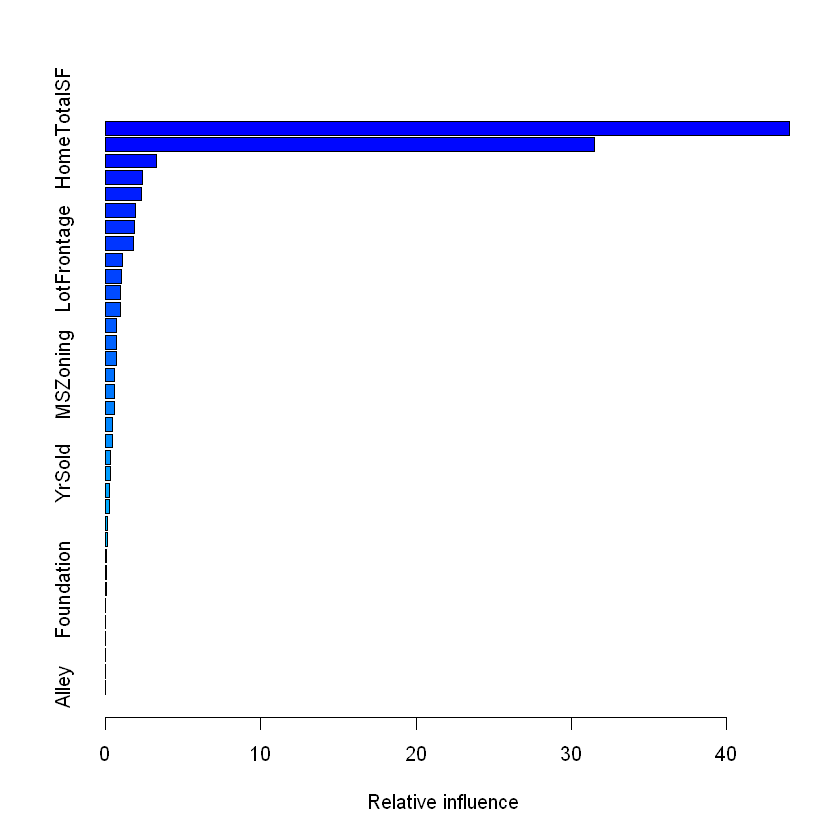

In [109]:
#Gradient Boosting
# n_trees <- rep(0, 7)
# min_cvError <- rep(0, 6)
# for(i in 1:6){
#   set.seed(1)
#   boosting_tree <- gbm(SalePrice ~.-Id, data = cleaned_train_data, distribution = "gaussian",
#                        n.trees = 5000, interaction.depth = i, cv.folds = 10,
#                        shrinkage = 0.01)
#   n_trees[i] <- which.min(boosting_tree$cv.error)
#   min_cvError[i] <- boosting_tree$cv.error[which.min(boosting_tree$cv.error)]
# }
# which.min(min_cvError)
# n_trees[5]

#Create model using best parameters found
boosting_tree <- gbm(SalePrice ~.-Id, data = cleaned_train_data, distribution = "gaussian",
                     n.trees = 1017, interaction.depth = 5,
                     shrinkage = 0.01)

summary(boosting_tree)

#Make predictions 
boosting_best_predict <- predict(boosting_tree, cleaned_test_data)

#Format dataframe for kaggle submission
predictionsBoosting <- data.frame(Id = cleaned_test_data$Id, SalePrice = boosting_best_predict)

#Write to csv 
# write.csv(predictionsBoosting, file = "predictions_boosting.csv", row.names = FALSE)

This model achieved an RMSE of 0.14056. This model is the best performing model out of each type tested in this script. 